In [1]:
import os, sys
sys.path.append("..")

import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import gc
import pdb

from src import distributions
import torch.nn.functional as F

from src.resnet import ResNet_D
from src.unet import UNet

from src.tools import unfreeze, freeze
from src.tools import load_dataset, get_sde_pushed_loader_stats
from src.fid_score import calculate_frechet_distance
from src.tools import weights_init_D
# from src.plotters import plot_random_sde_images, plot_fixed_sde_images, plot_fixed_sde_trajectories, plot_random_sde_trajectories, plot_several_fixed_sde_trajectories, plot_several_random_sde_trajectories

from collections import defaultdict
from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb
from src.tools import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

import math
import gc
import wandb
import json
import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

In [2]:
# gc.collect(); torch.cuda.empty_cache()

In [3]:
# DATASET1  = 'celeba_hq'
# DATASET2 = 'anime_faces'

# IMG_SIZE = 64
# BATCH_SIZE = 64

In [4]:
# X_sampler, X_test_sampler = load_dataset(DATASET1, img_size=IMG_SIZE, batch_size=BATCH_SIZE, num_workers=8)
# Y_sampler, Y_test_sampler = load_dataset(DATASET2, img_size=IMG_SIZE, batch_size=BATCH_SIZE, num_workers=8)
    
# torch.cuda.empty_cache(); gc.collect()
# clear_output()

In [5]:
# X_fixed, Y_fixed = X_sampler.sample(10), Y_sampler.sample(10)

# X_test_fixed, Y_test_fixed = X_test_sampler.sample(10), Y_test_sampler.sample(10)

In [6]:
# plt.imshow(Y_fixed[0, 0].cpu().numpy())

In [7]:
import matplotlib.pyplot as plt
# %matplotlib inline 
import numpy as np
import torch

import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torch.utils import data
import gc

import wandb

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

from src.resnet import ResNet_D
from src.unet import UNet

from src.tools import fig2img

from src.tools import freeze, unfreeze, weights_init_D, plot_images, plot_random_images

from src.tools import get_pushed_loader_stats, calculate_frechet_distance

In [8]:
T_ITERS = 10
# f_LR, T_LR = 1e-4, 1e-4
f_LR, T_LR = 2e-4, 2e-4
IMG_SIZE = 32
BATCH_SIZE = 128
PLOT_INTERVAL = 10
COST = 'mse' # Mean Squared Error
CPKT_INTERVAL = 1000
MAX_STEPS = 10000
SEED = 0x000000


assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:0')
torch.manual_seed(SEED)
np.random.seed(SEED)

# DATASET1  = 'celeba_hq'
# DATASET2 = 'anime_faces'


DATASET1 = 'MNIST-colored_2'
DATASET2 = 'MNIST-colored_3'


filename = './stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

In [9]:
torch.cuda.empty_cache(); gc.collect()

20

In [10]:
X_sampler, X_test_sampler = load_dataset(DATASET1, img_size=IMG_SIZE, batch_size=BATCH_SIZE, num_workers=8)
Y_sampler, Y_test_sampler = load_dataset(DATASET2, img_size=IMG_SIZE, batch_size=BATCH_SIZE, num_workers=8)
    
torch.cuda.empty_cache(); gc.collect()
clear_output()

In [11]:
f = ResNet_D(IMG_SIZE, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3, base_factor=48).cuda()
    
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)


for i in range(7): #подобрал чтобы лица смотрели прямо
    X_fixed = X_sampler.sample(10)
    Y_fixed = Y_sampler.sample(10)
    
wandb.init(name='strong_NOT_tester', project='diffusion-NOT')

wandb: Currently logged in as: ilyasudakov (sudakov). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


step 240 of 10000
Plotting


KeyboardInterrupt: 

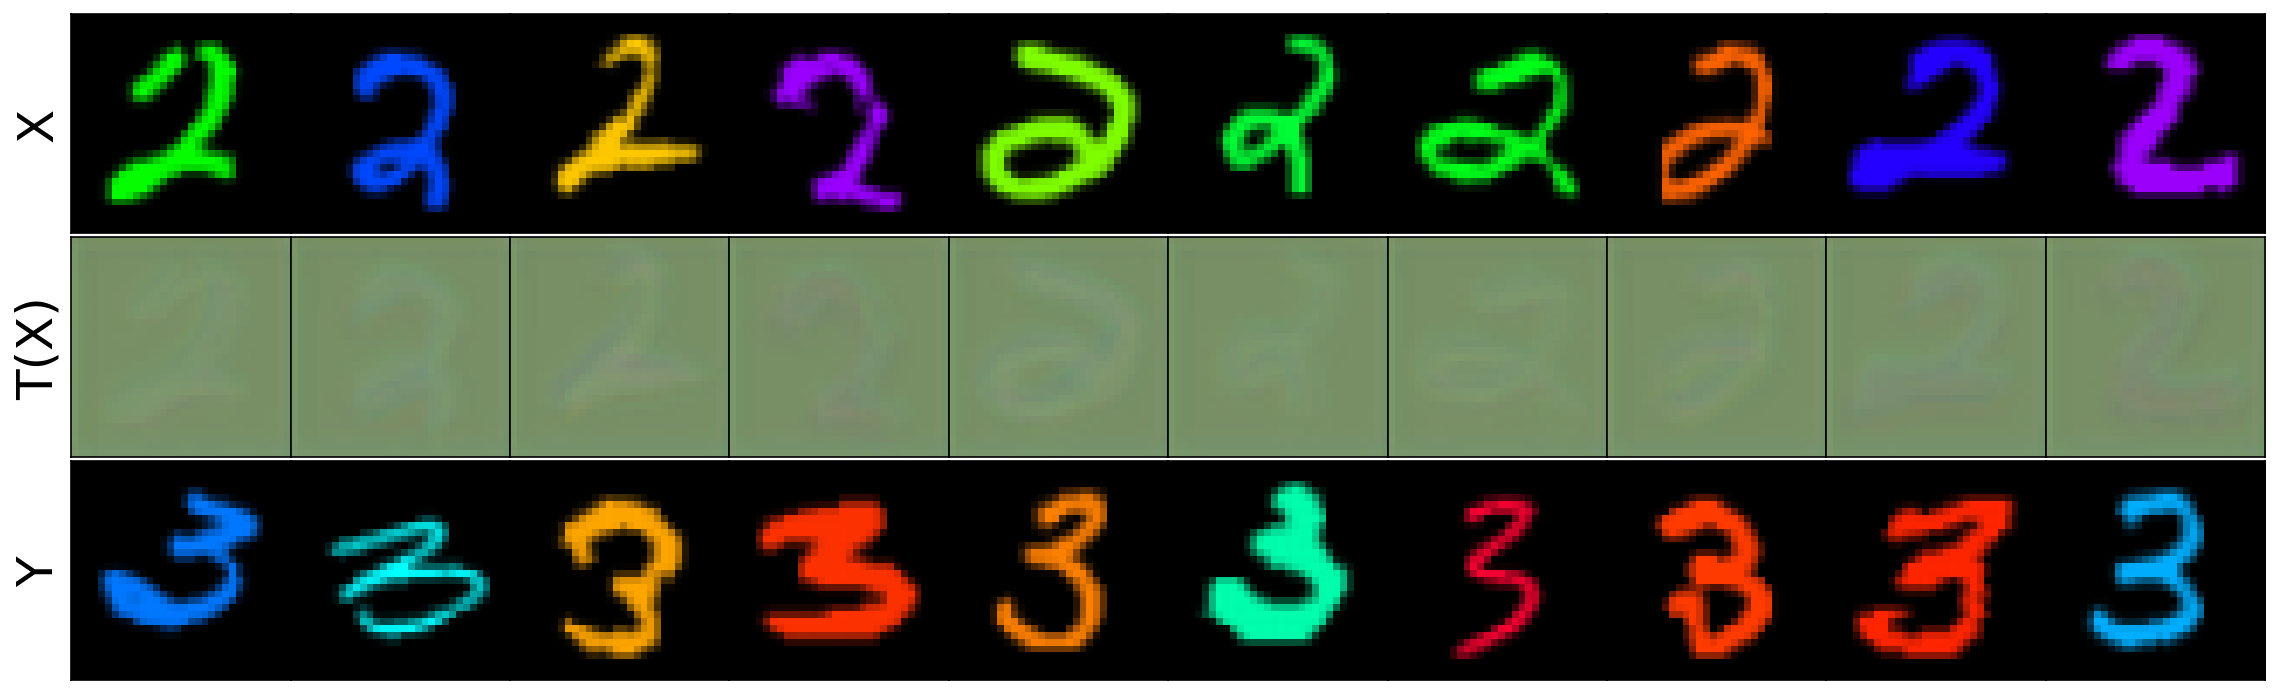

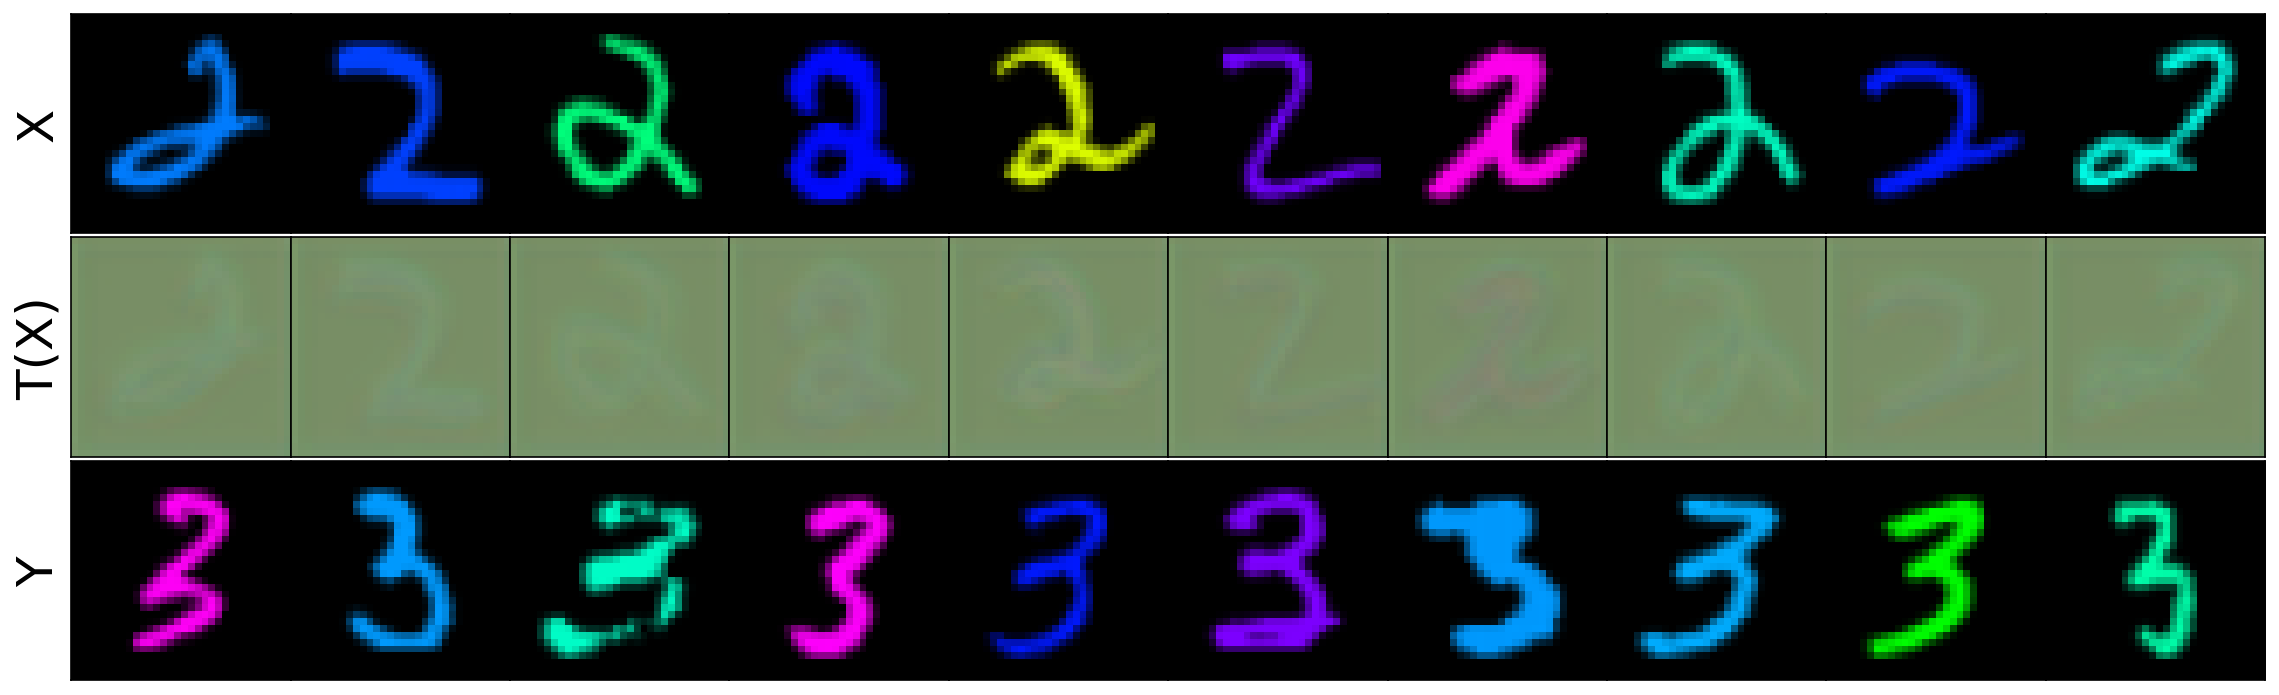

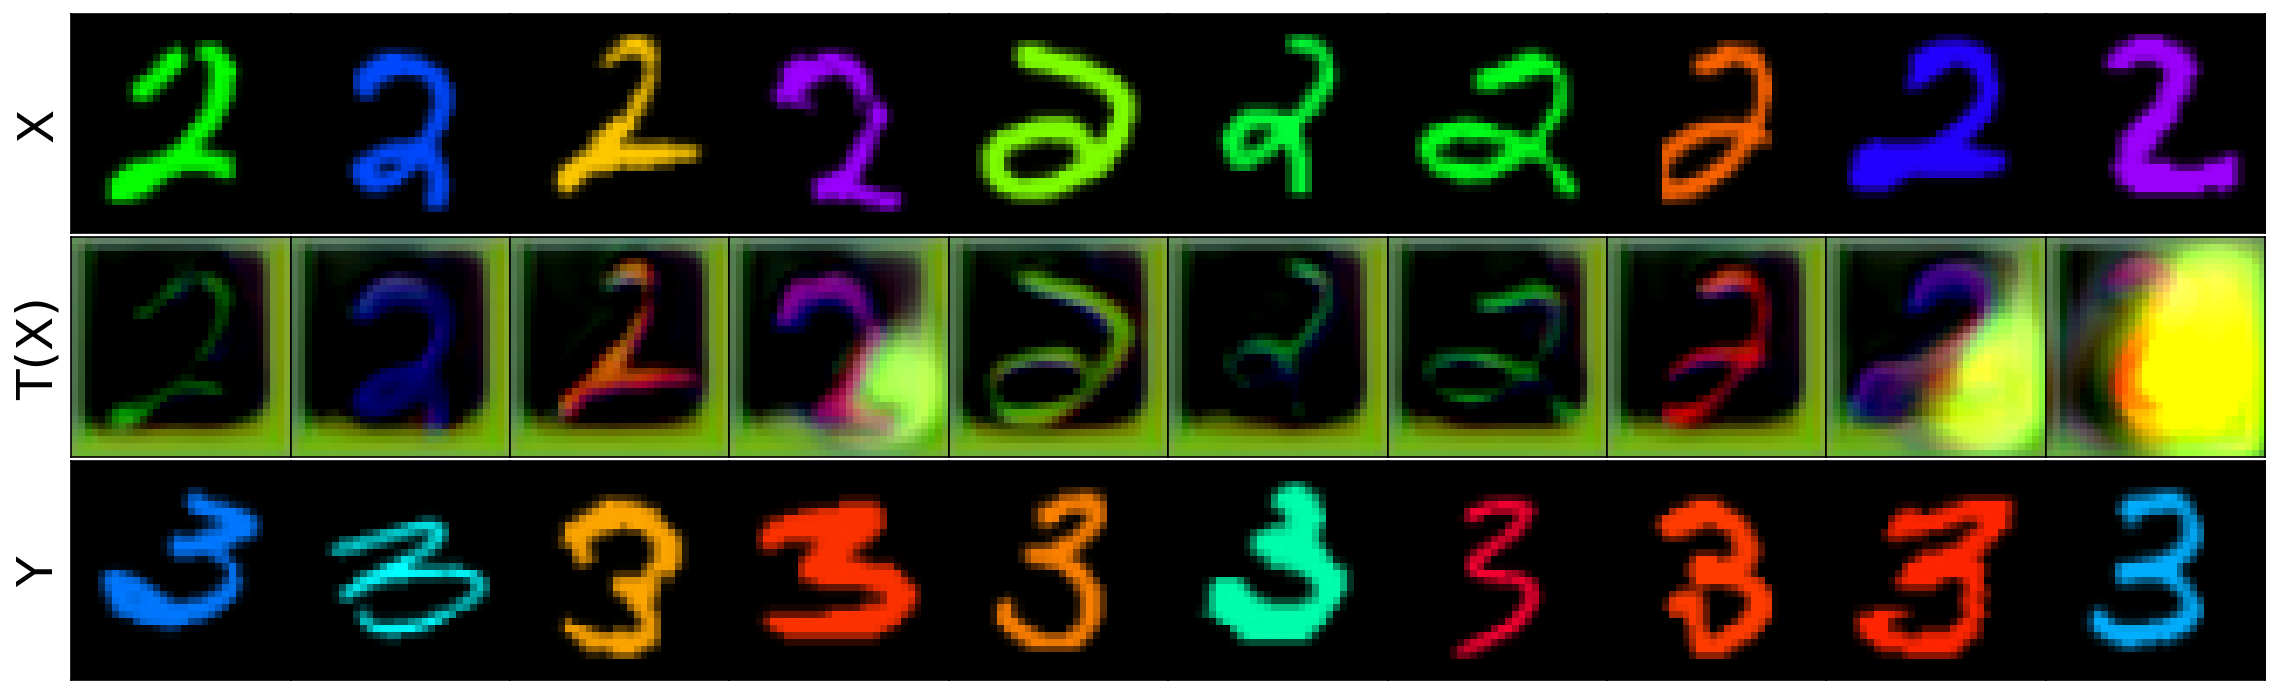

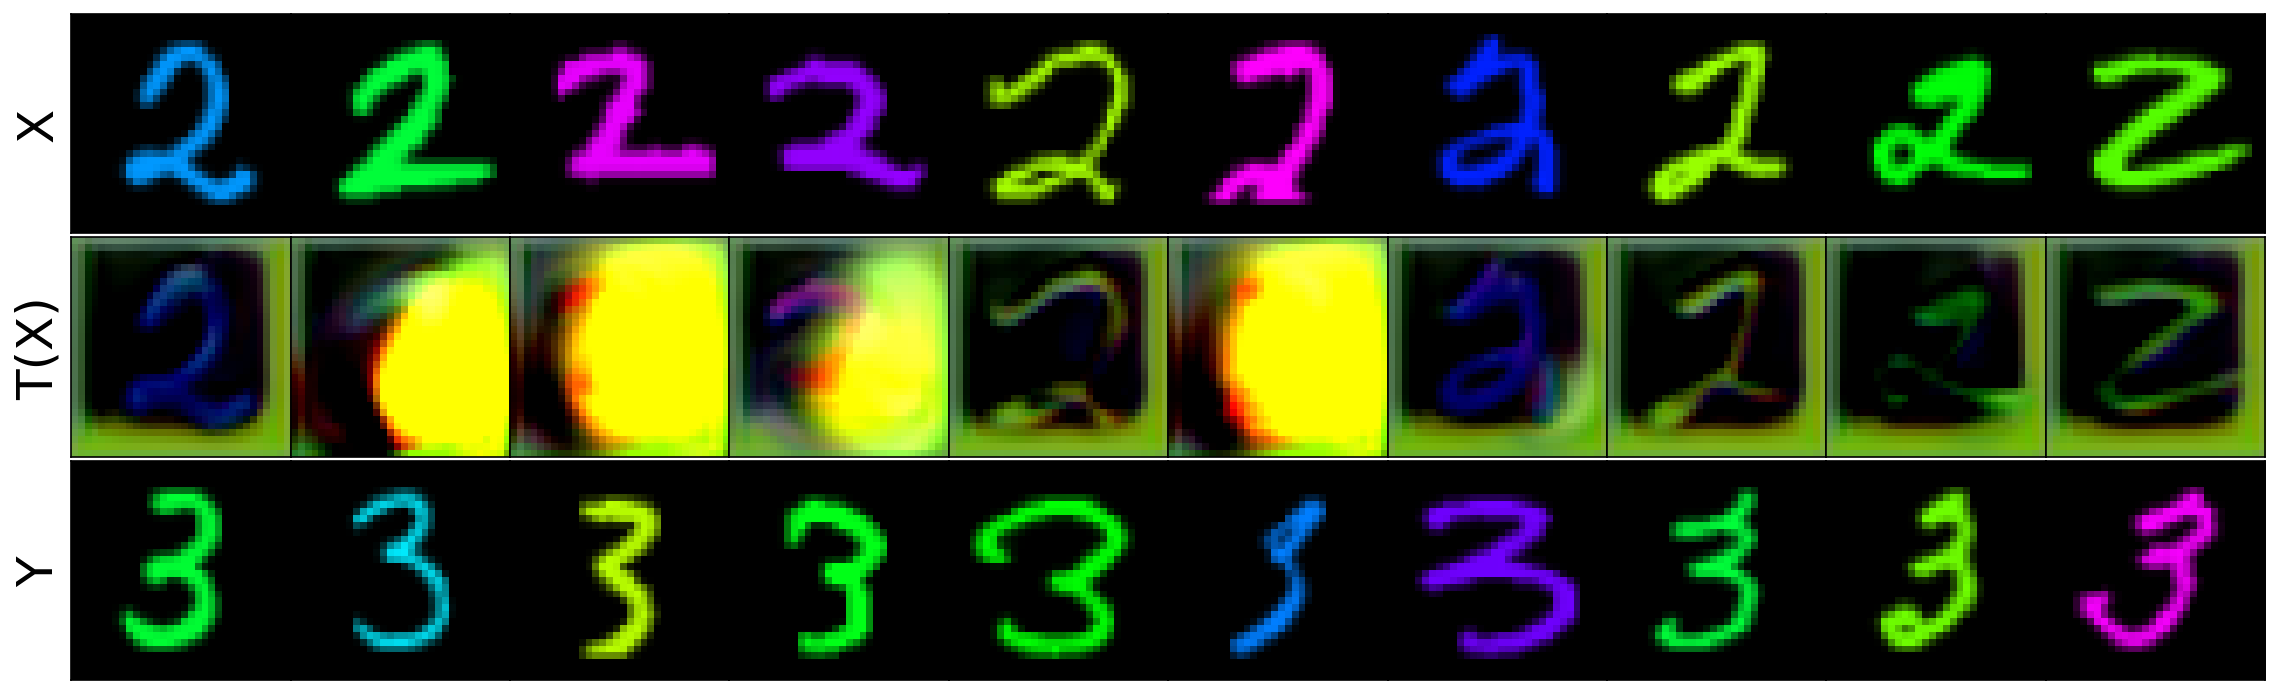

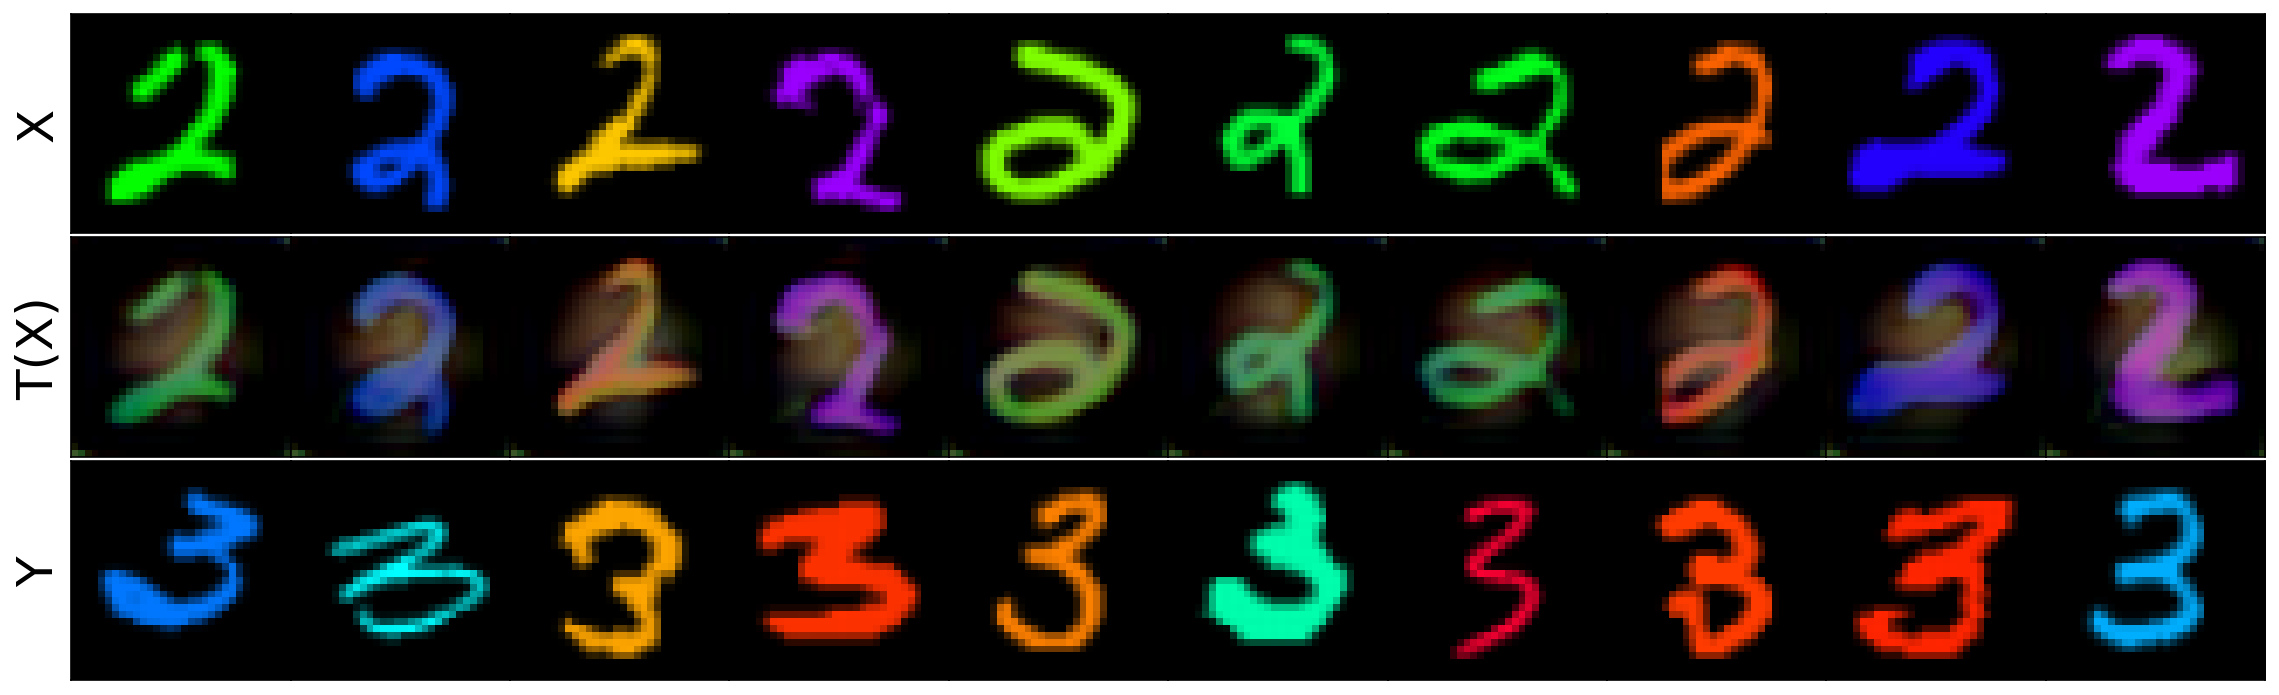

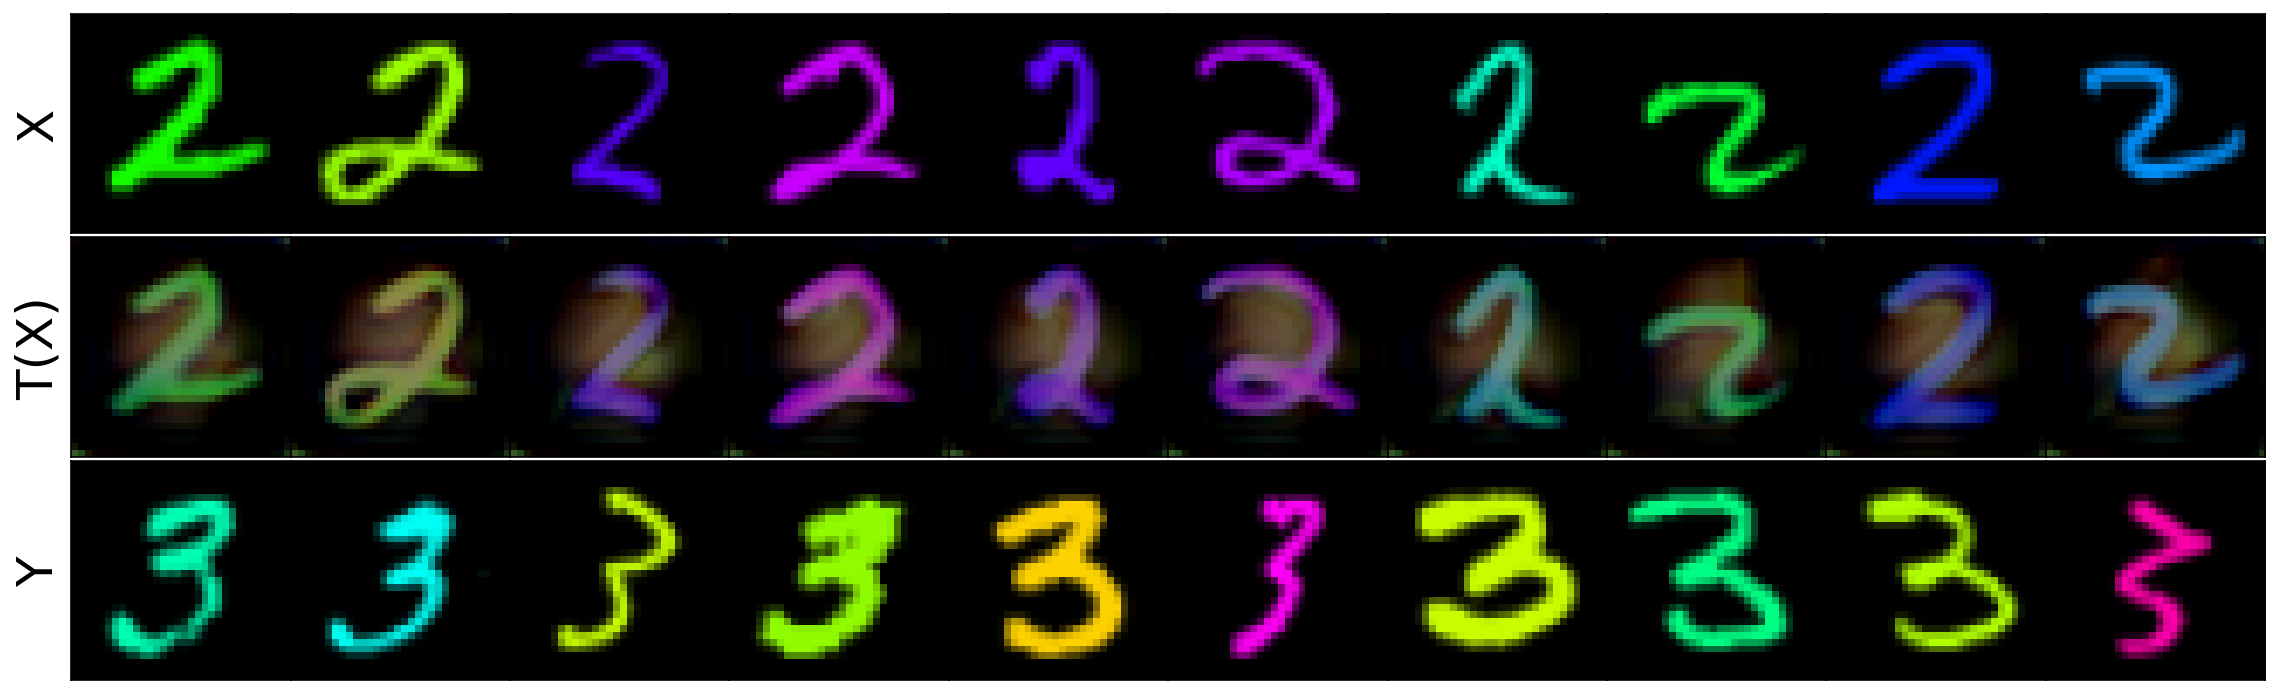

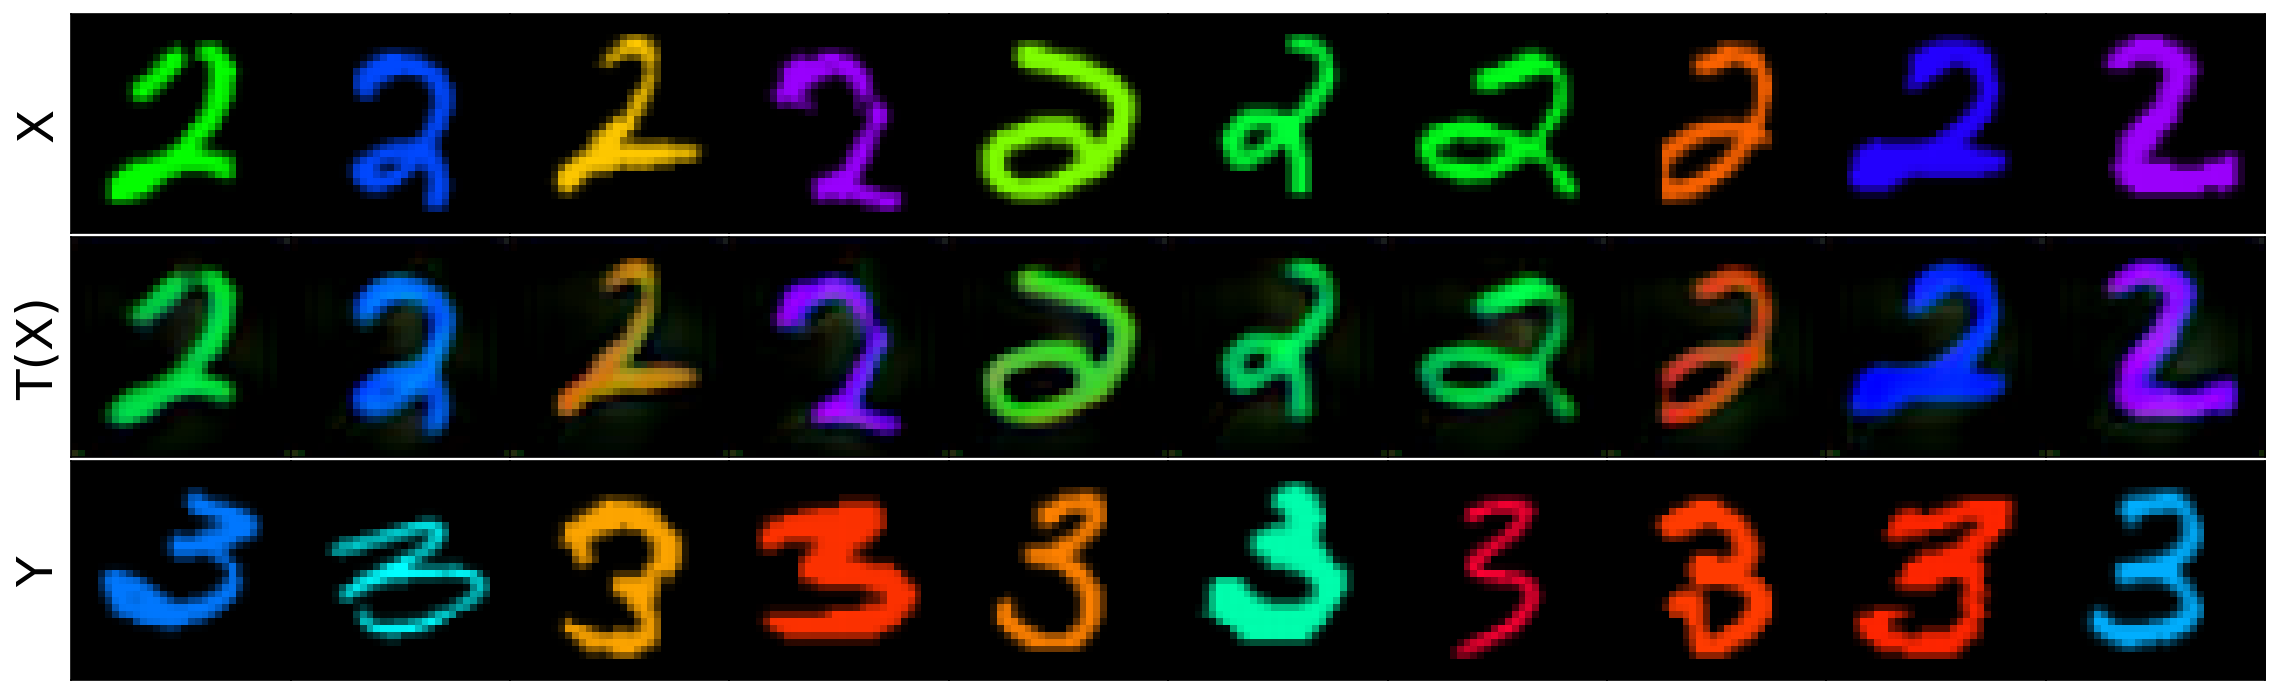

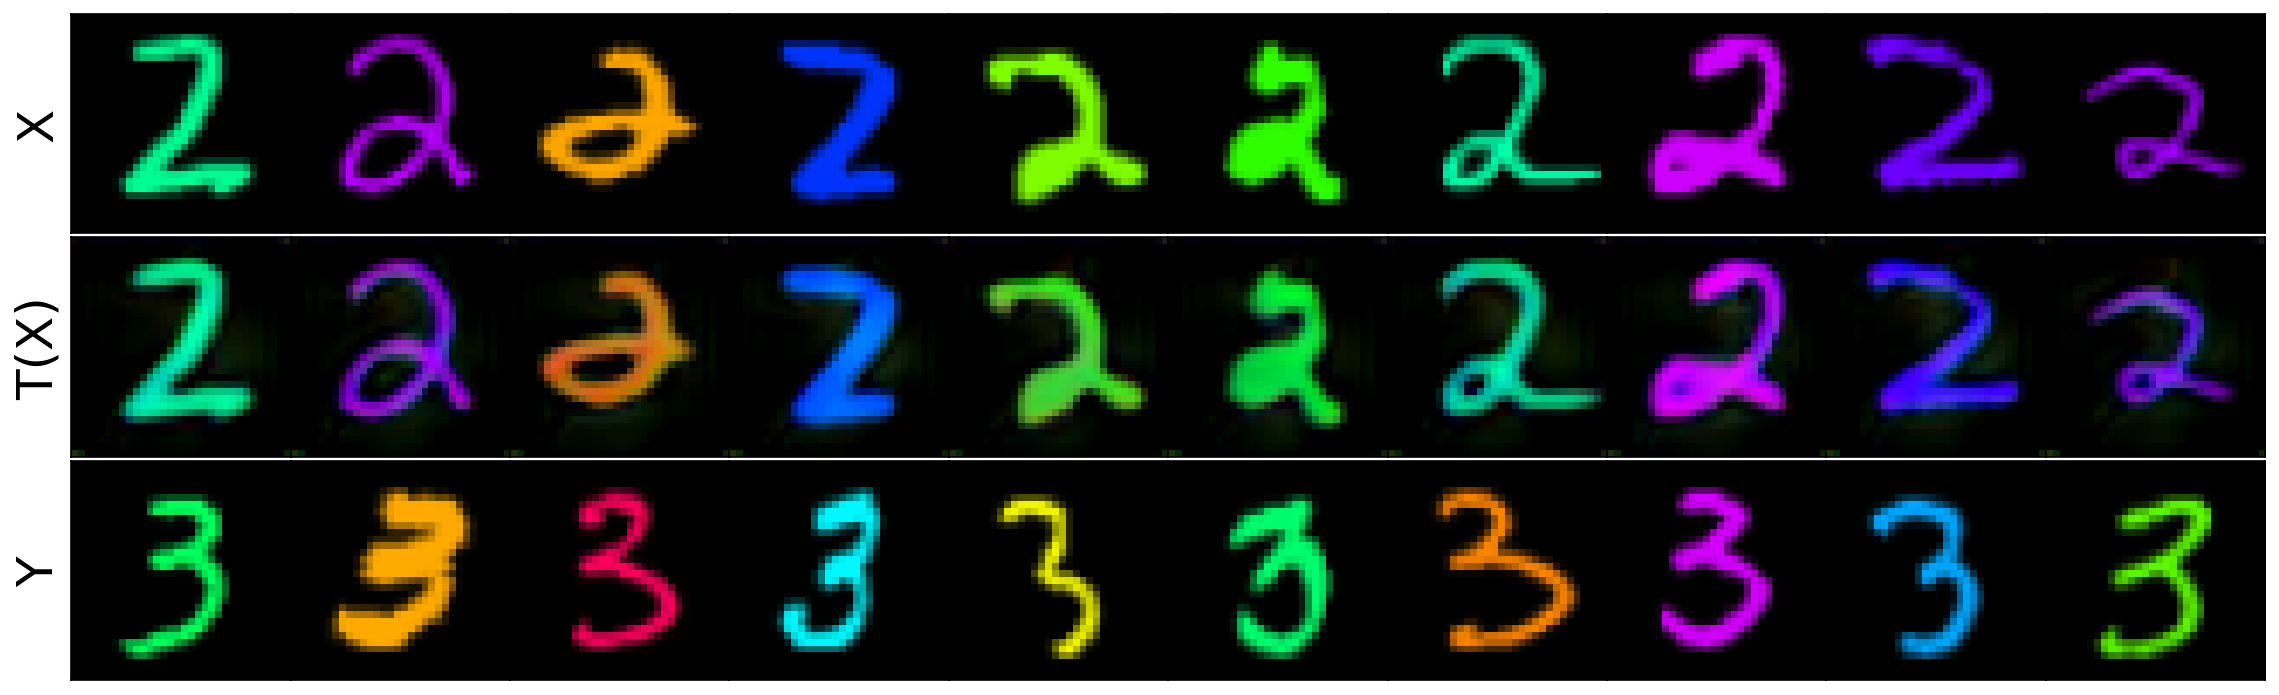

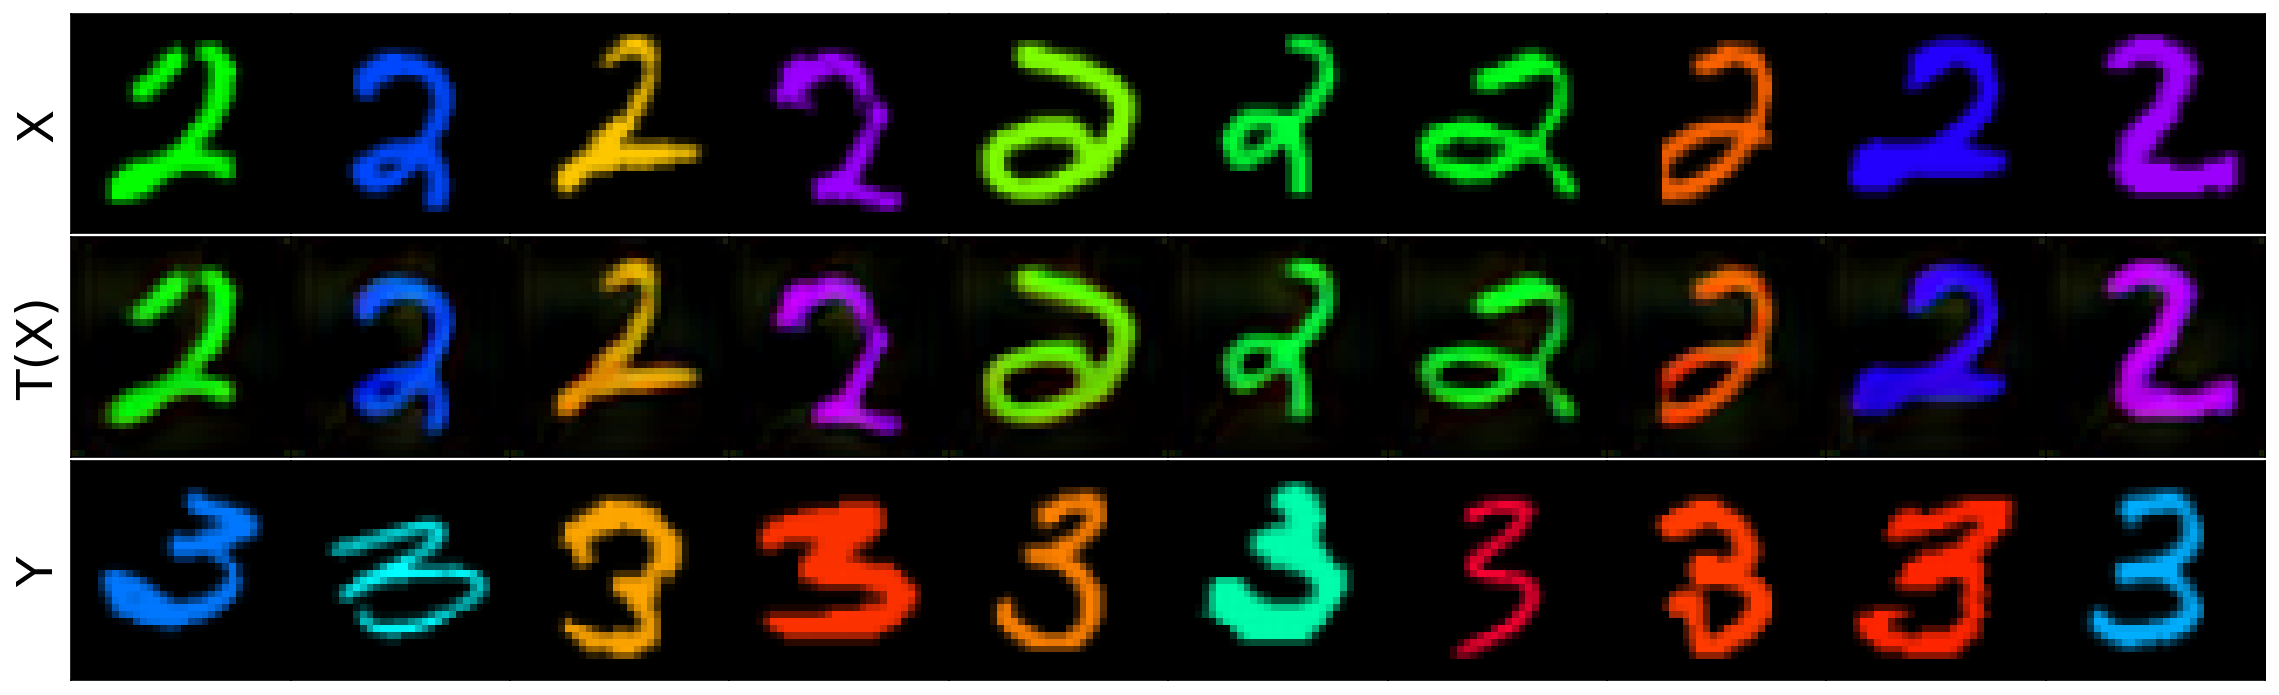

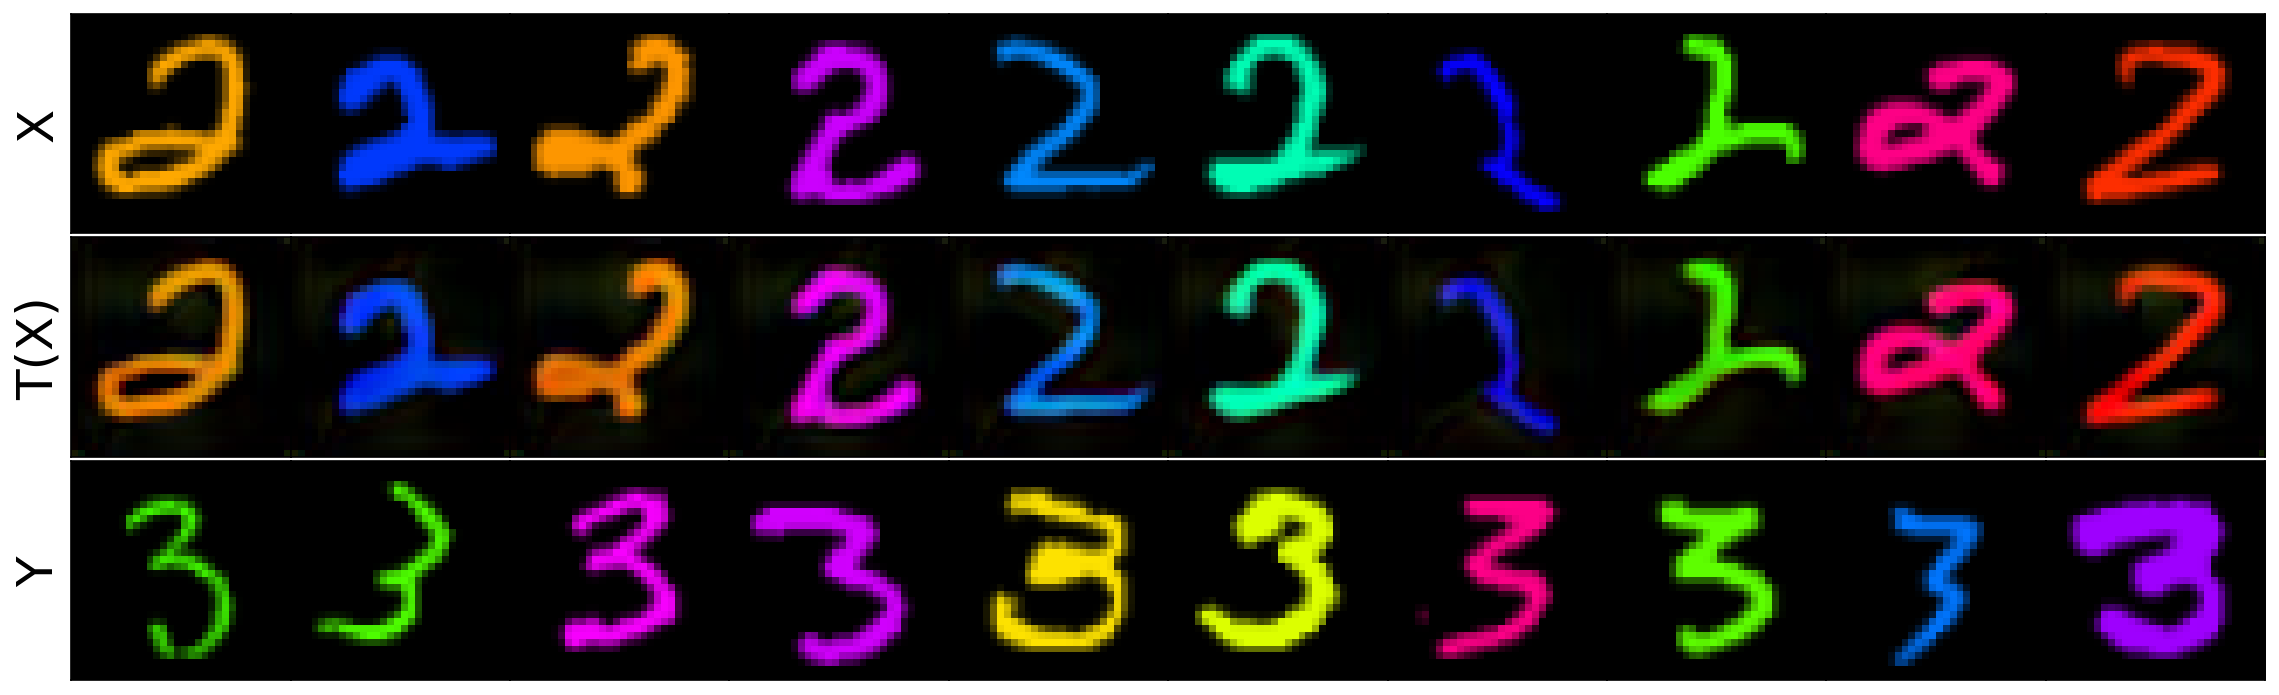

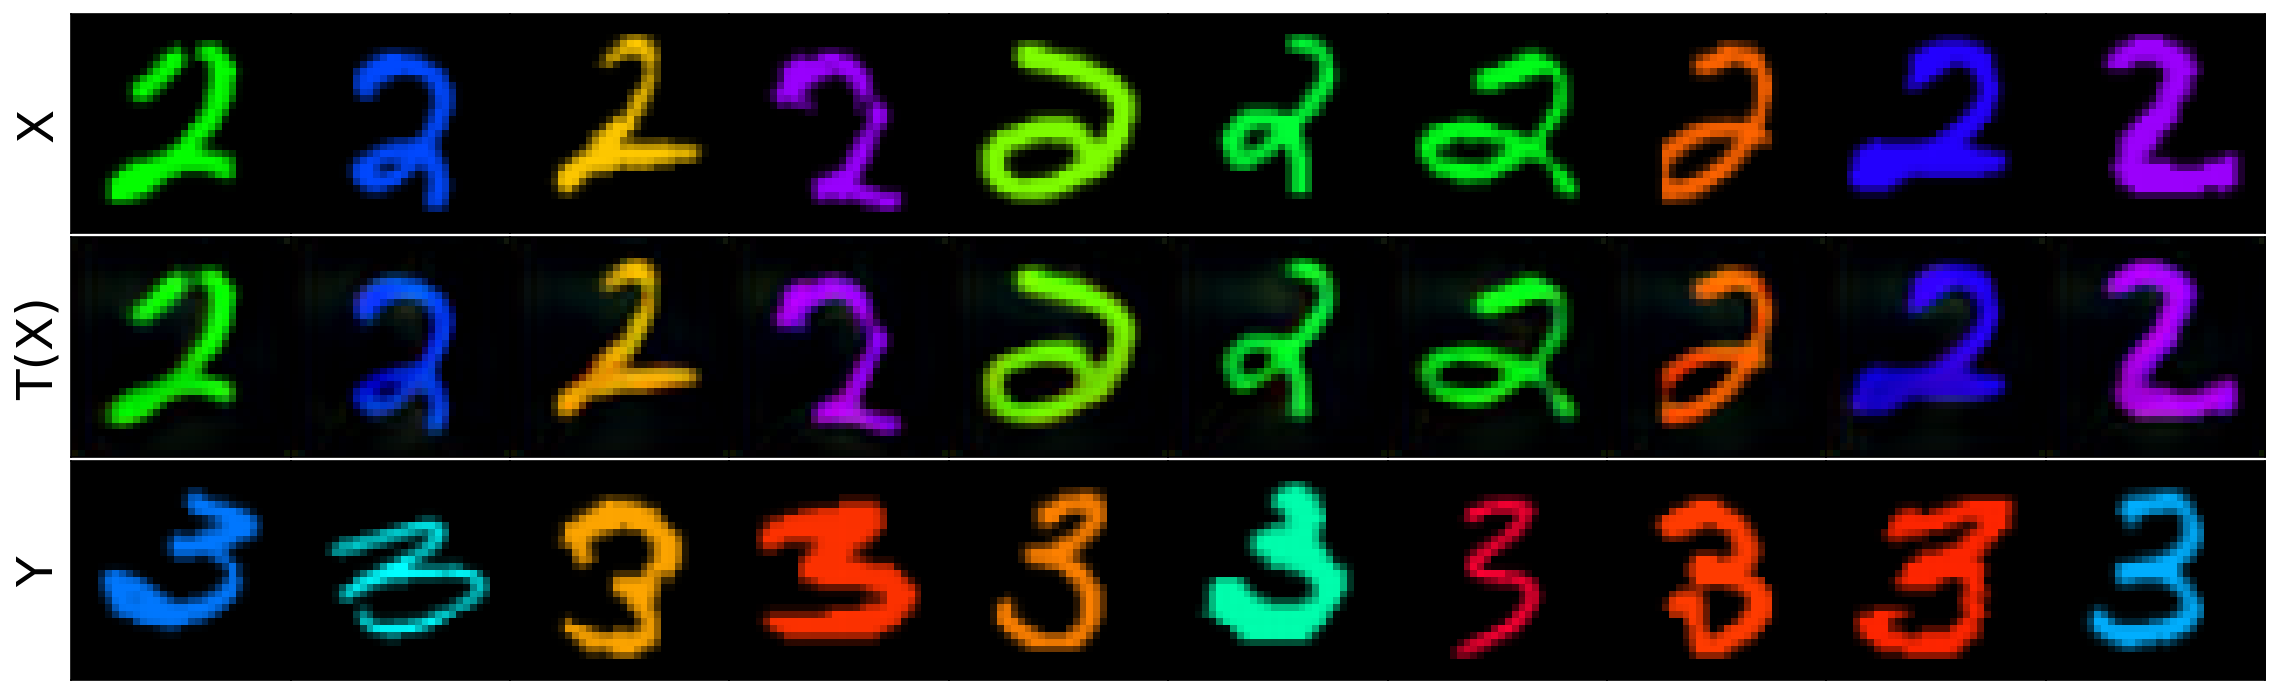

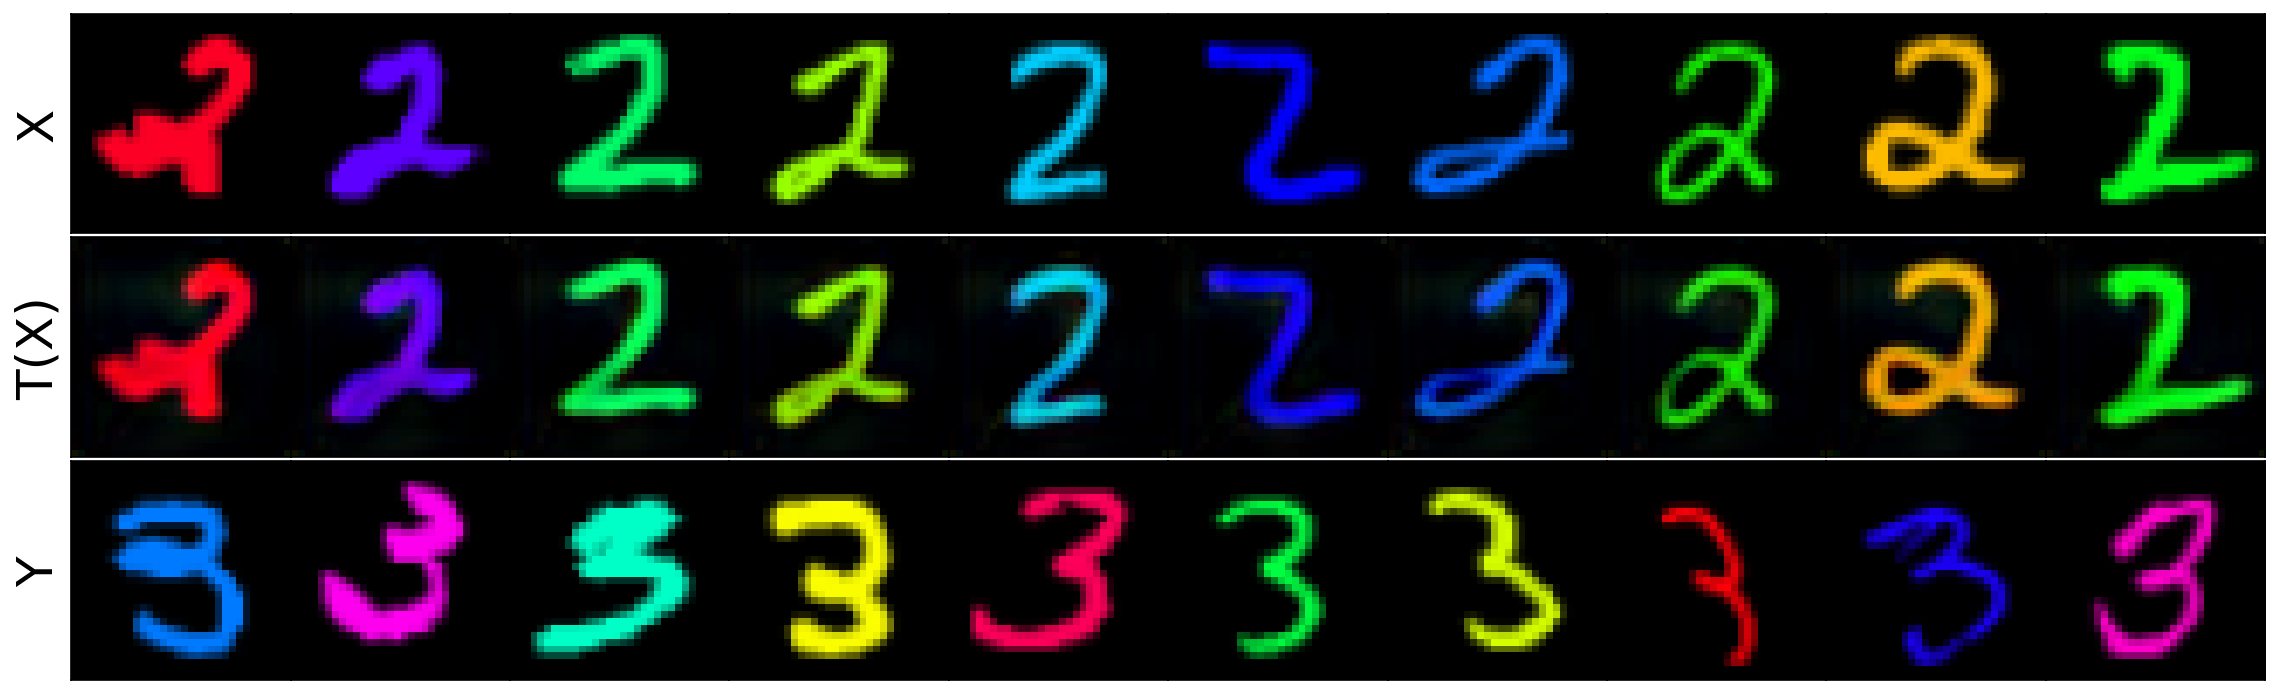

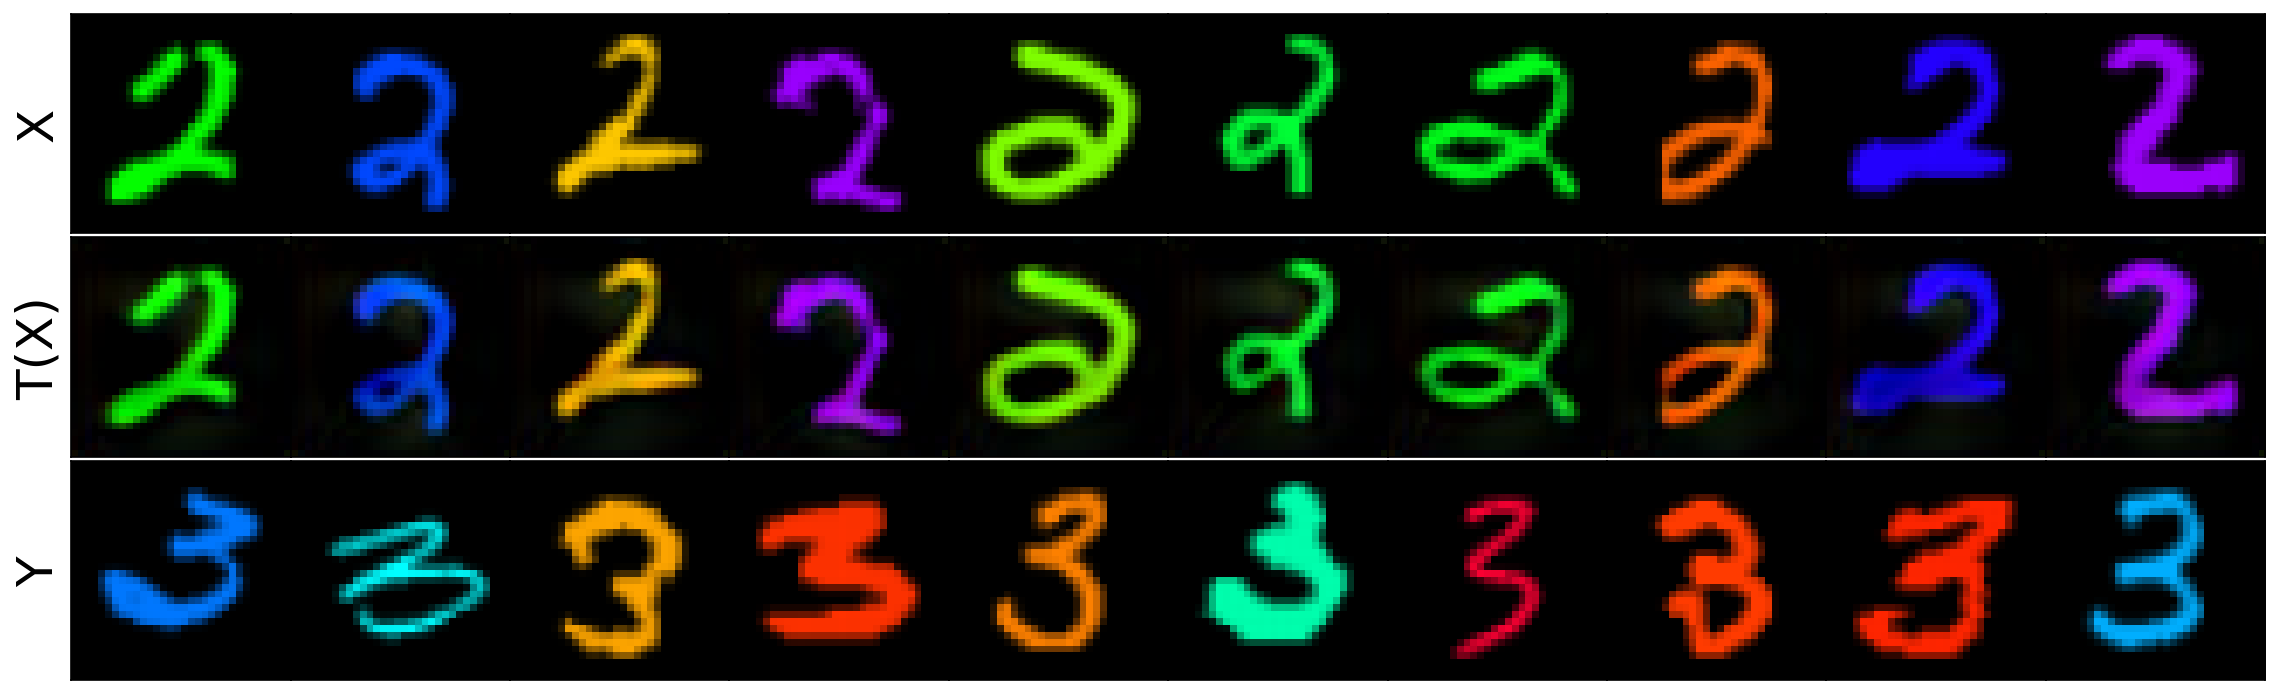

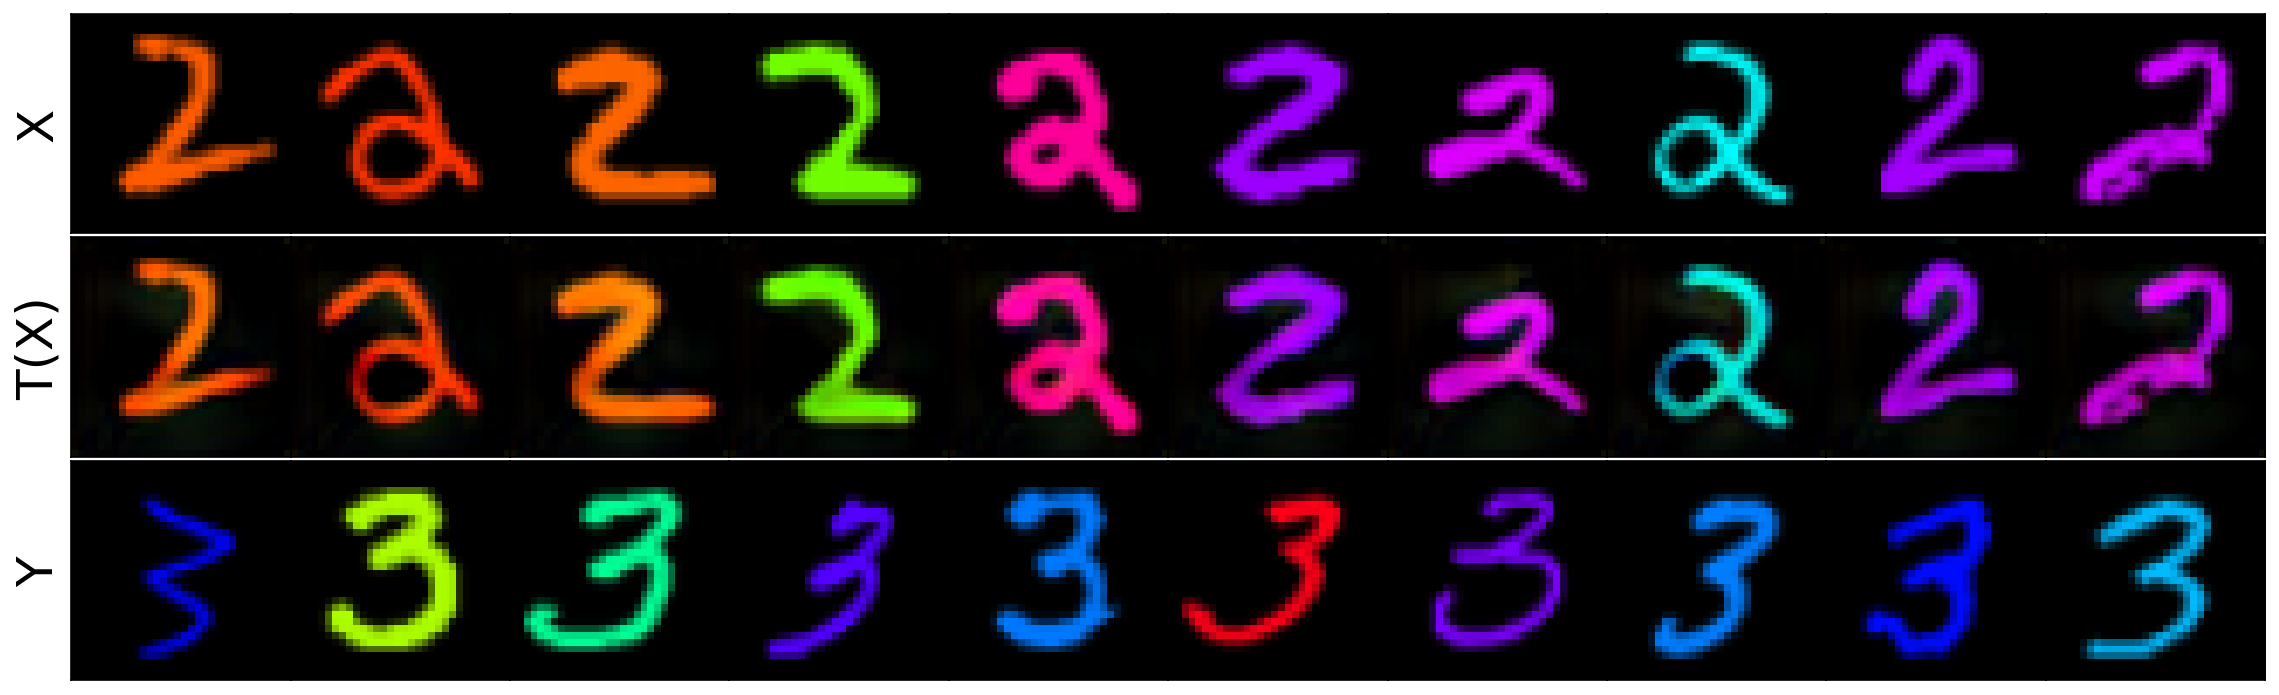

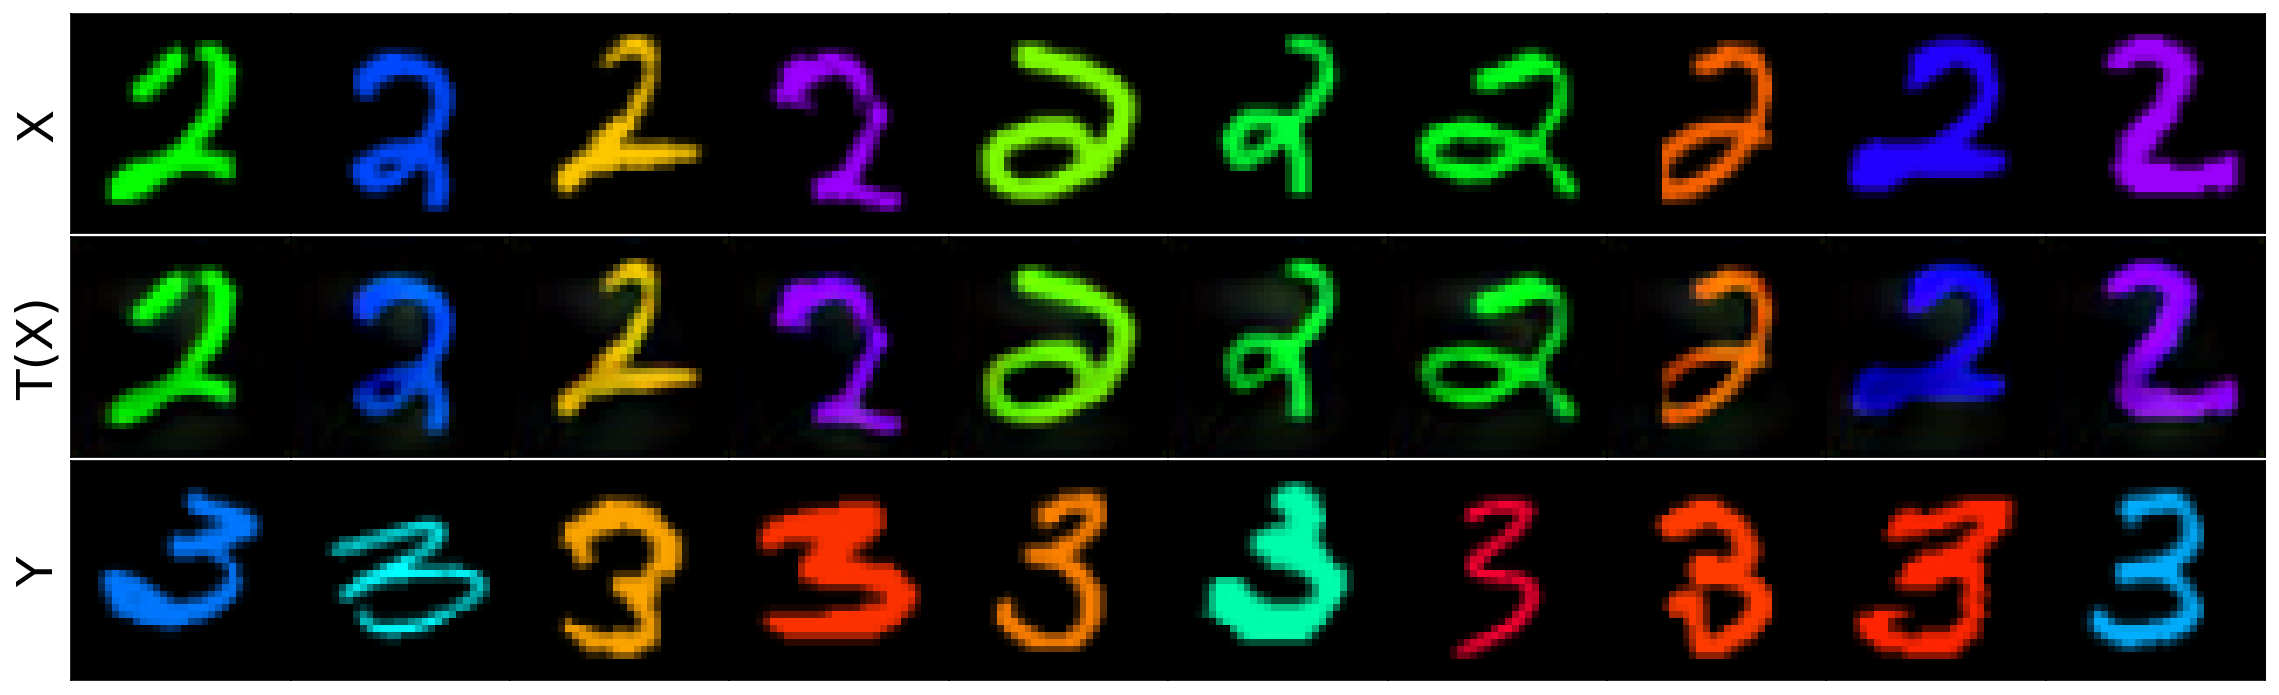

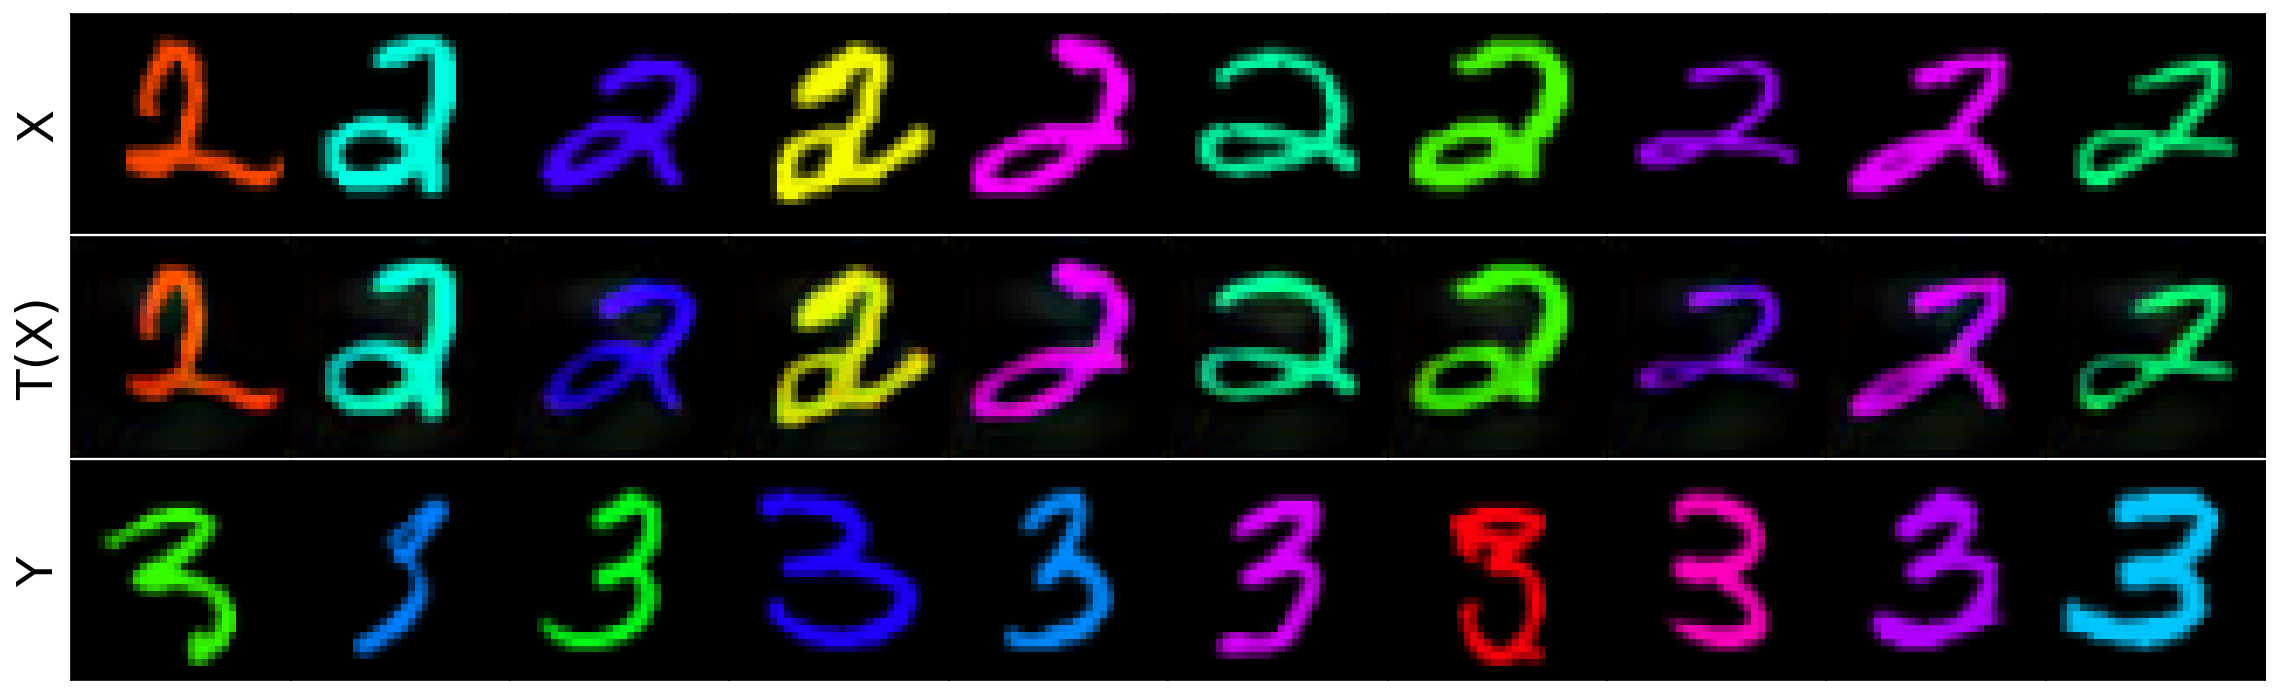

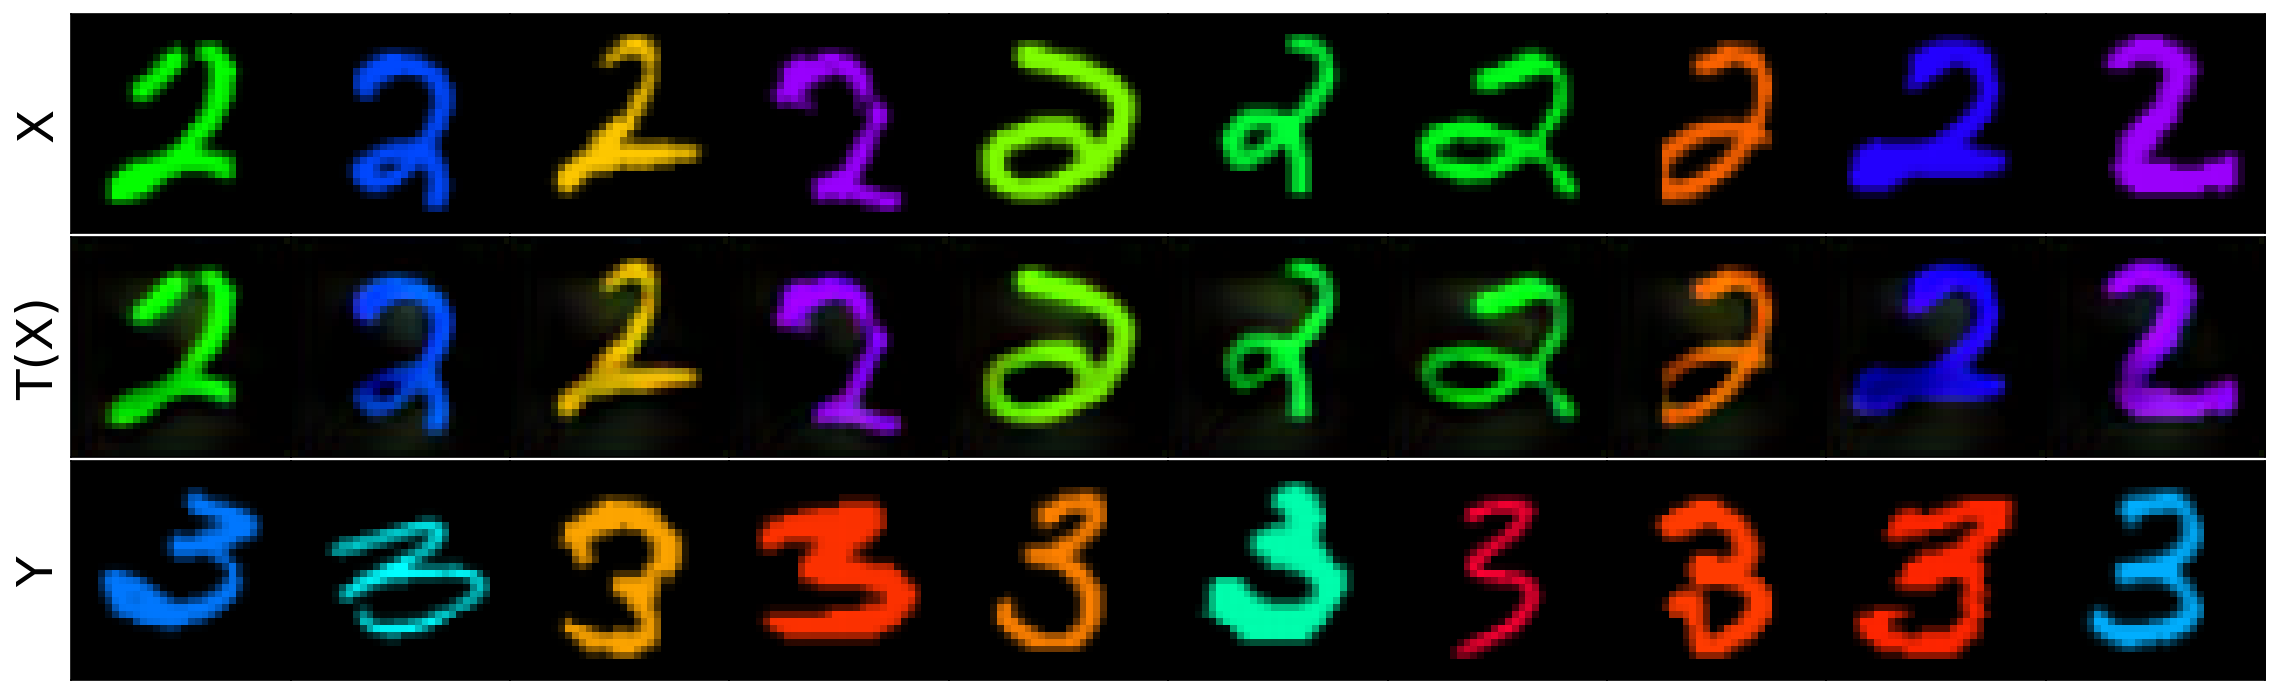

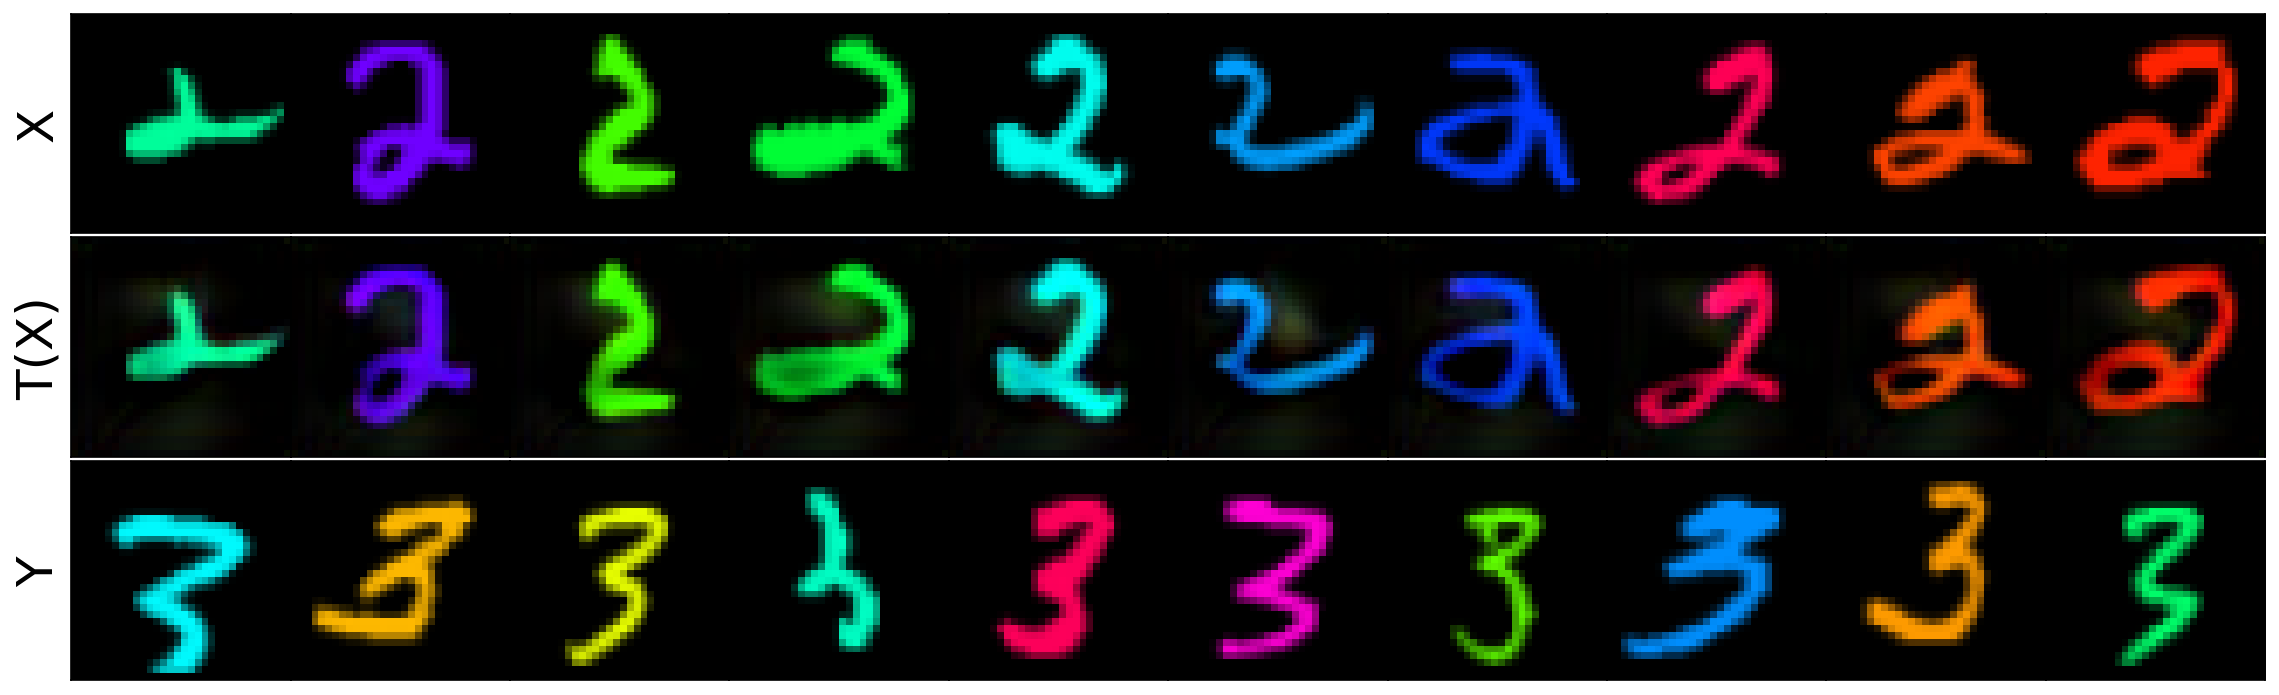

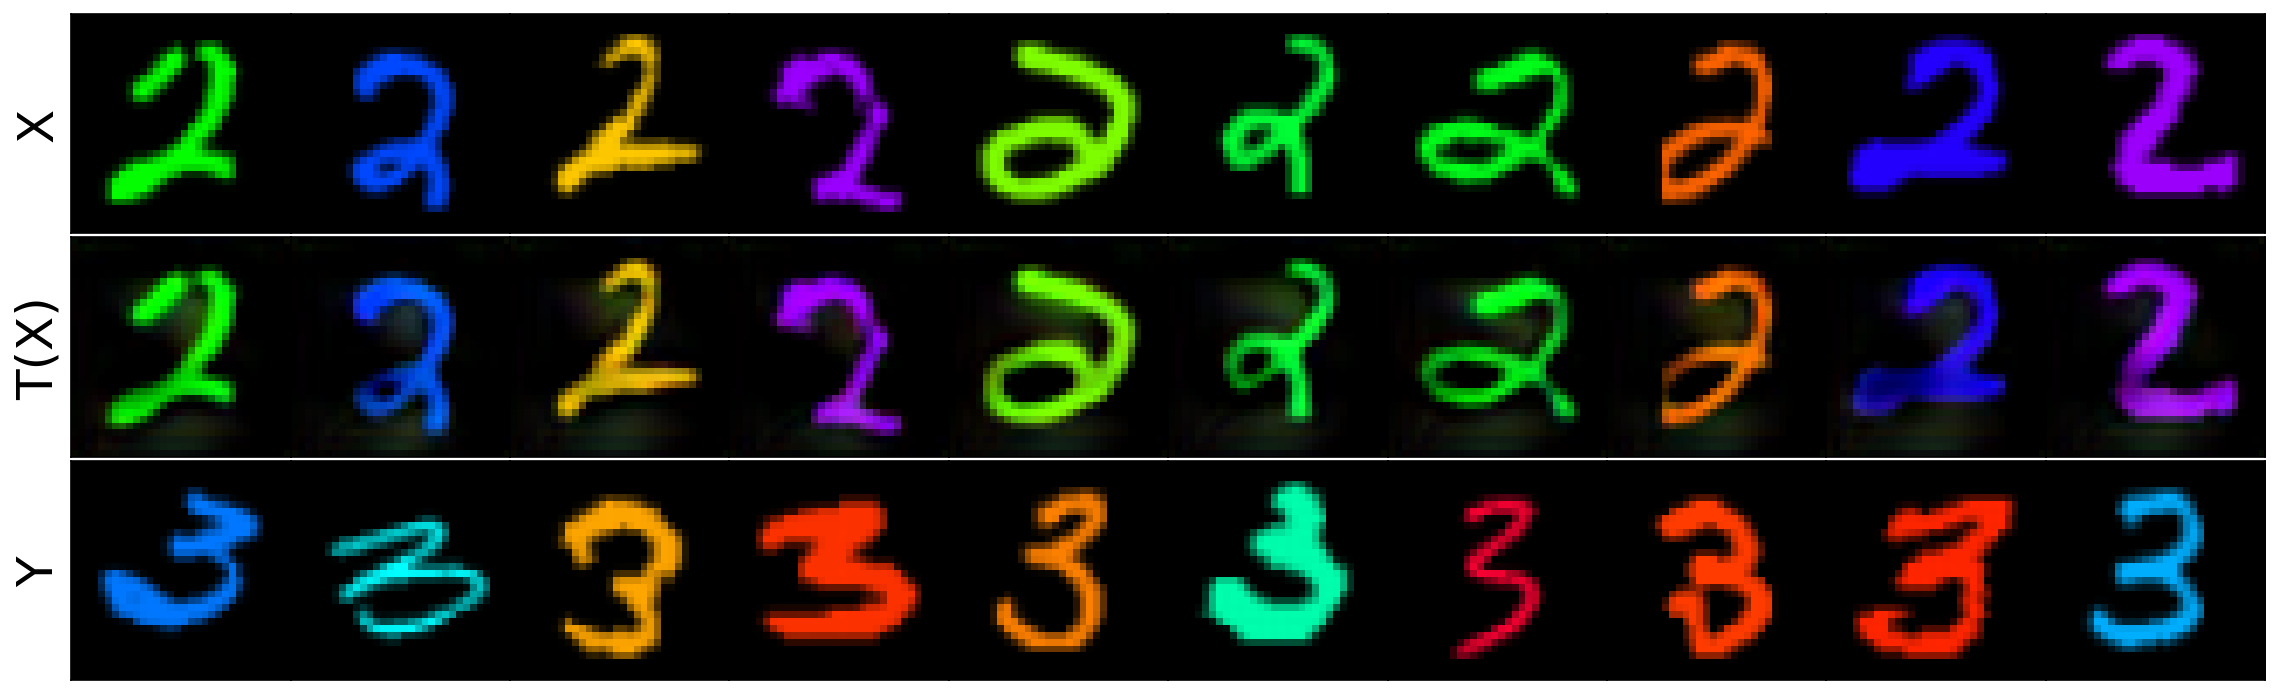

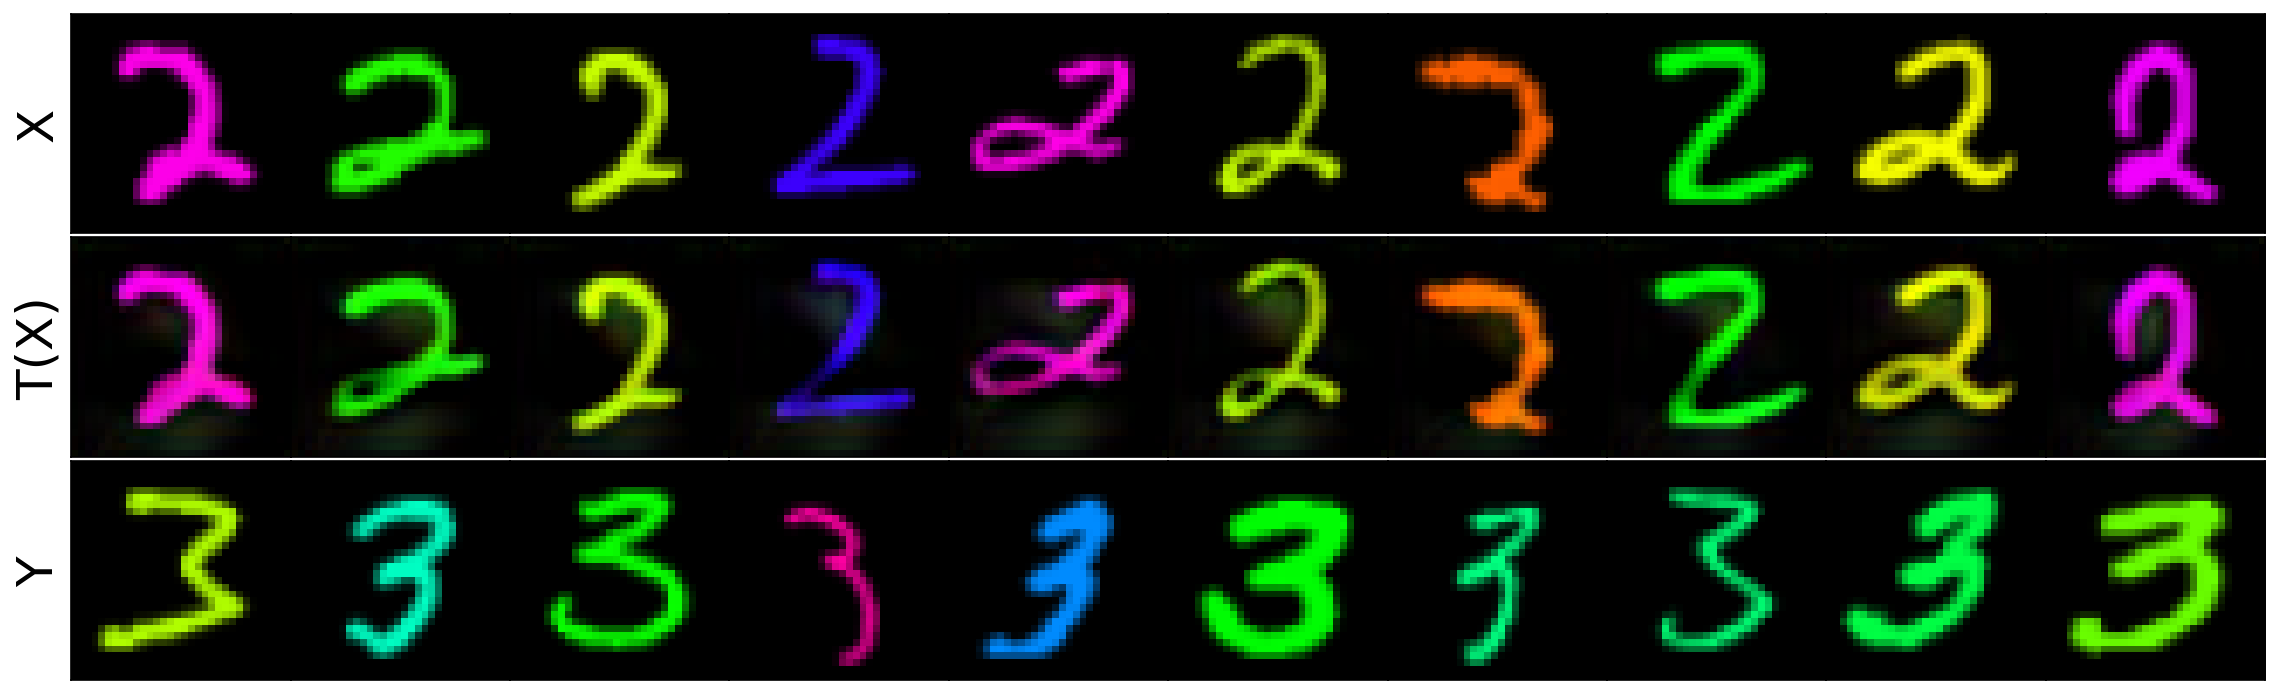

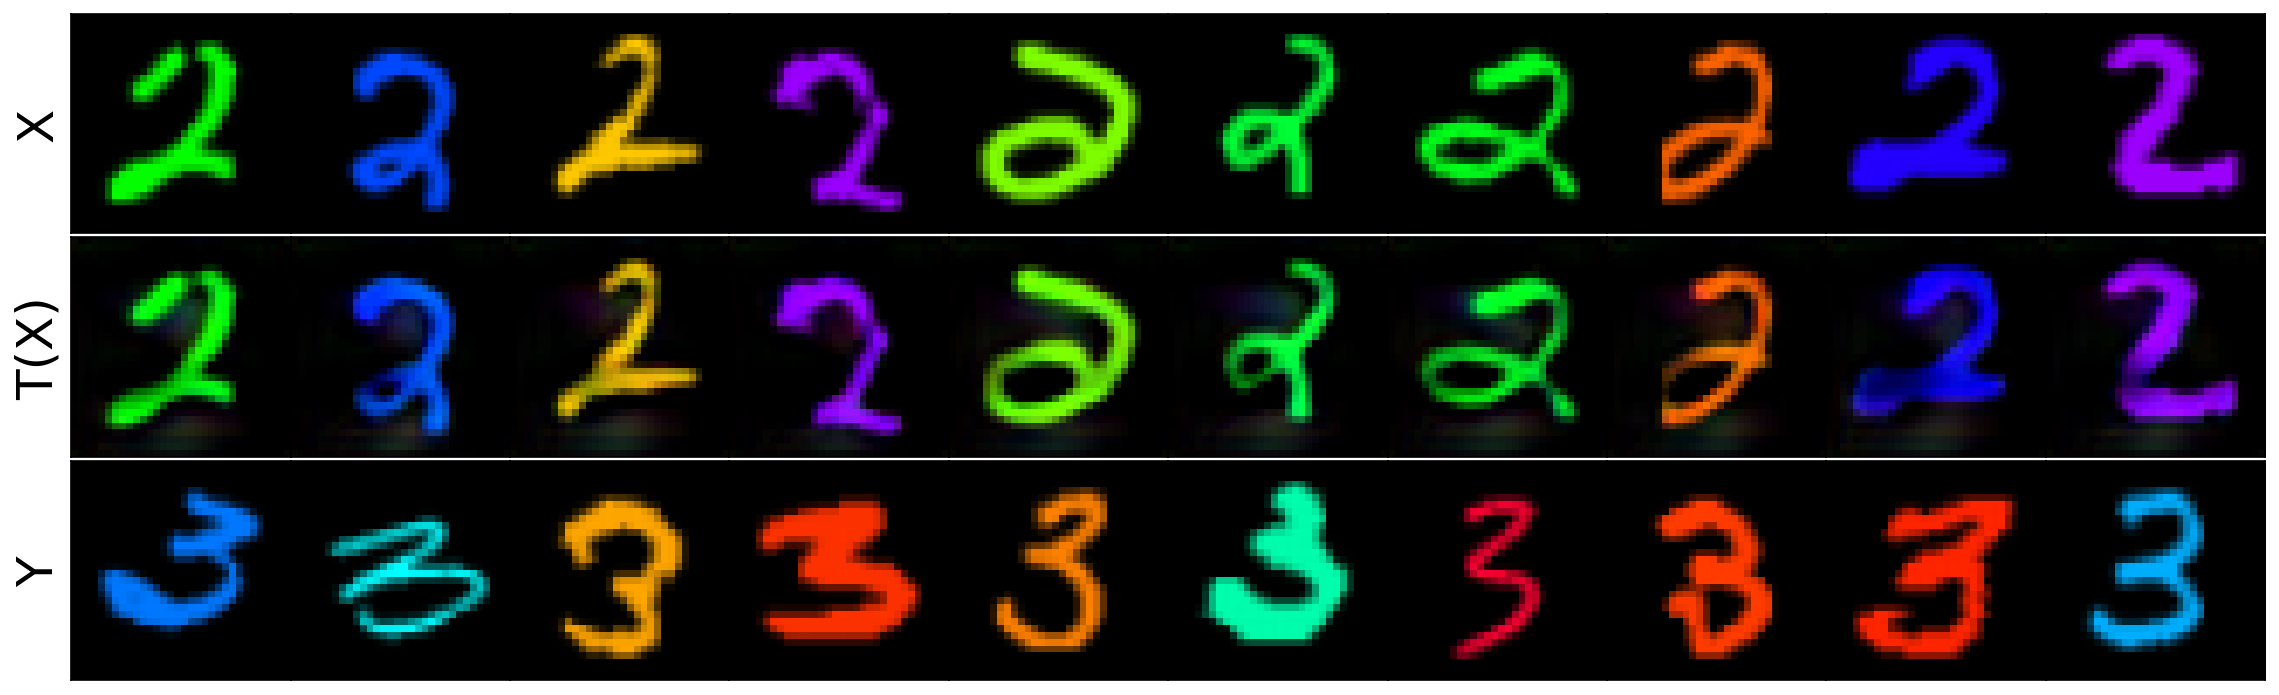

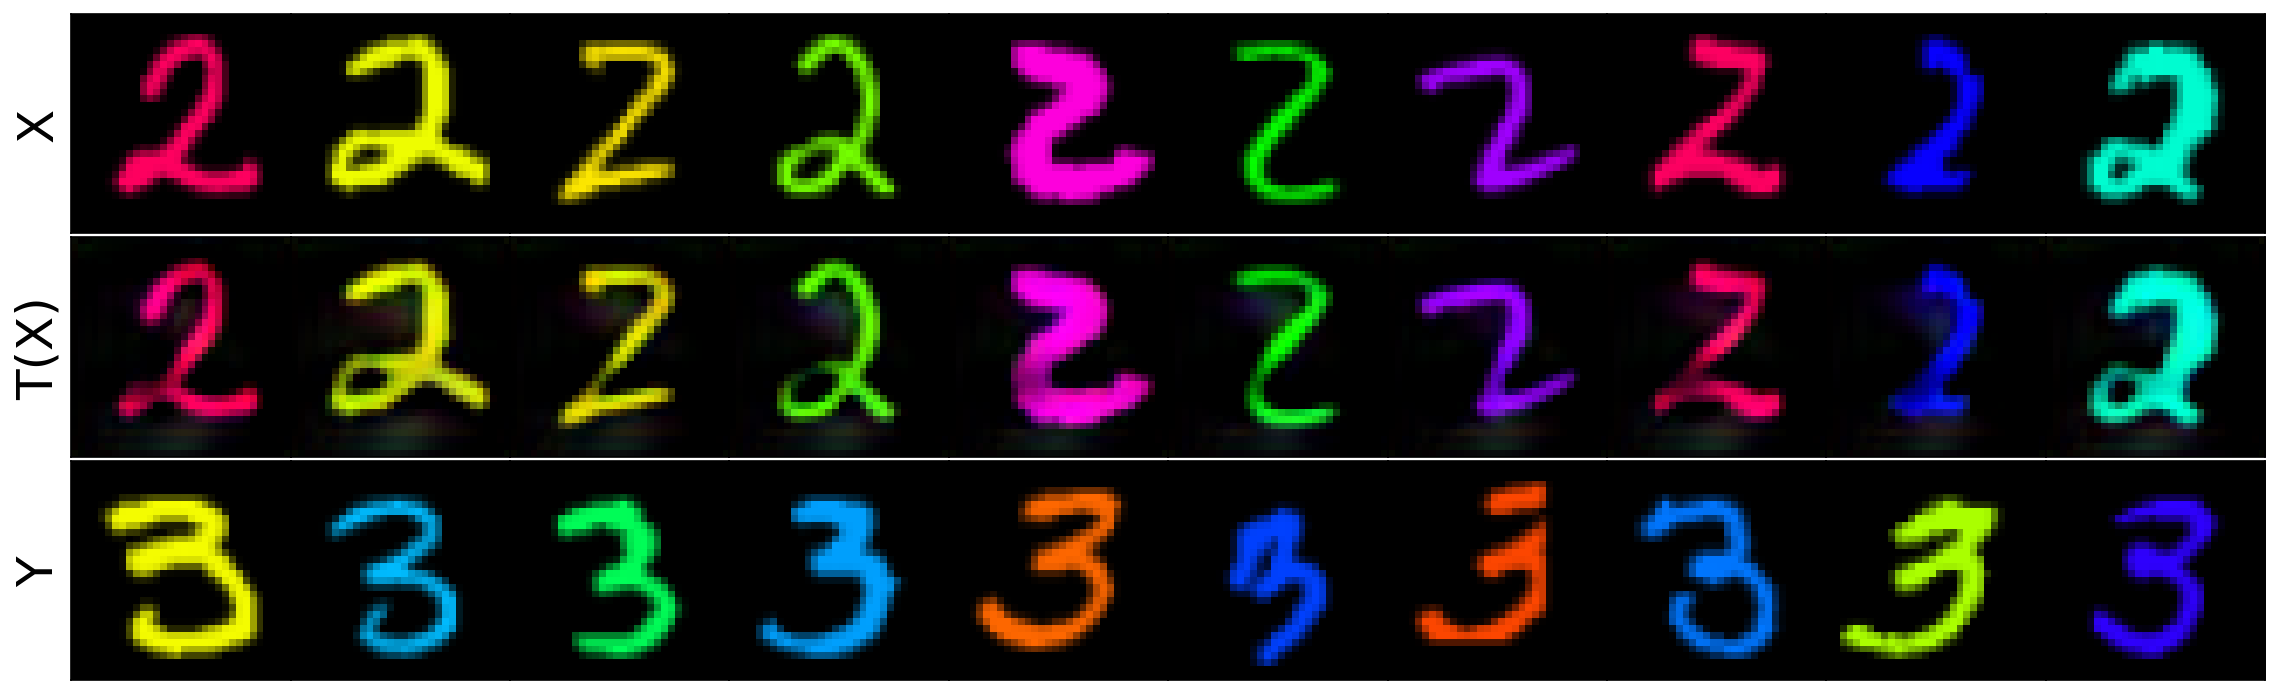

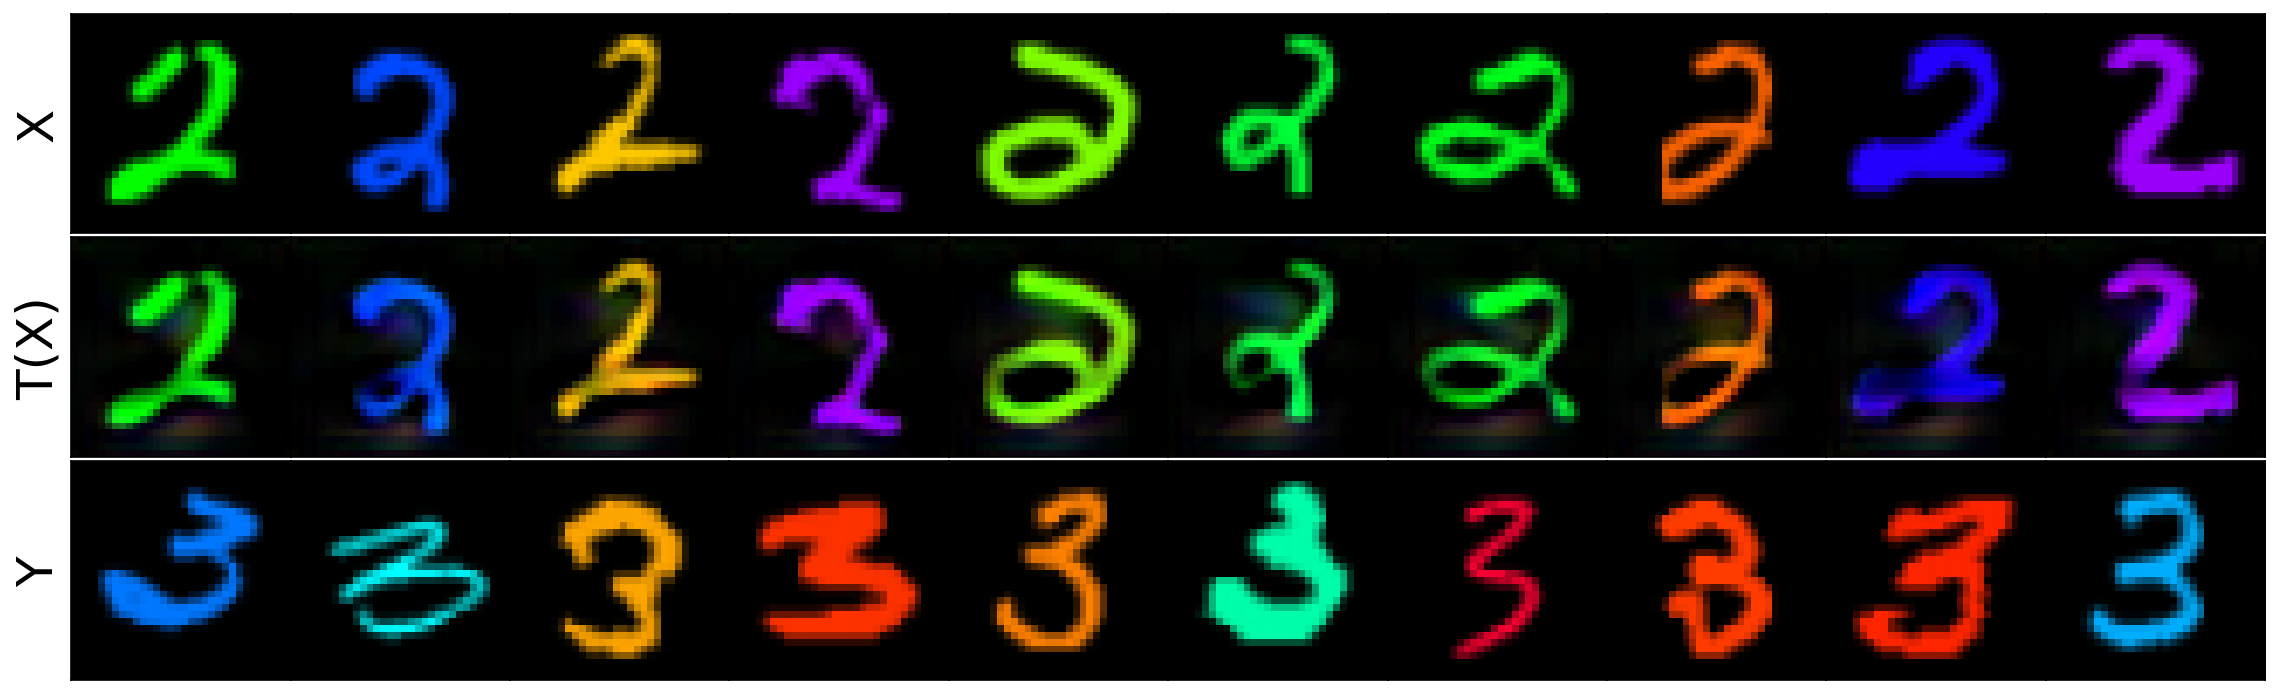

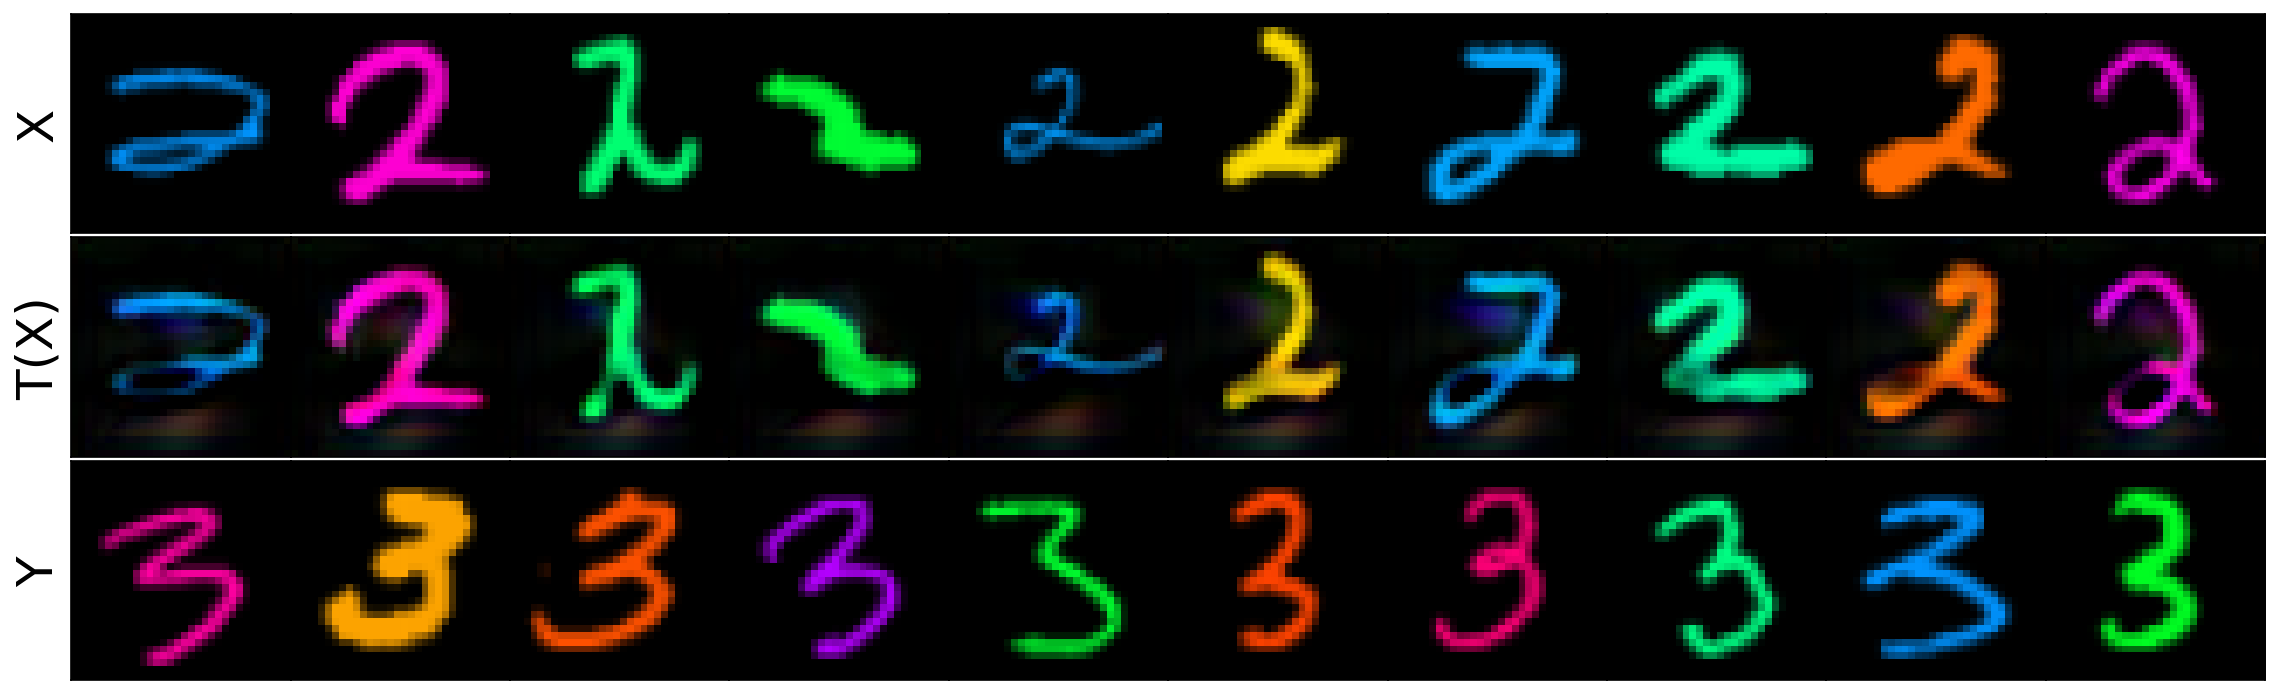

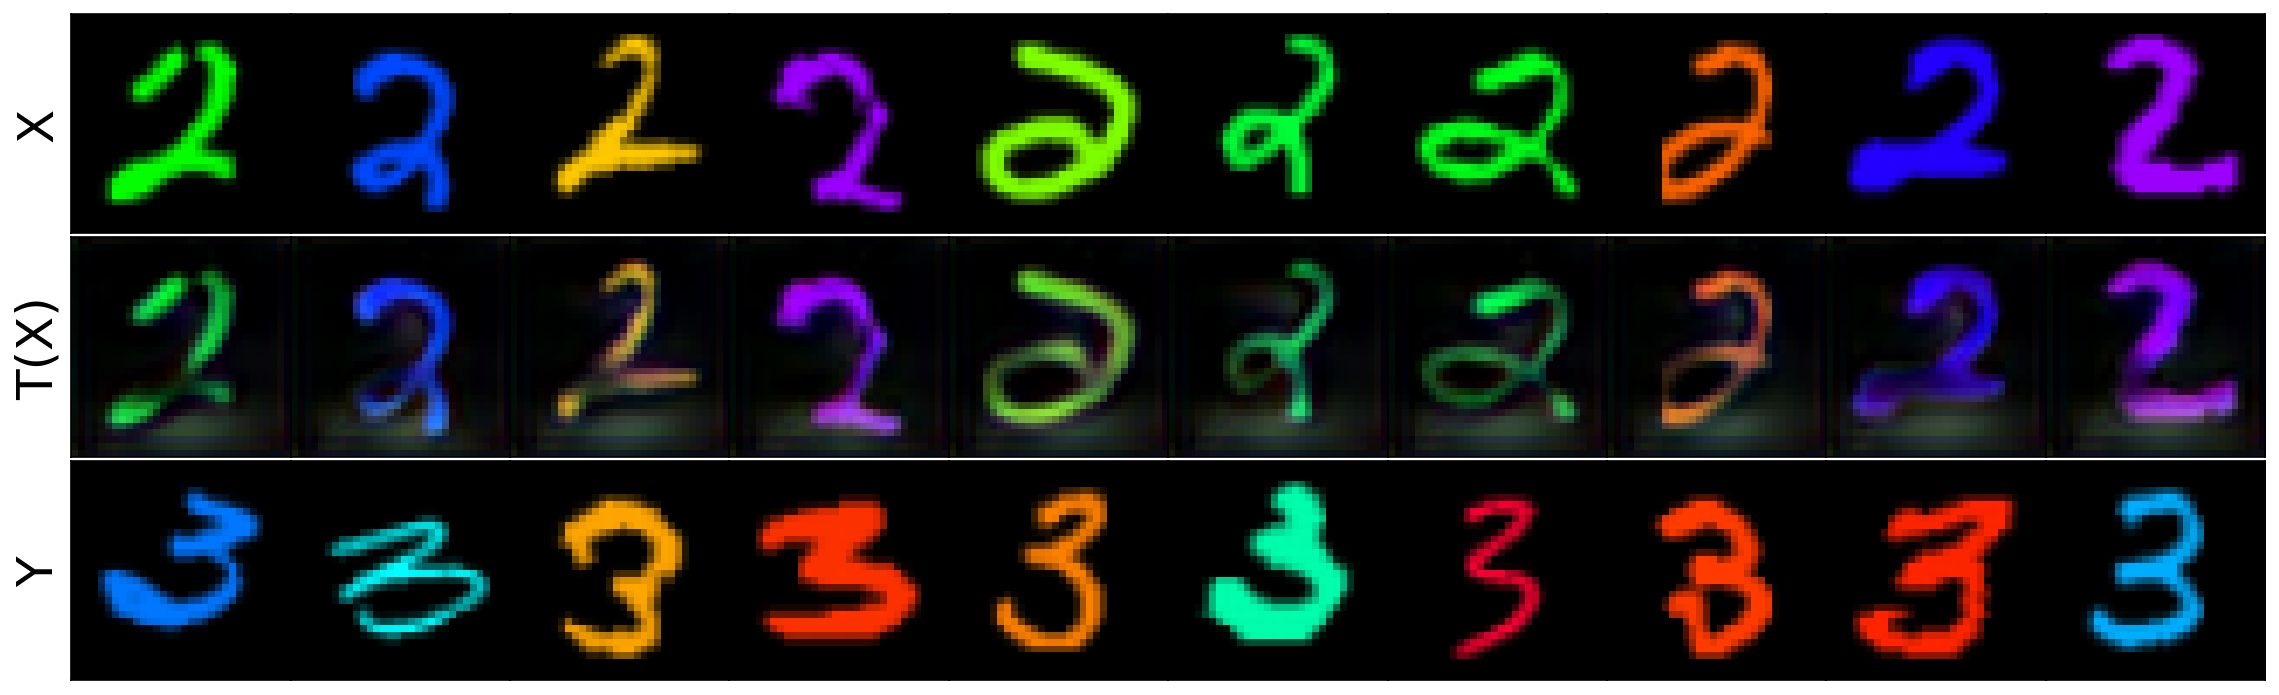

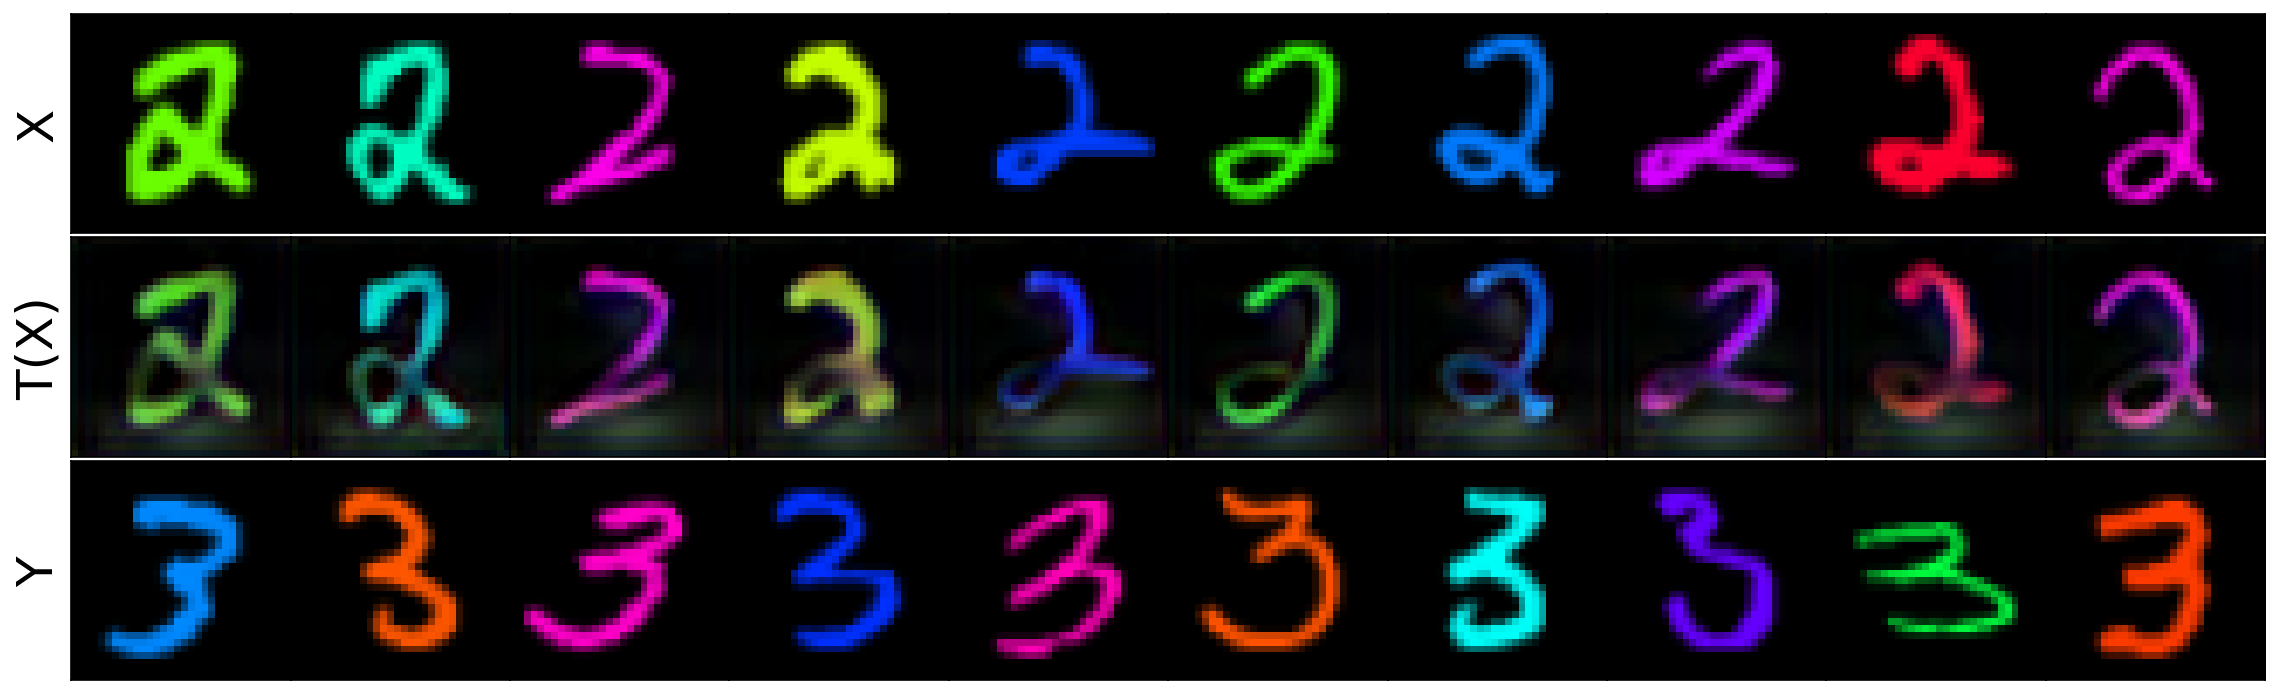

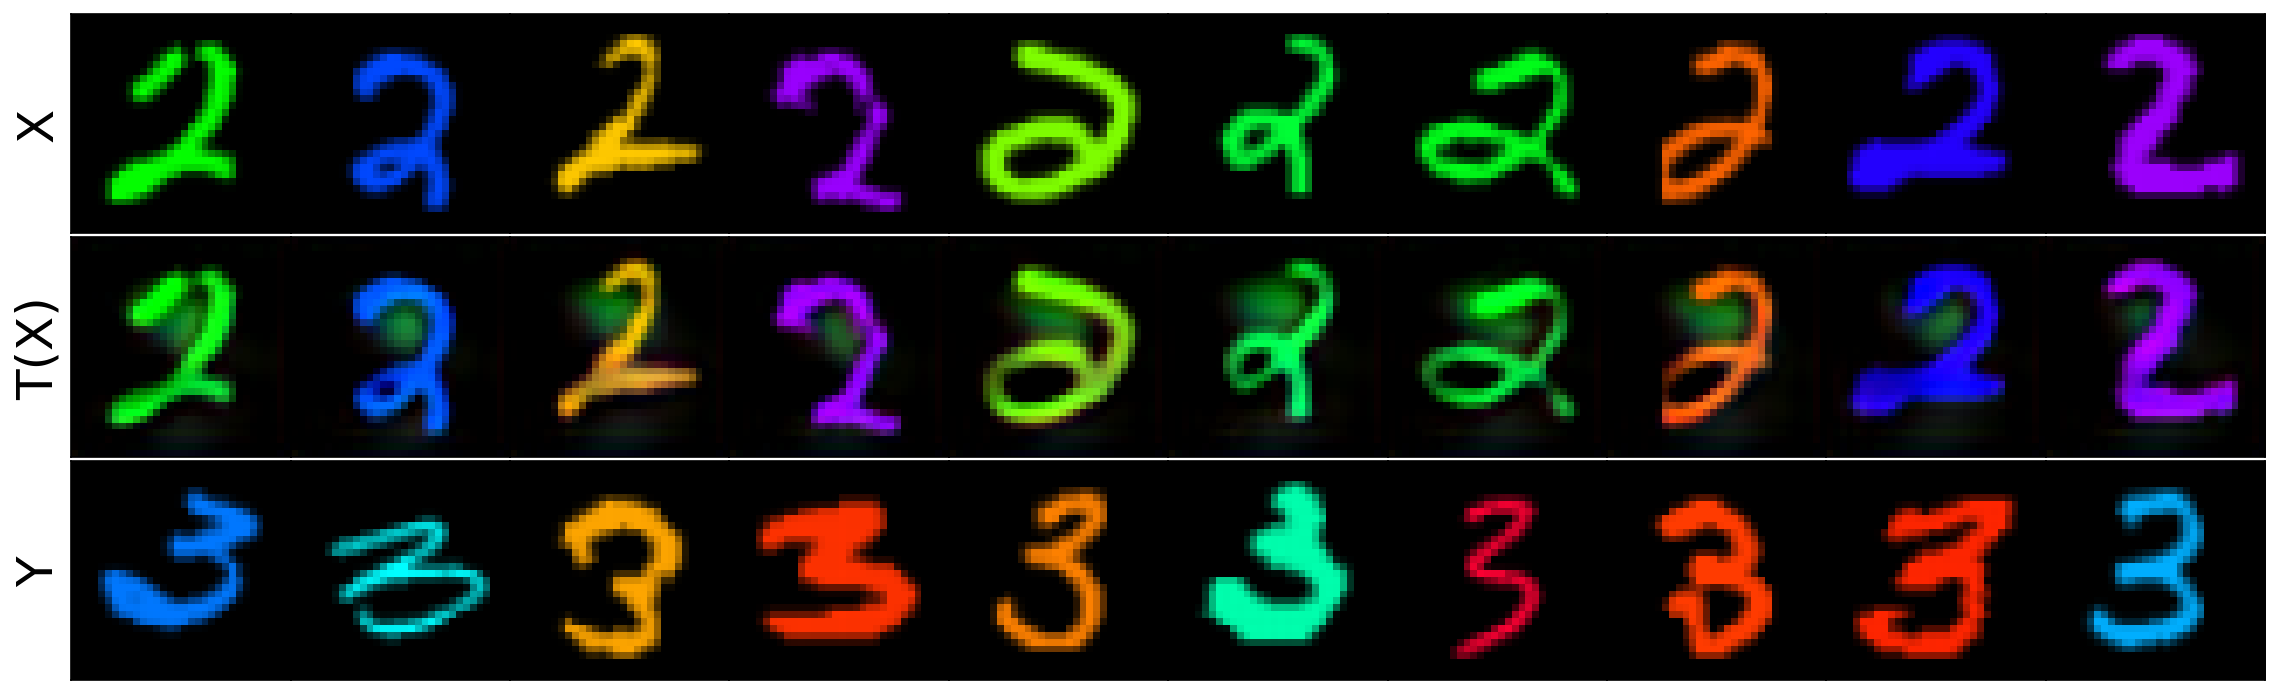

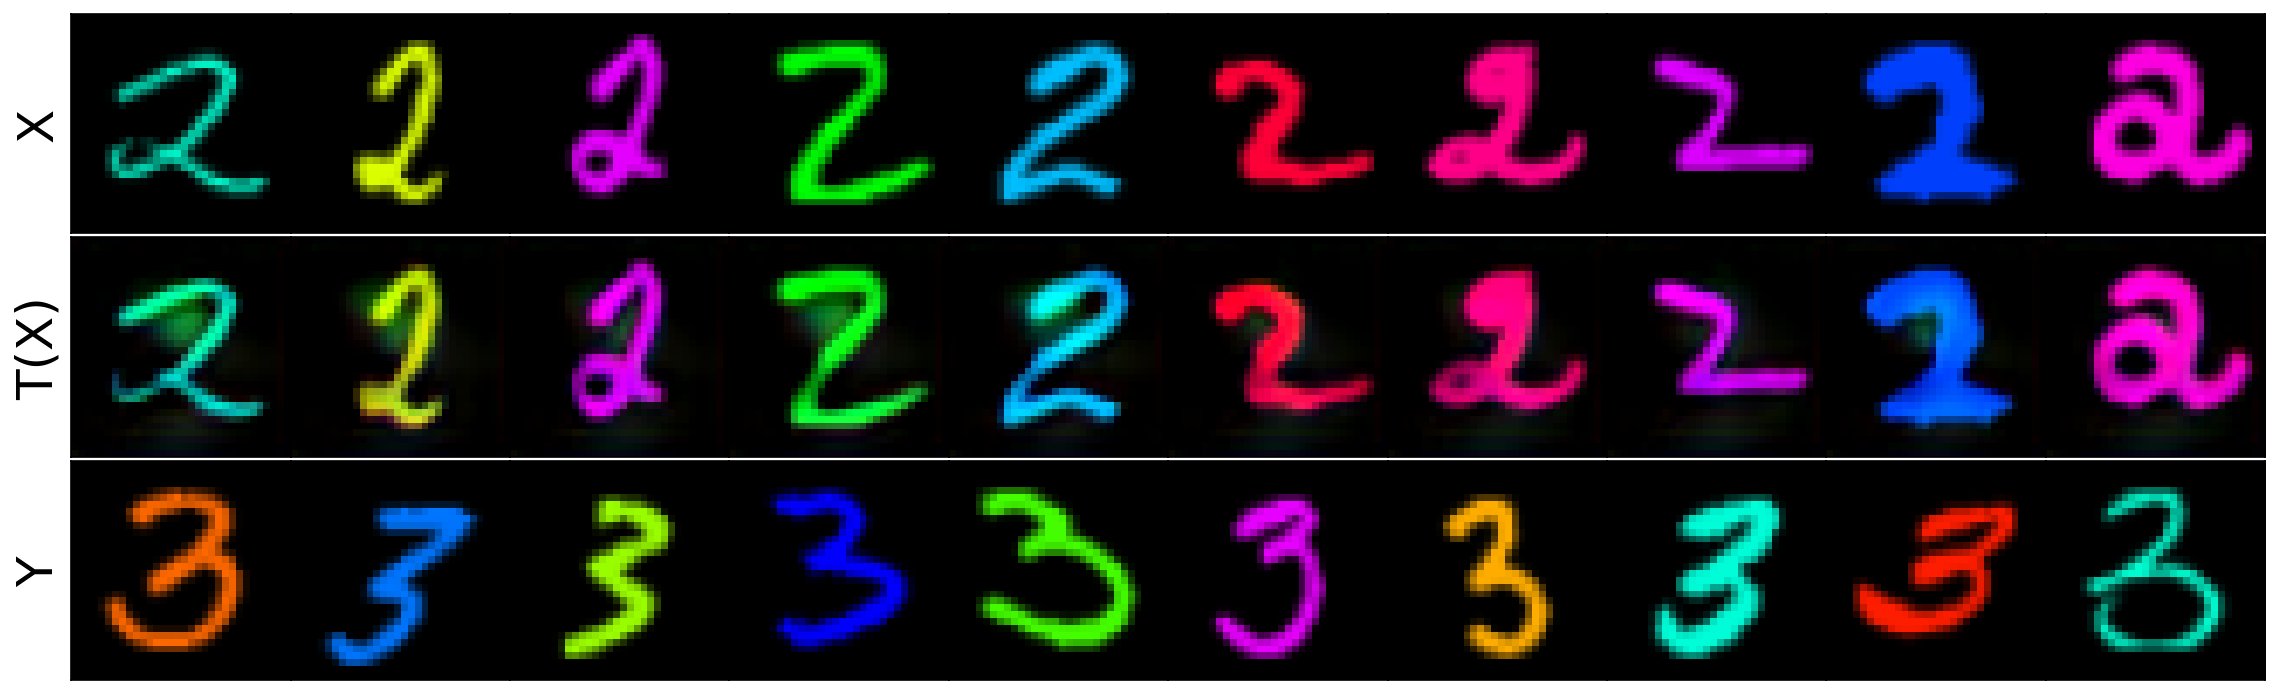

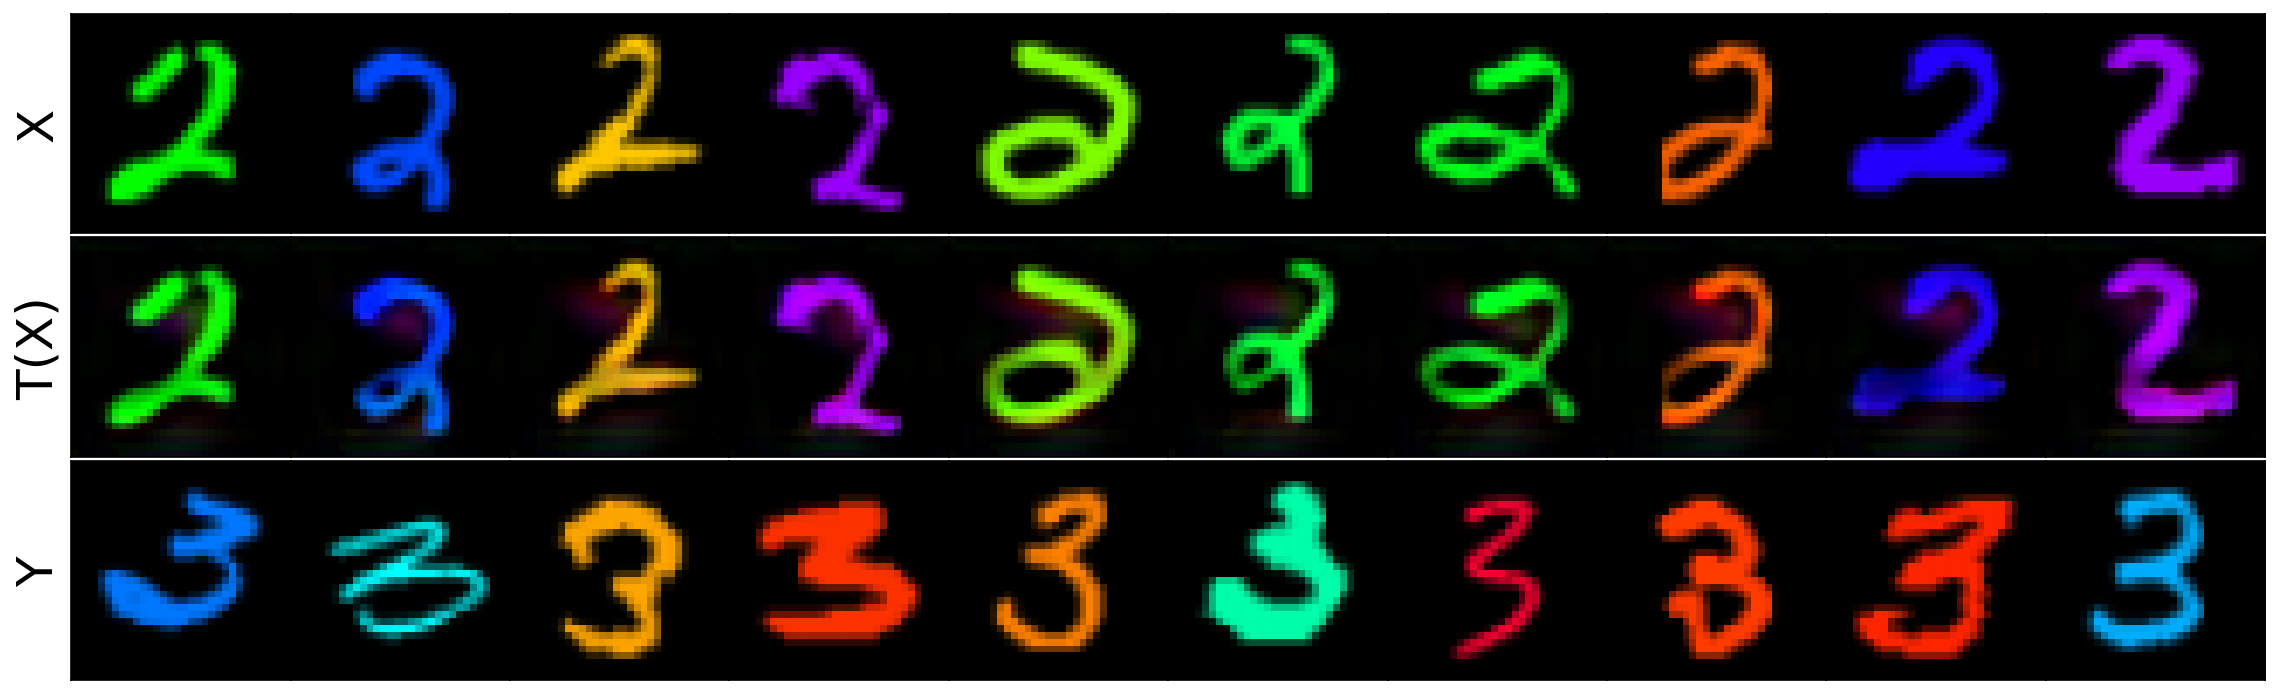

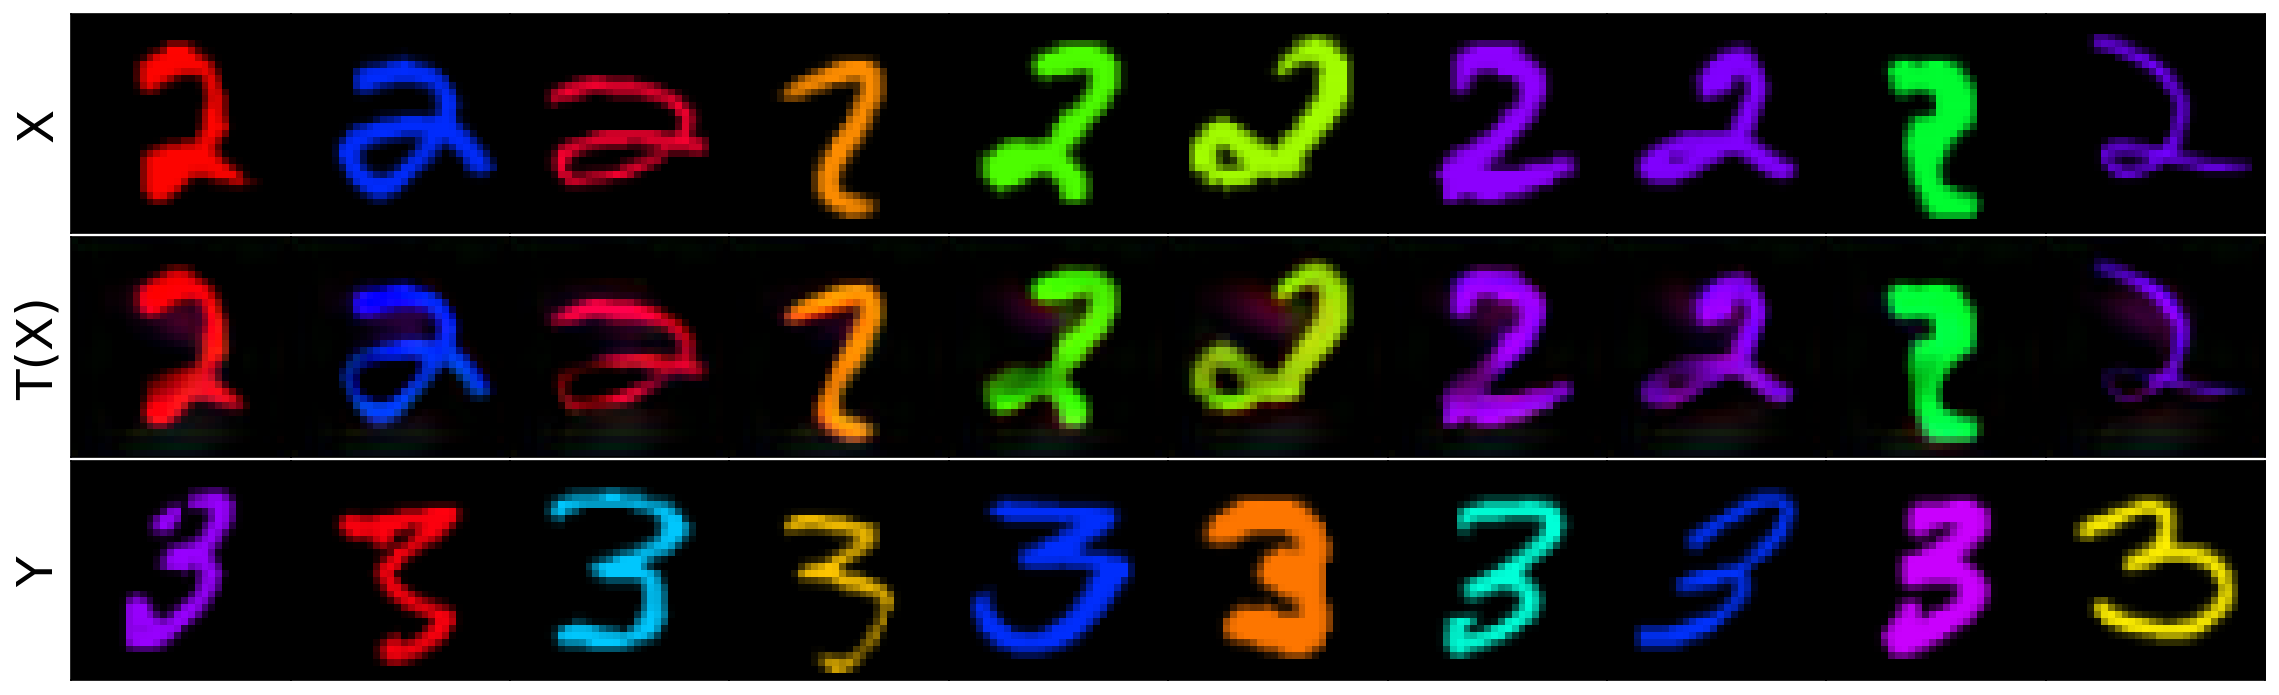

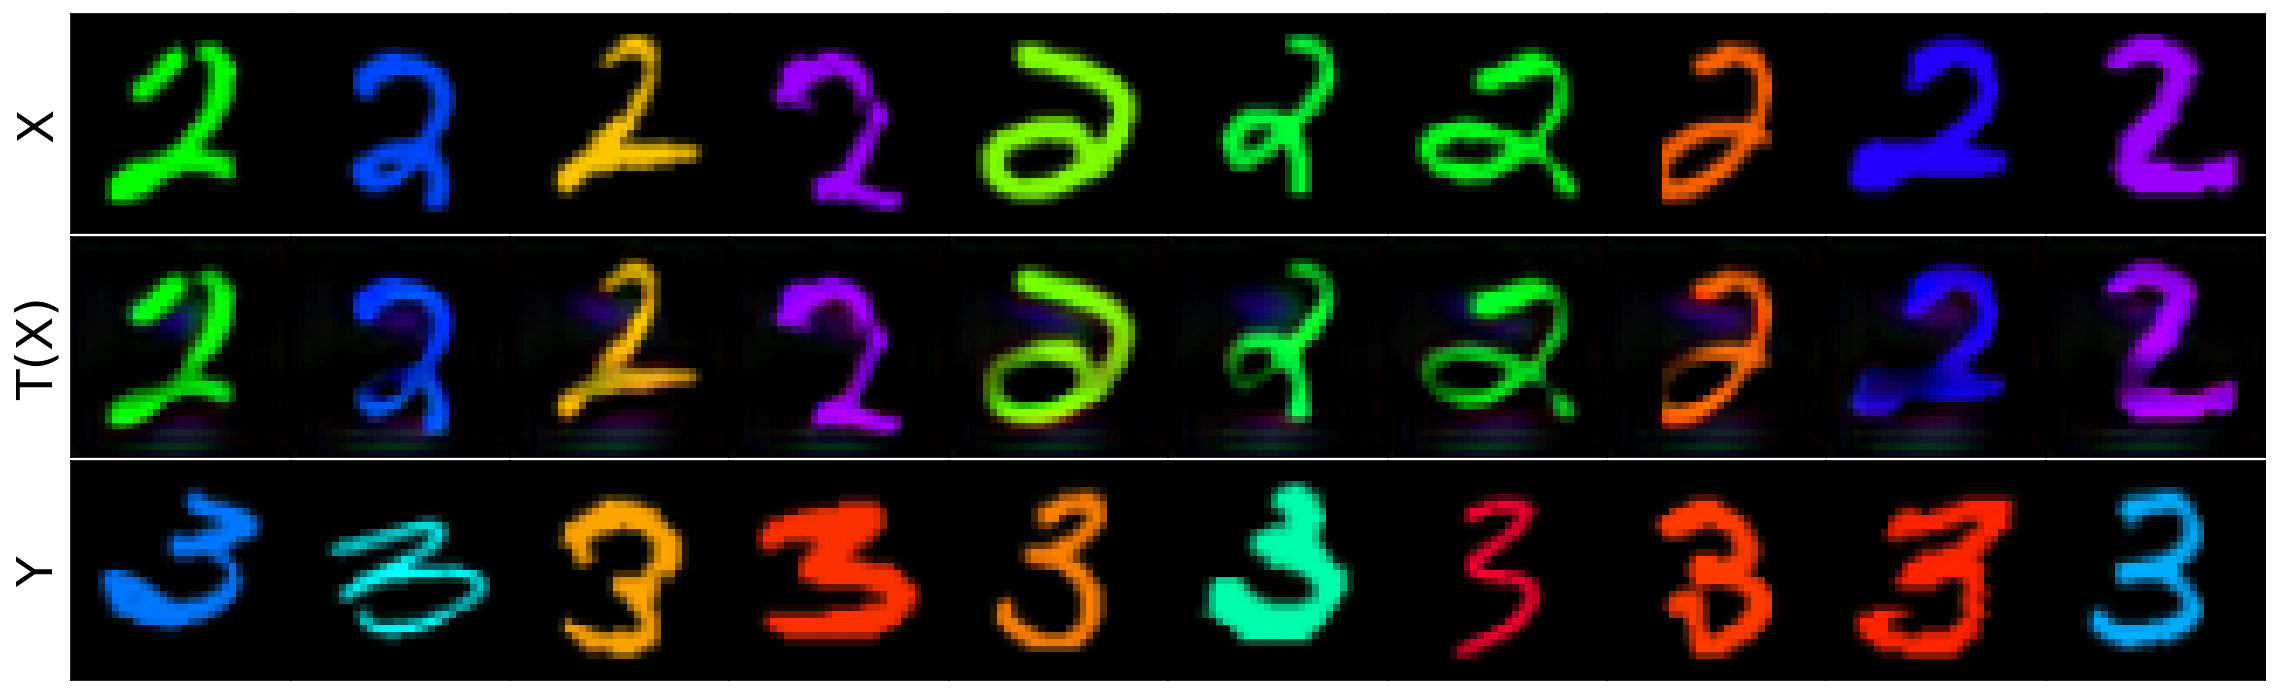

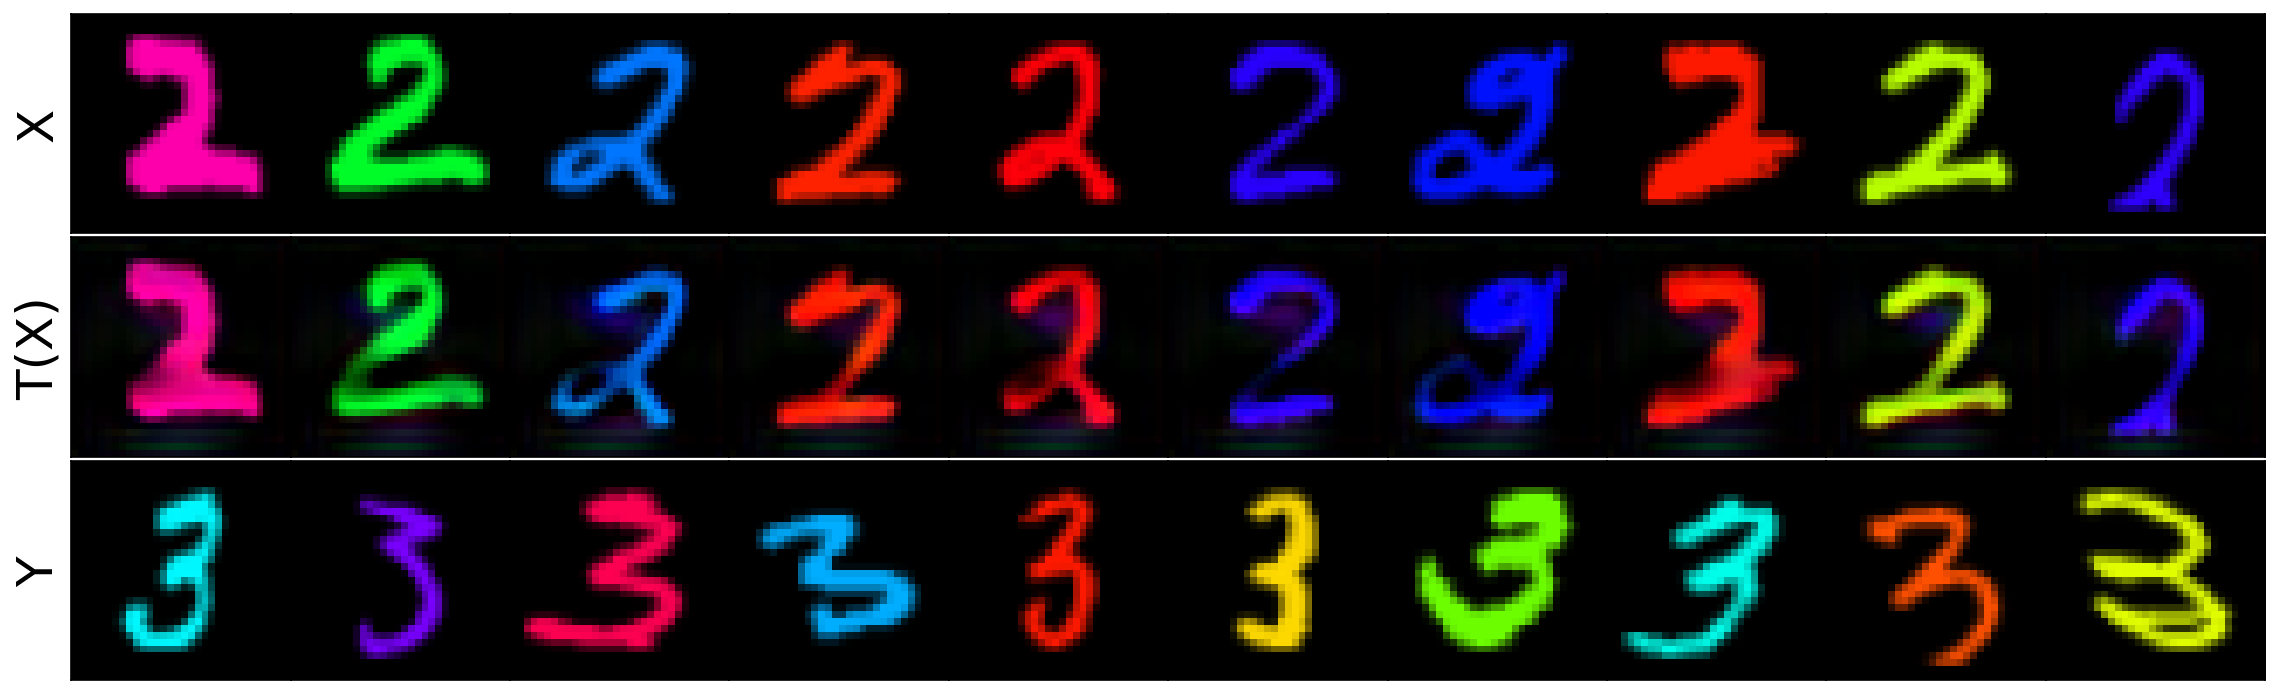

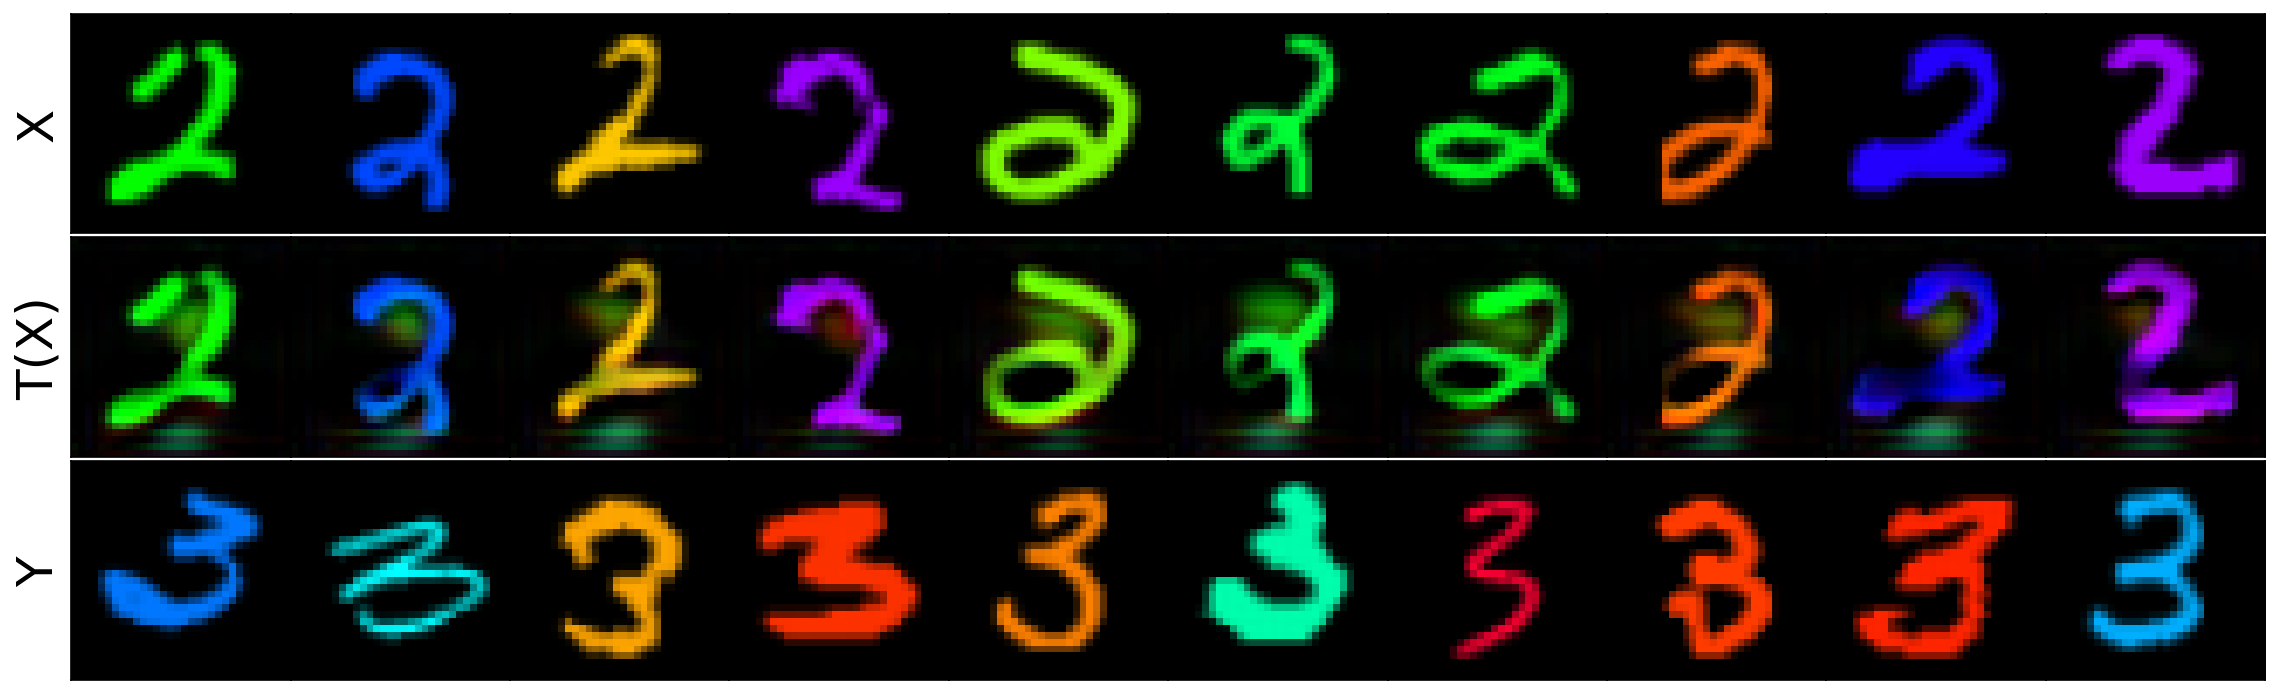

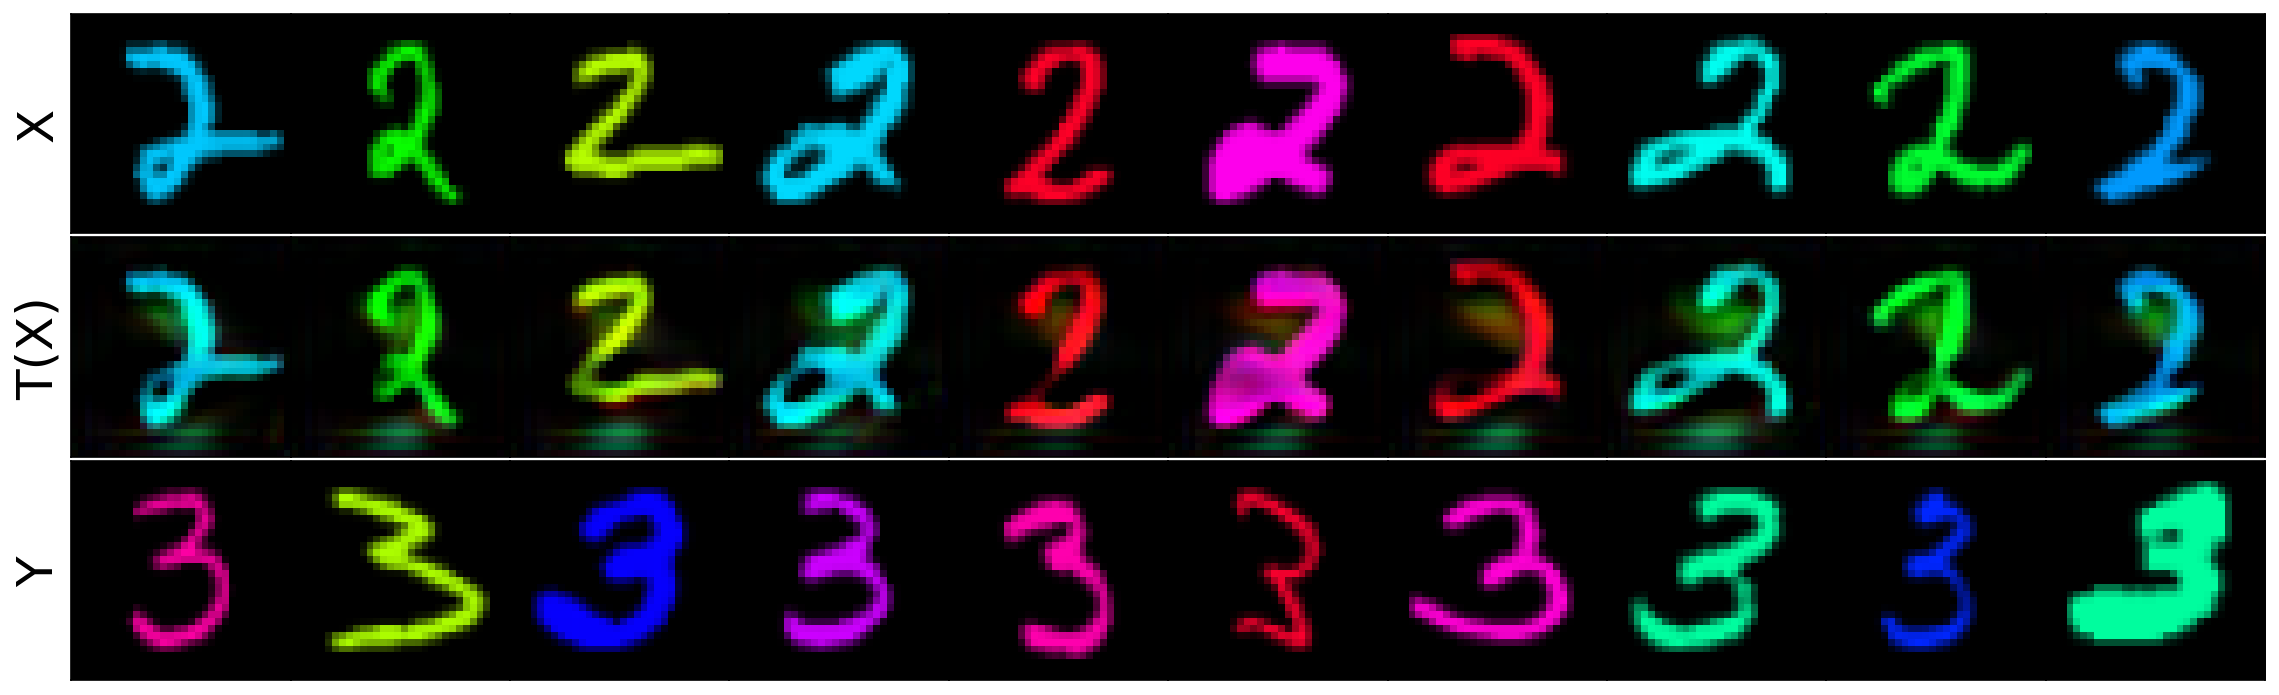

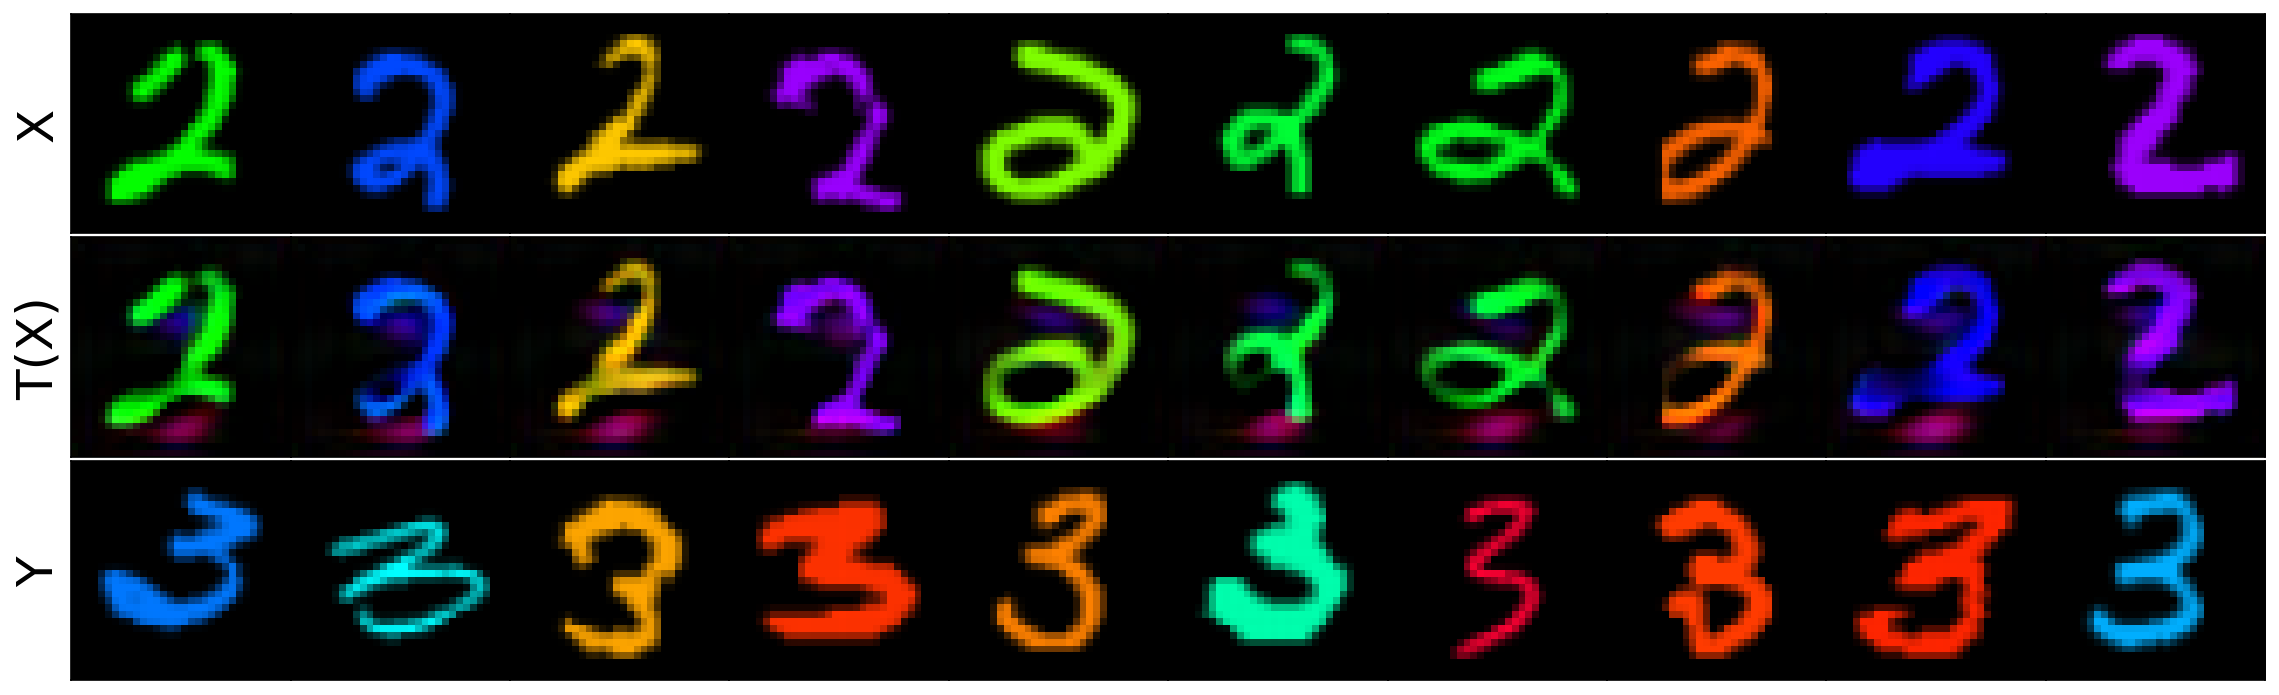

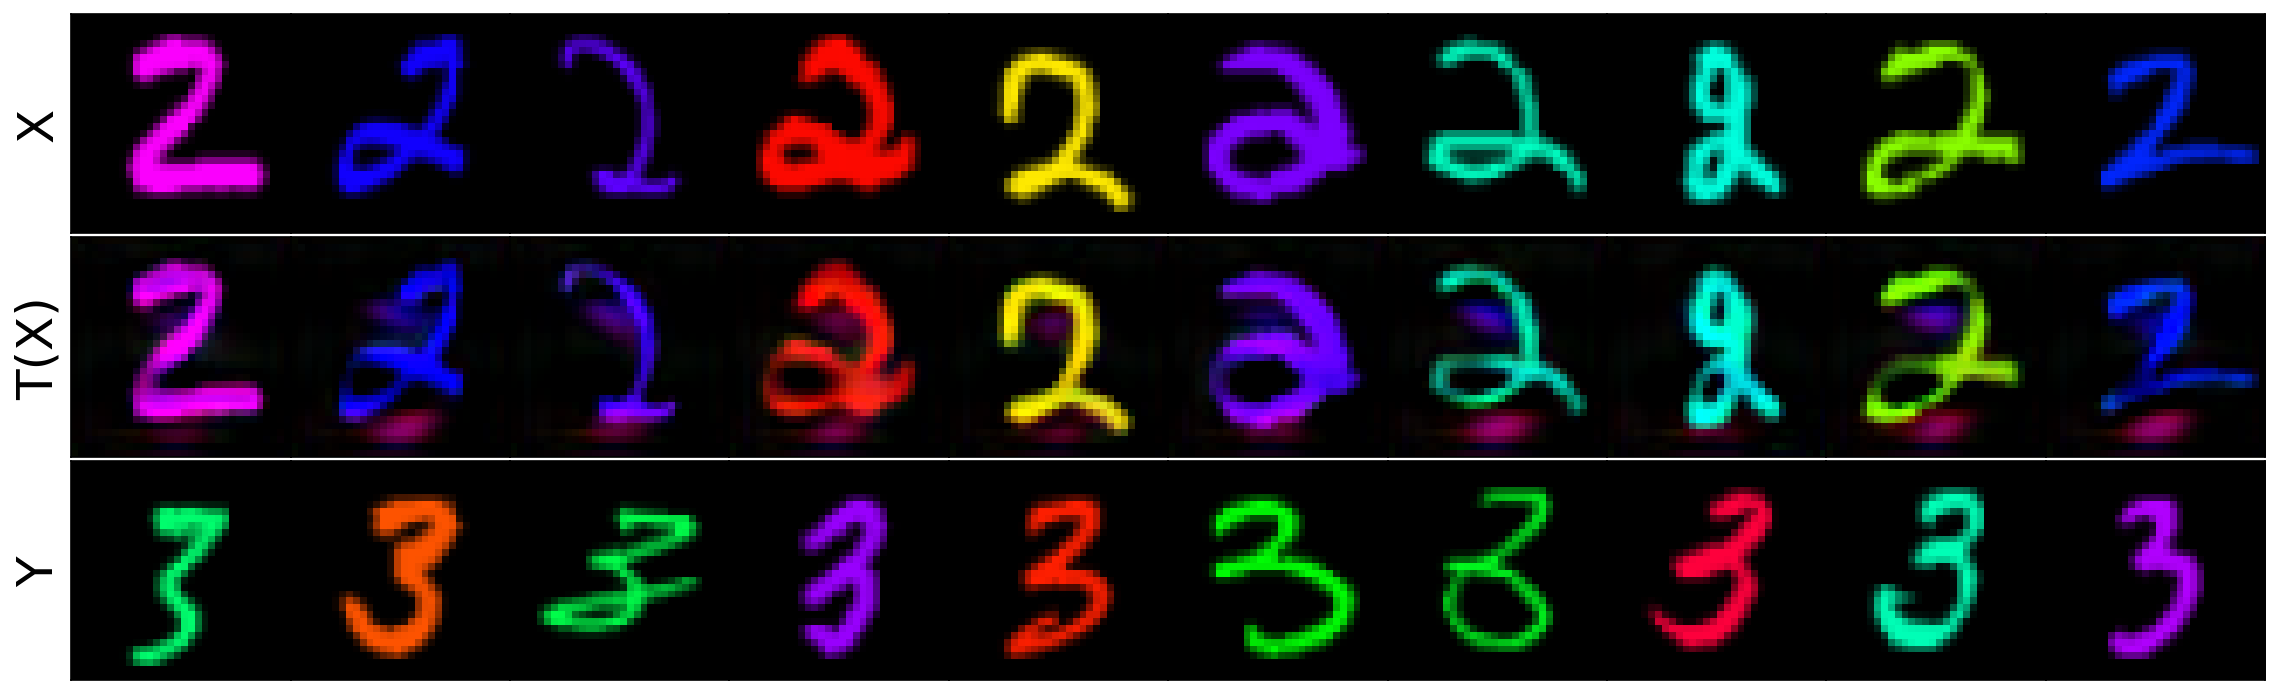

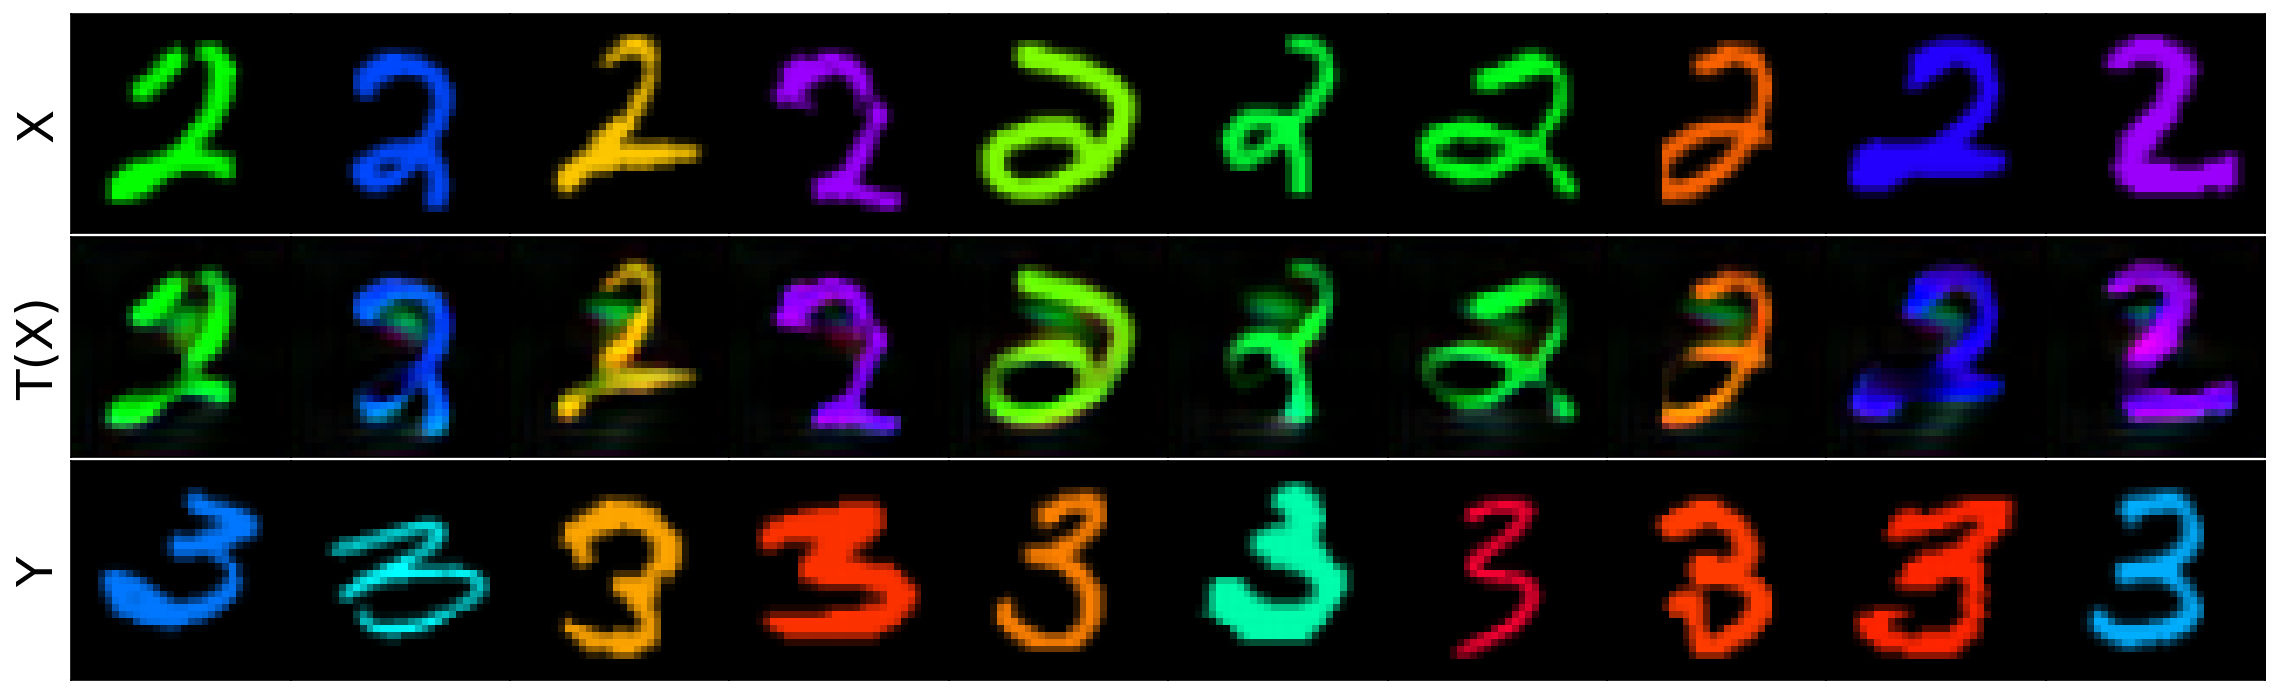

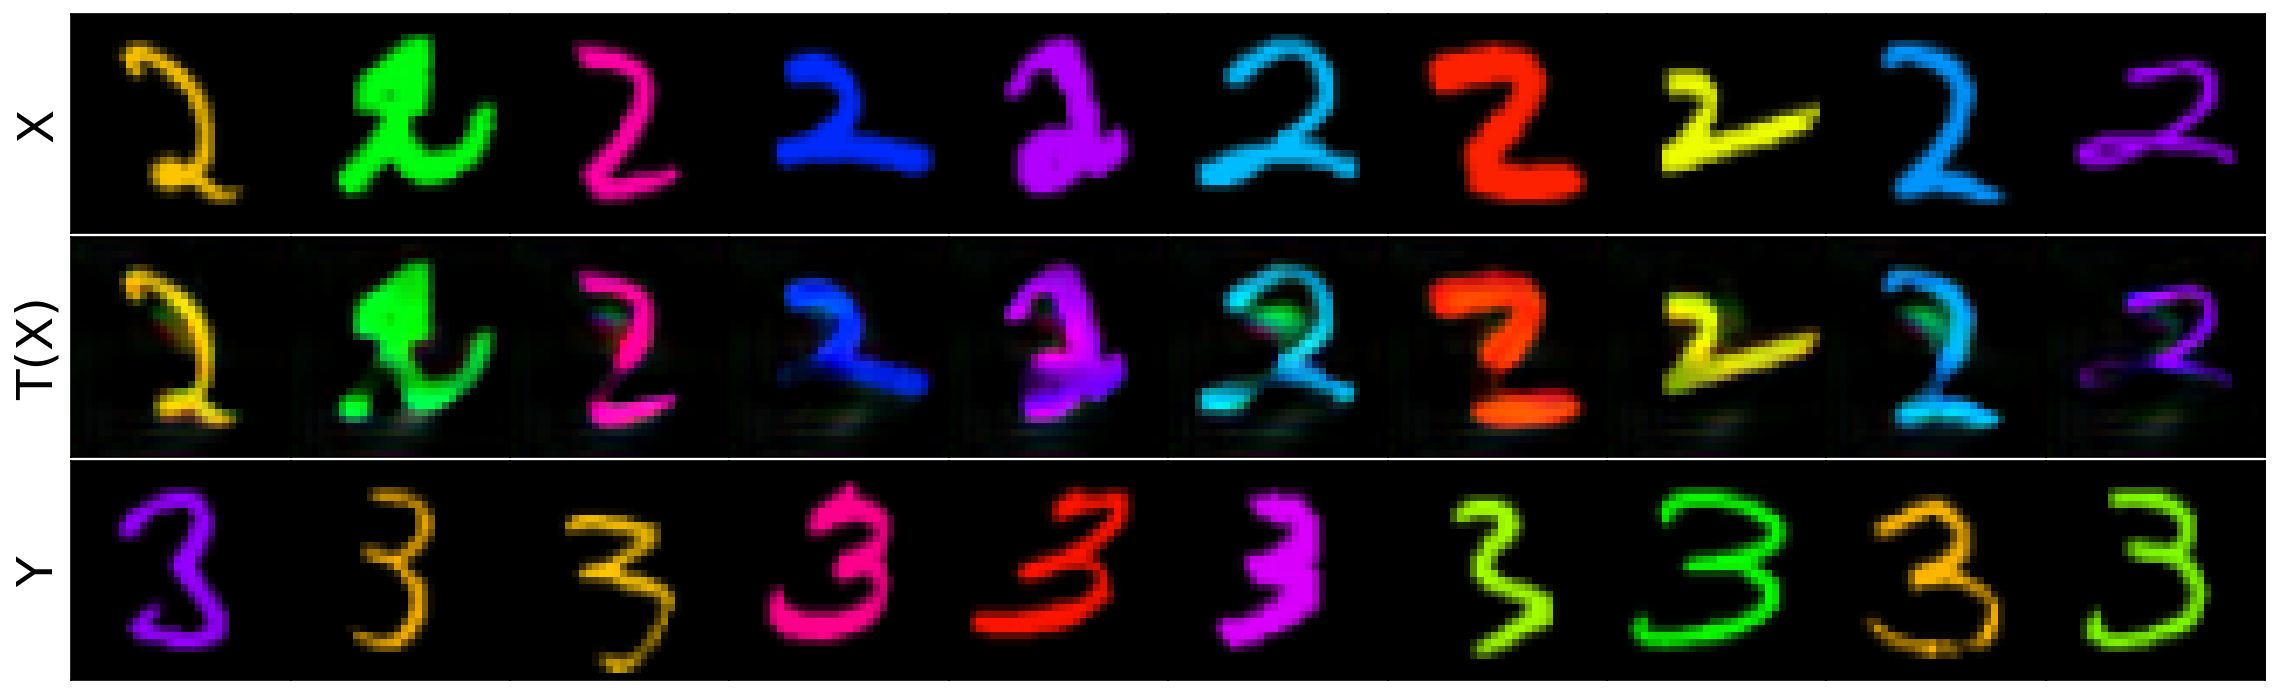

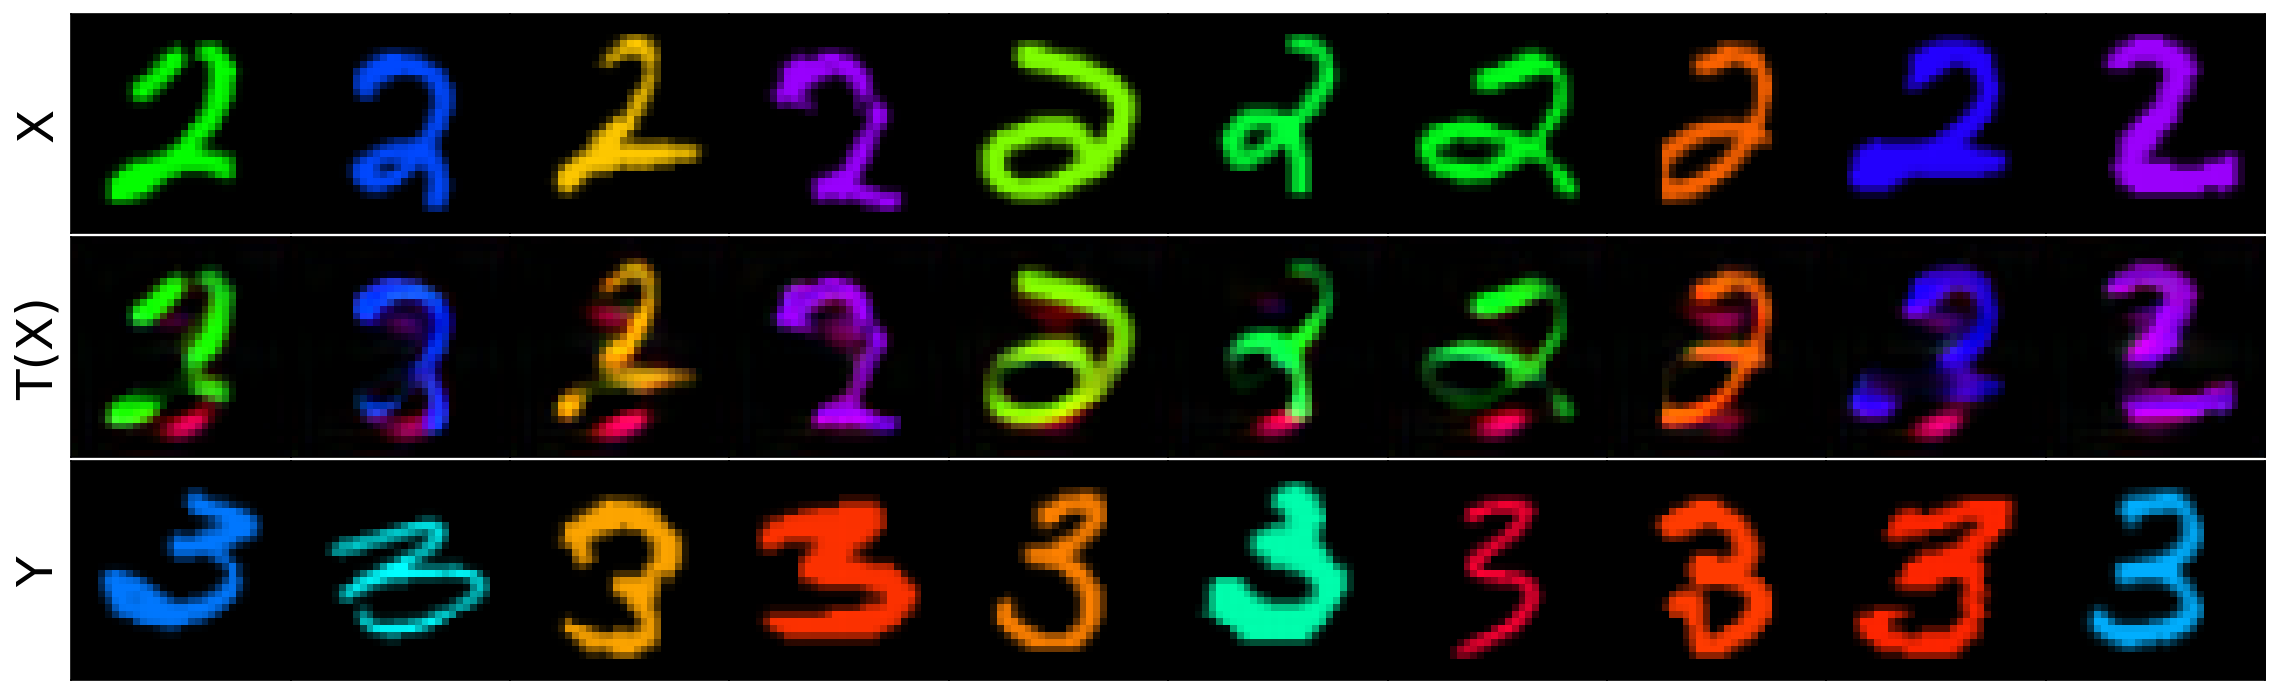

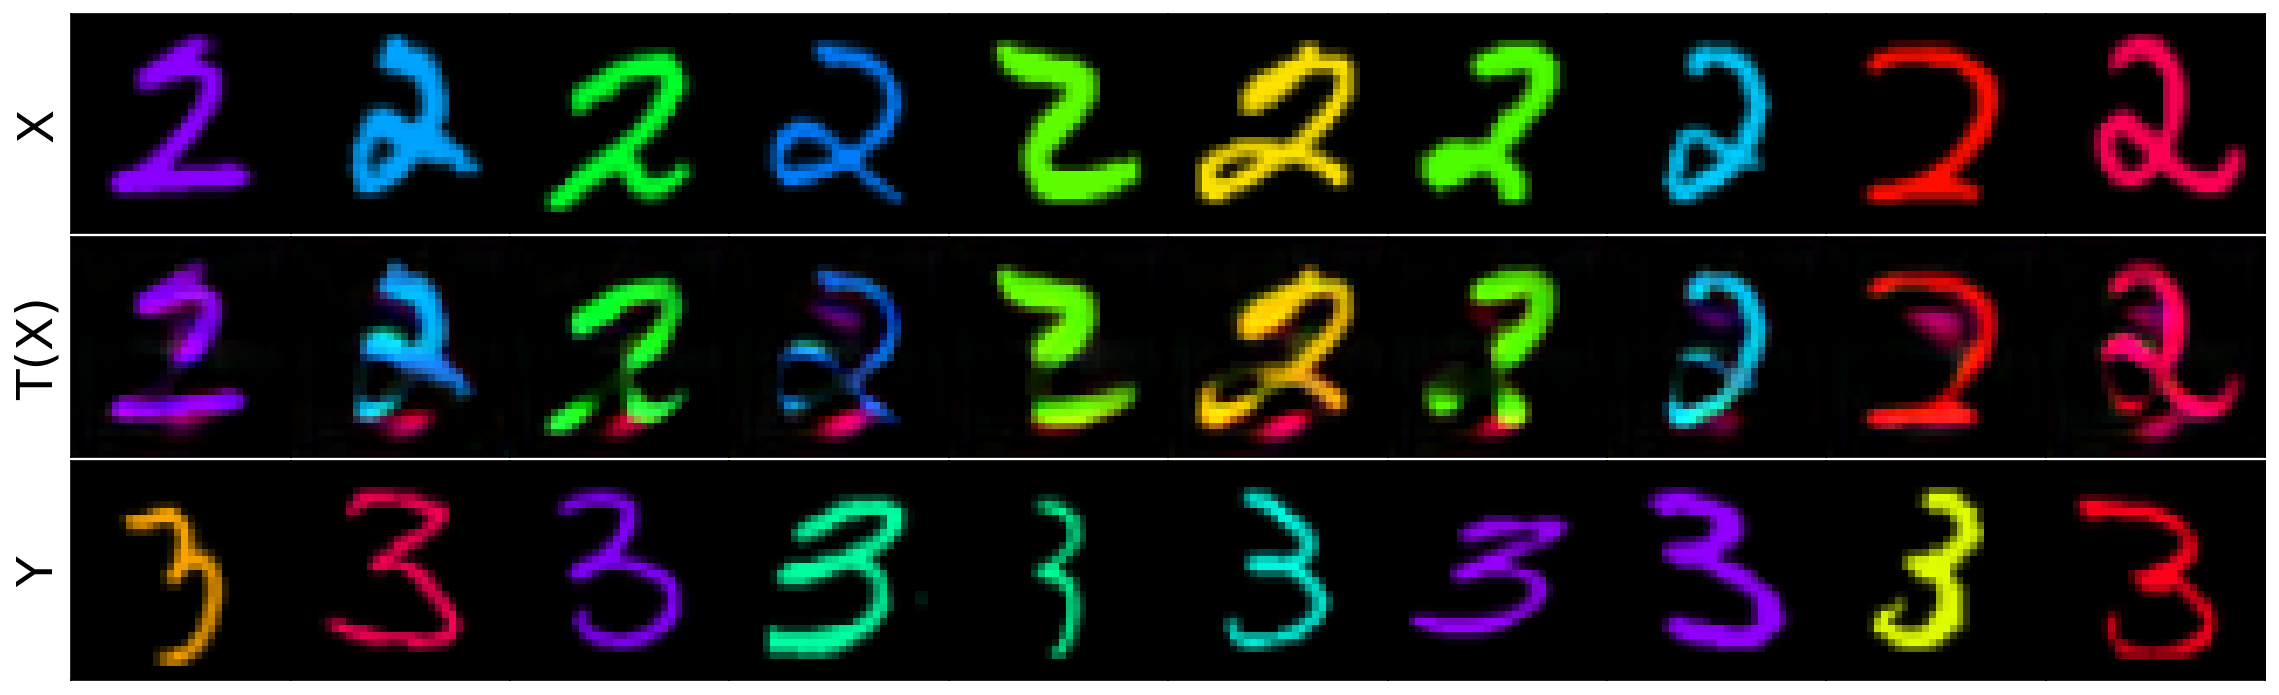

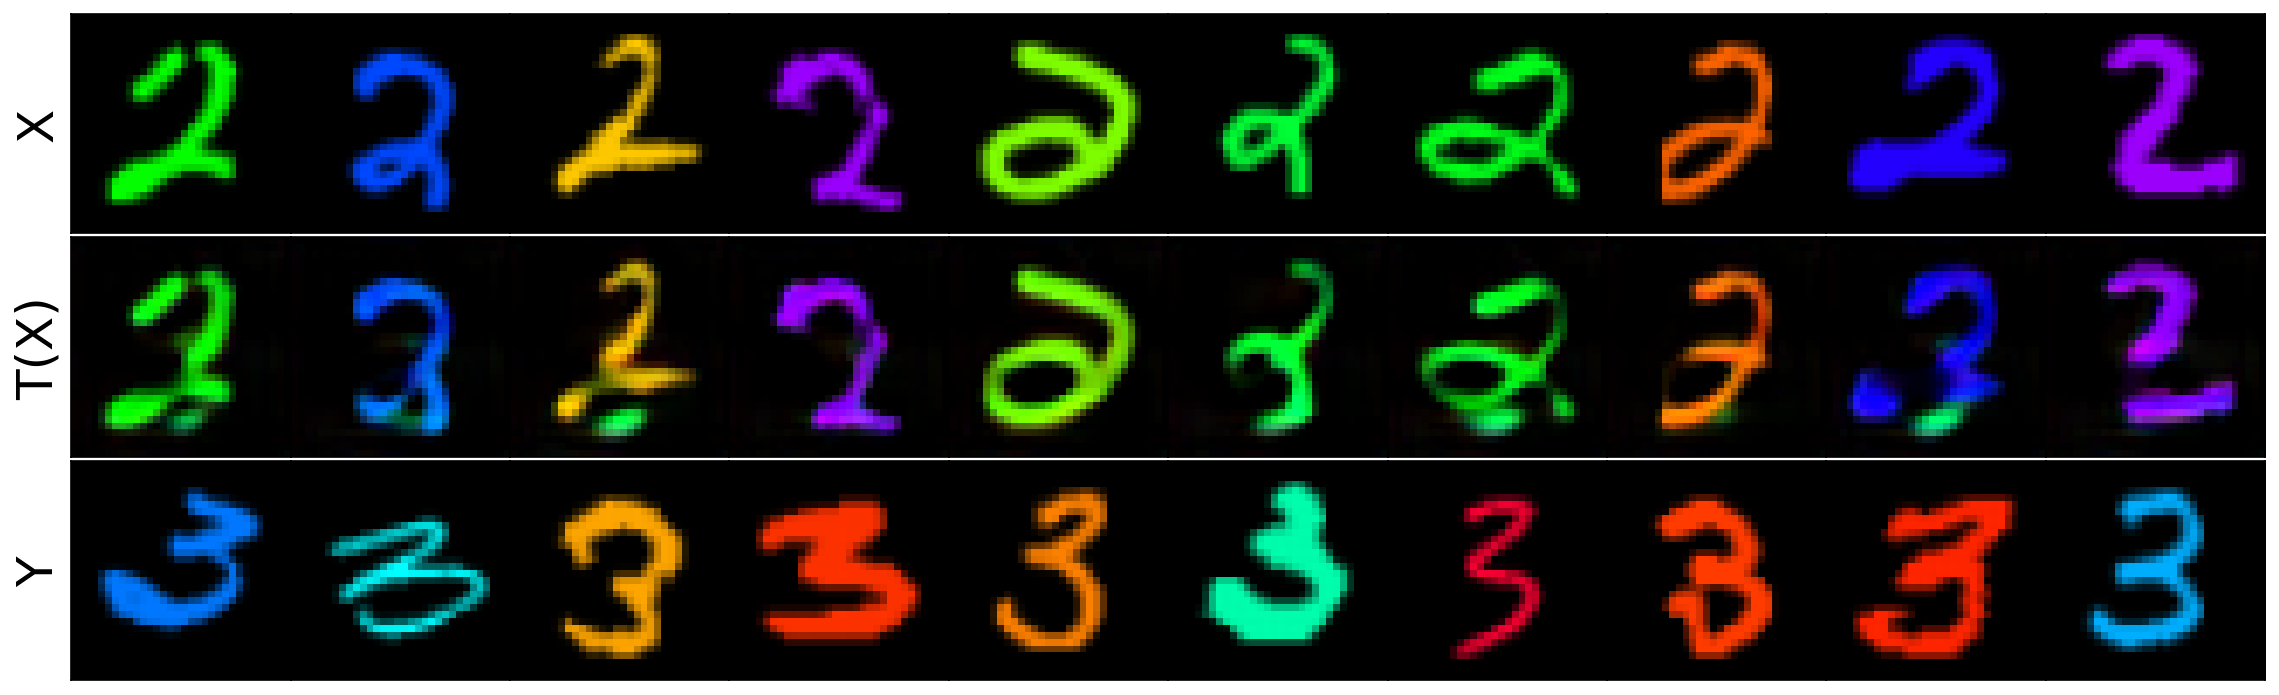

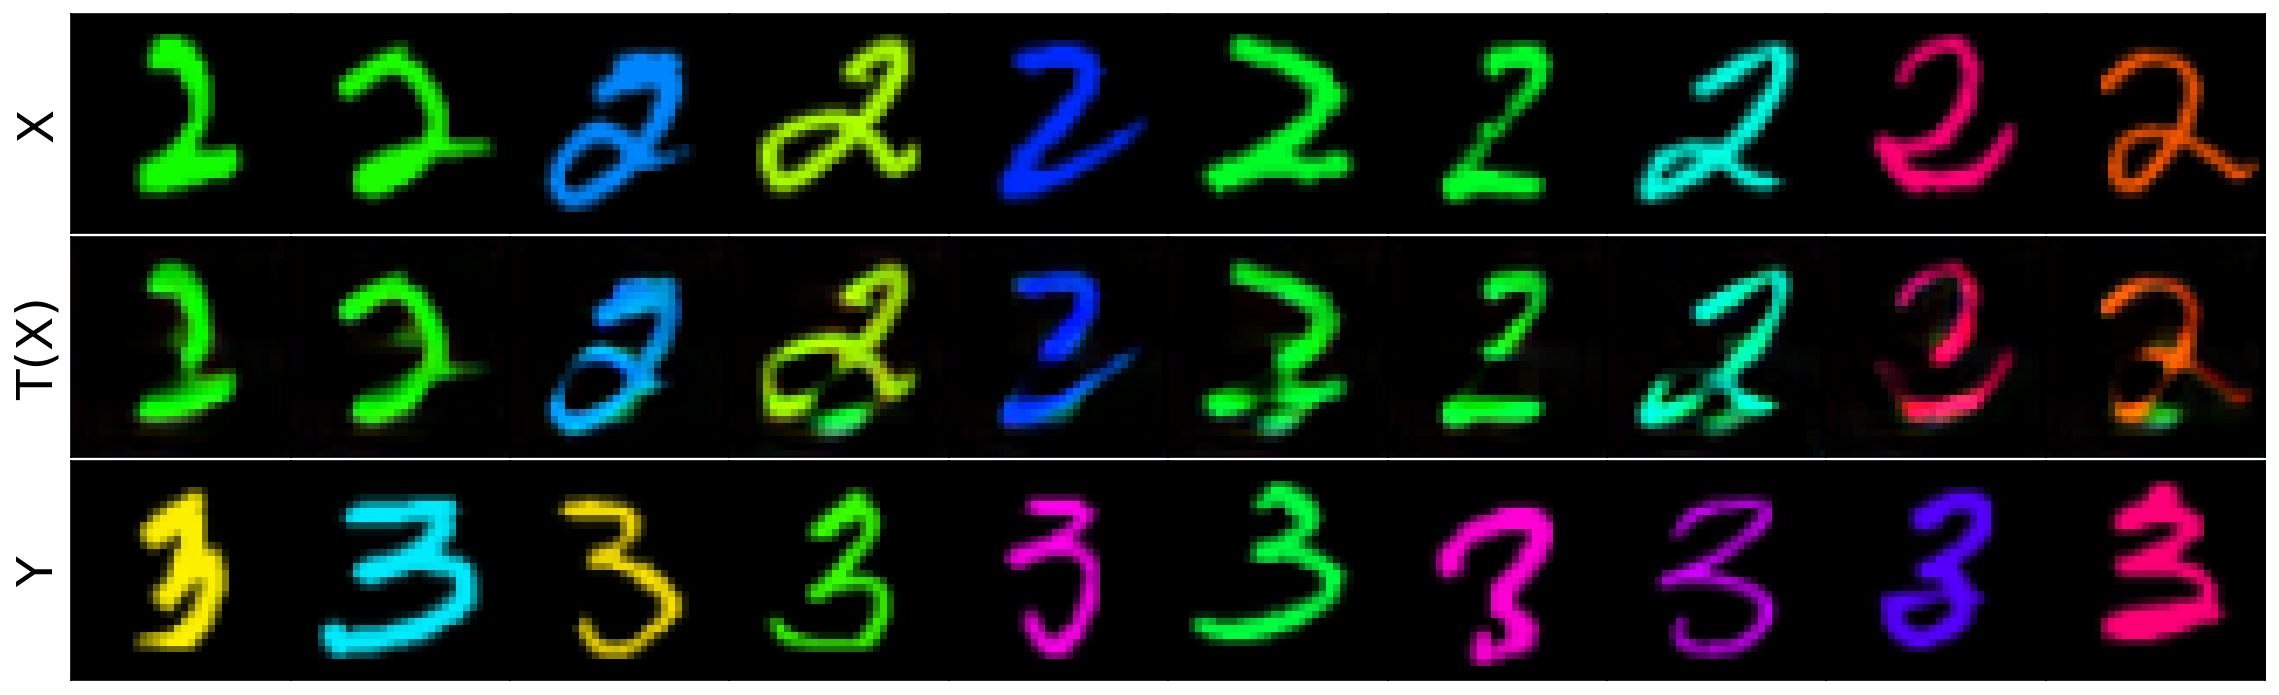

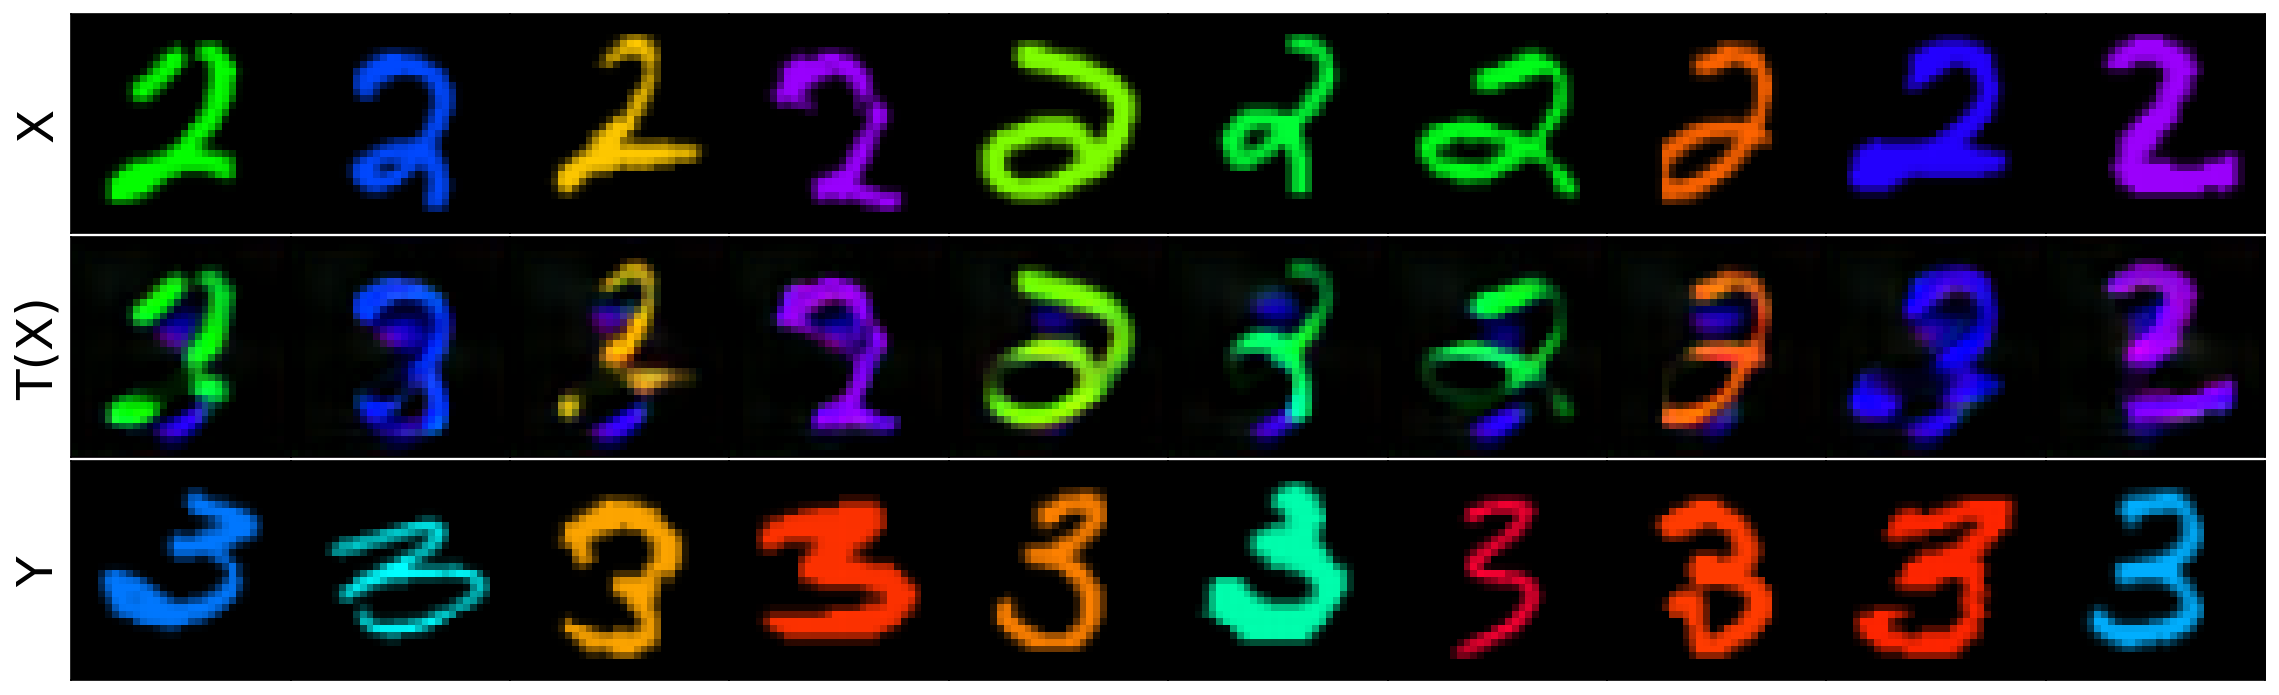

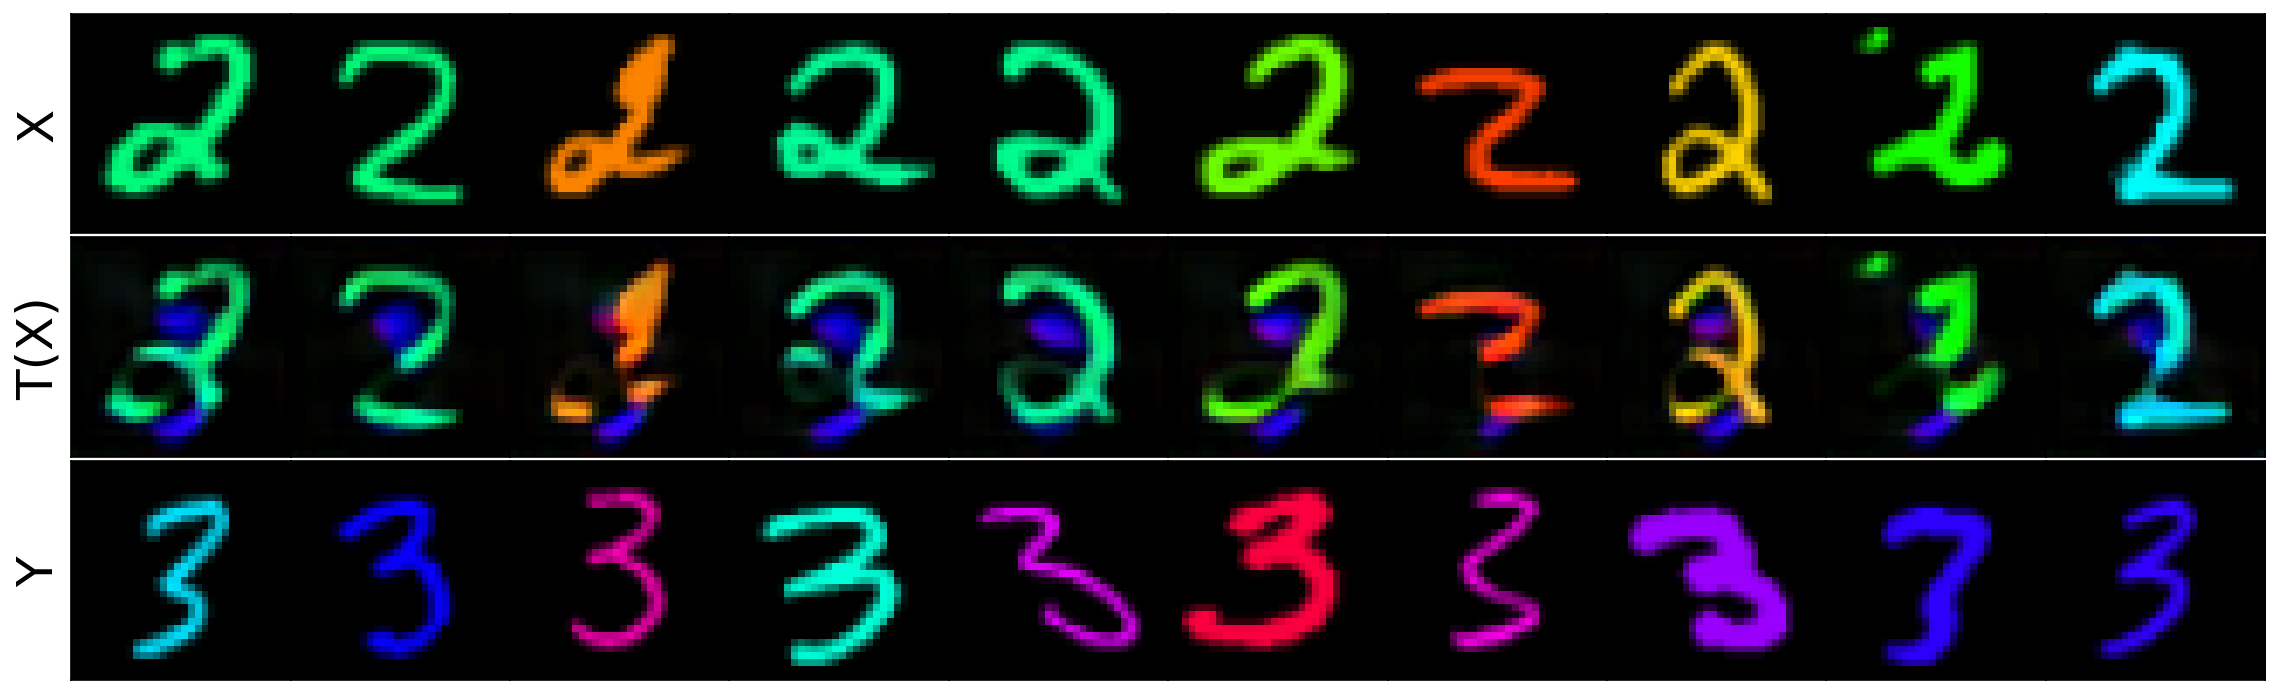

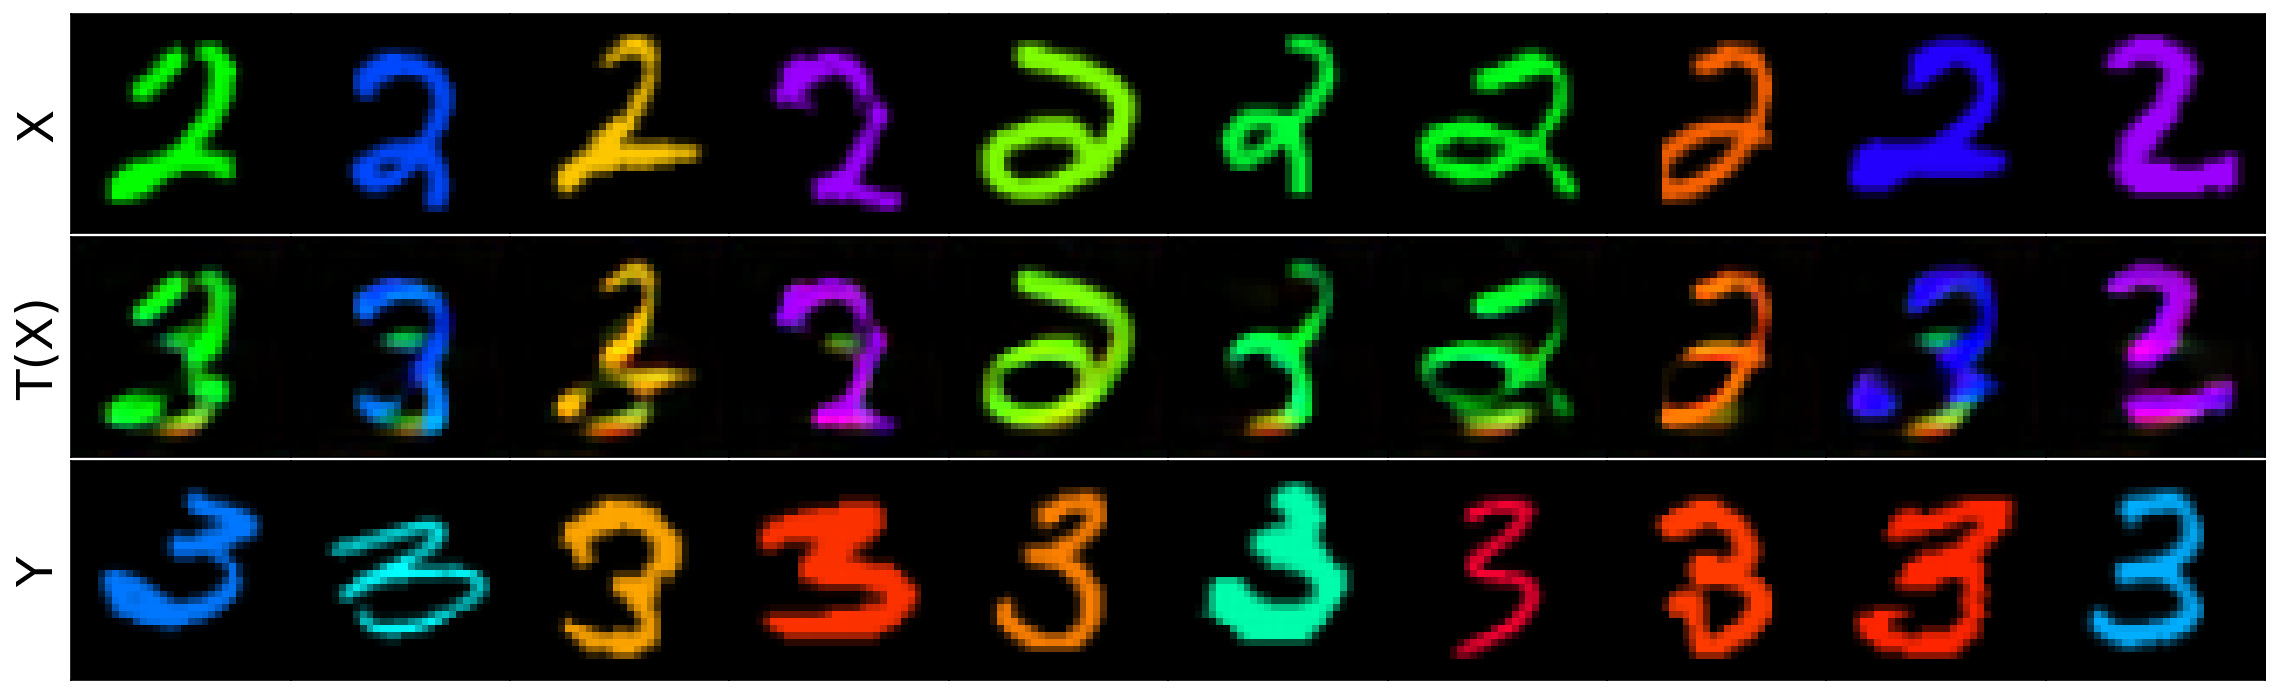

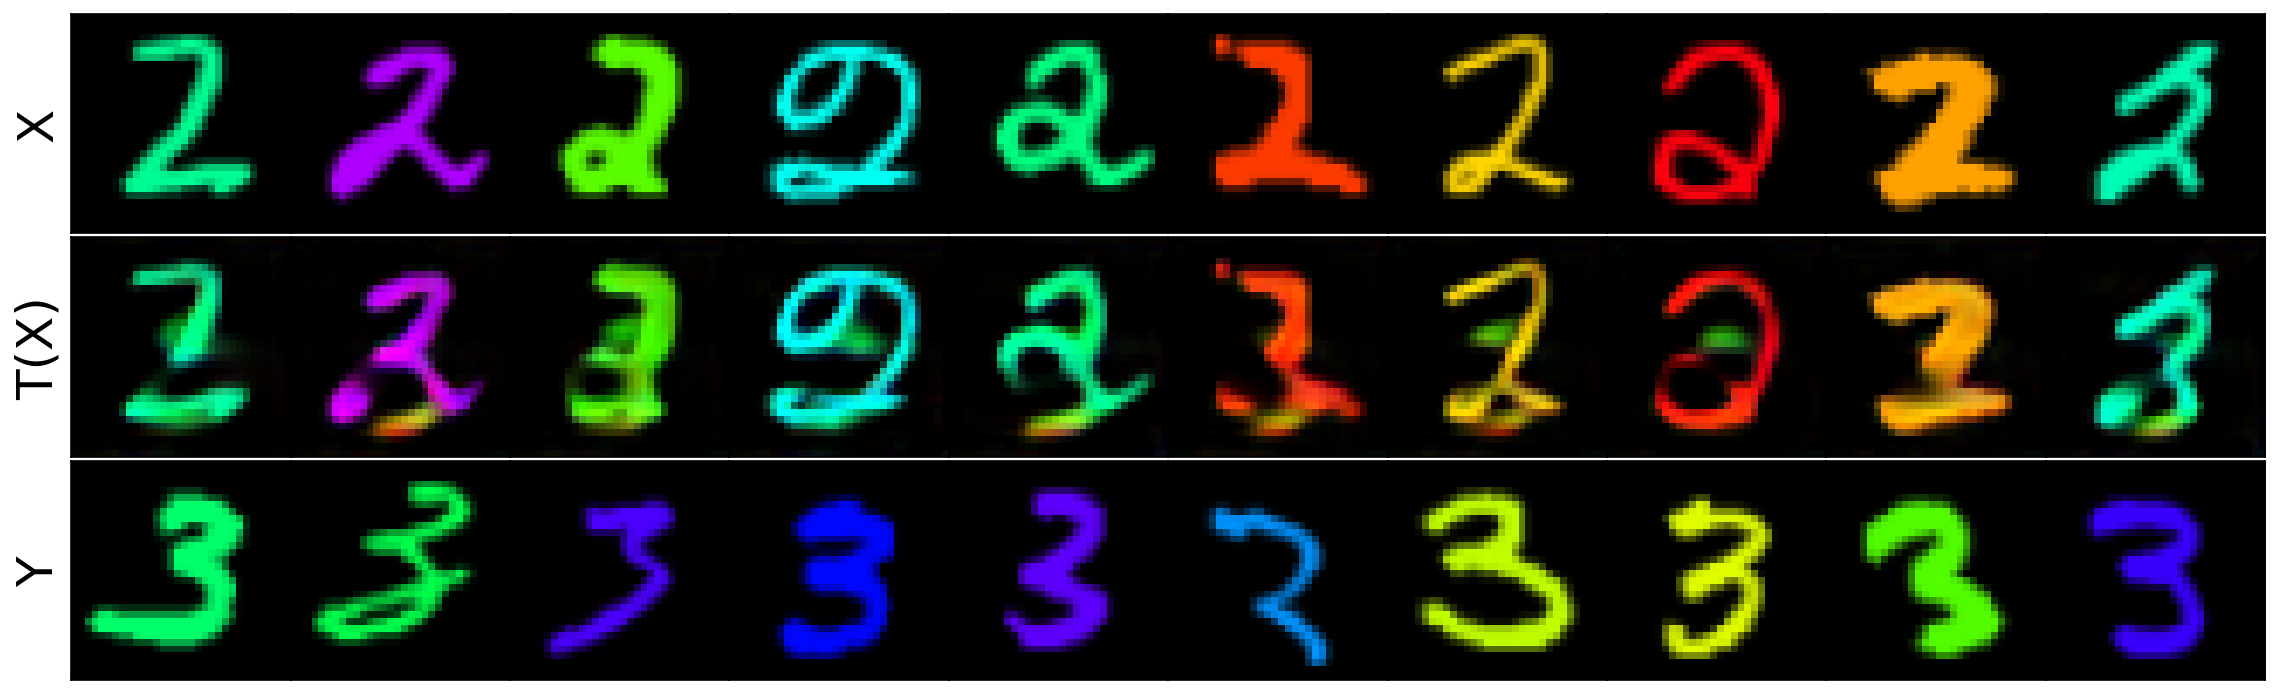

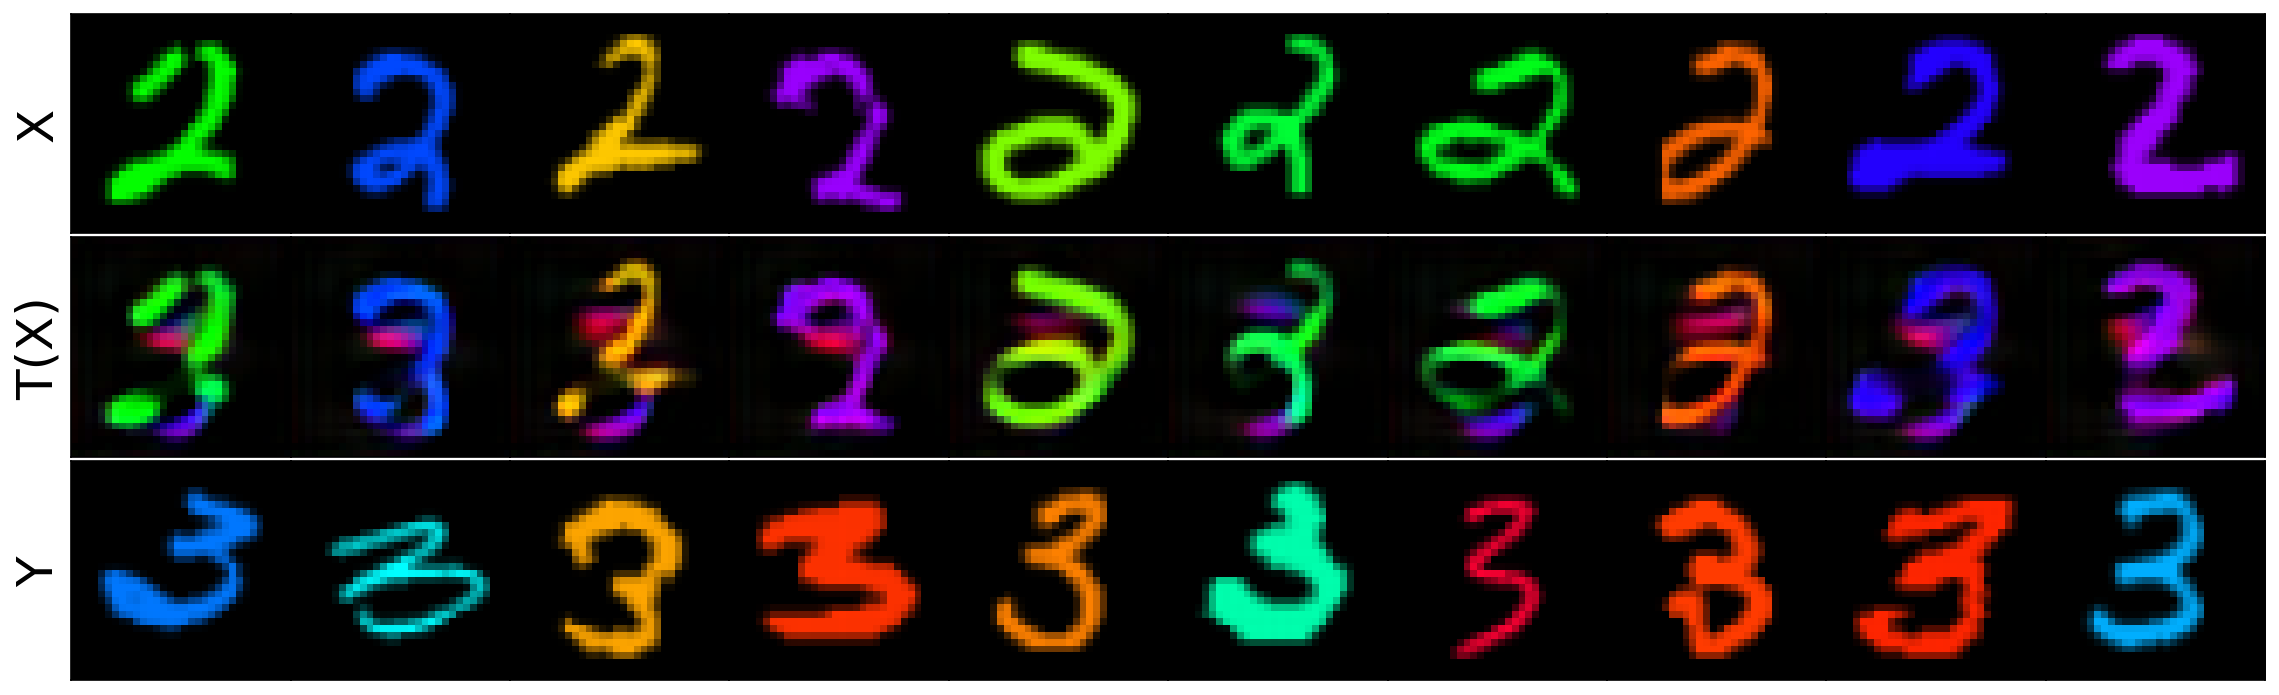

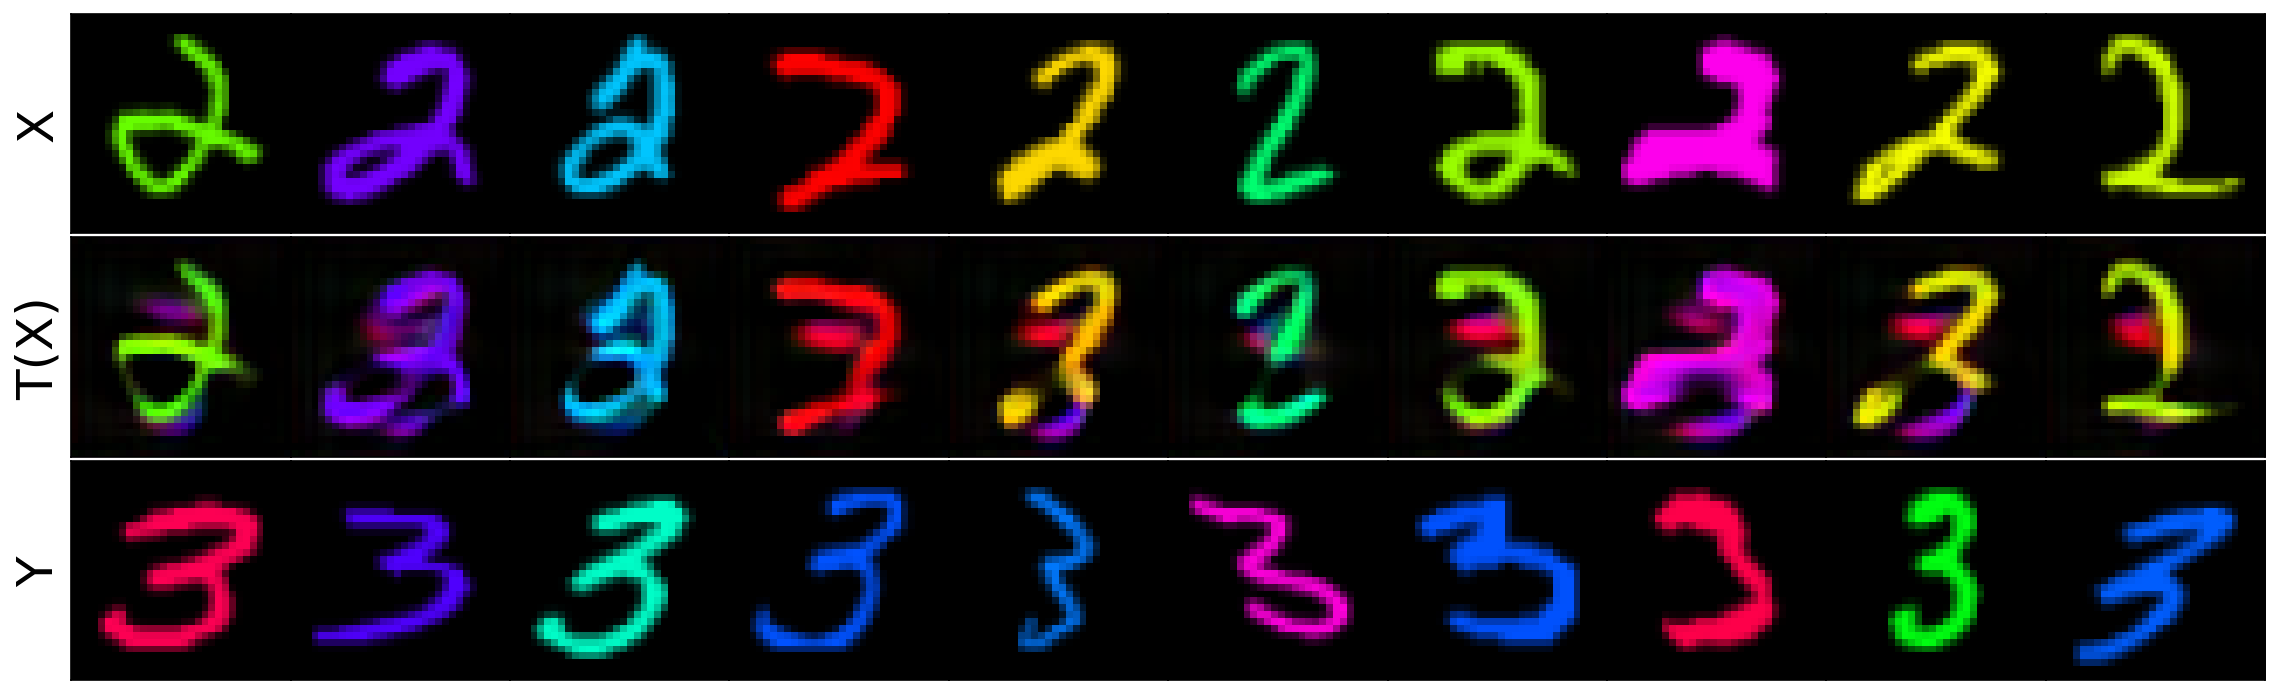

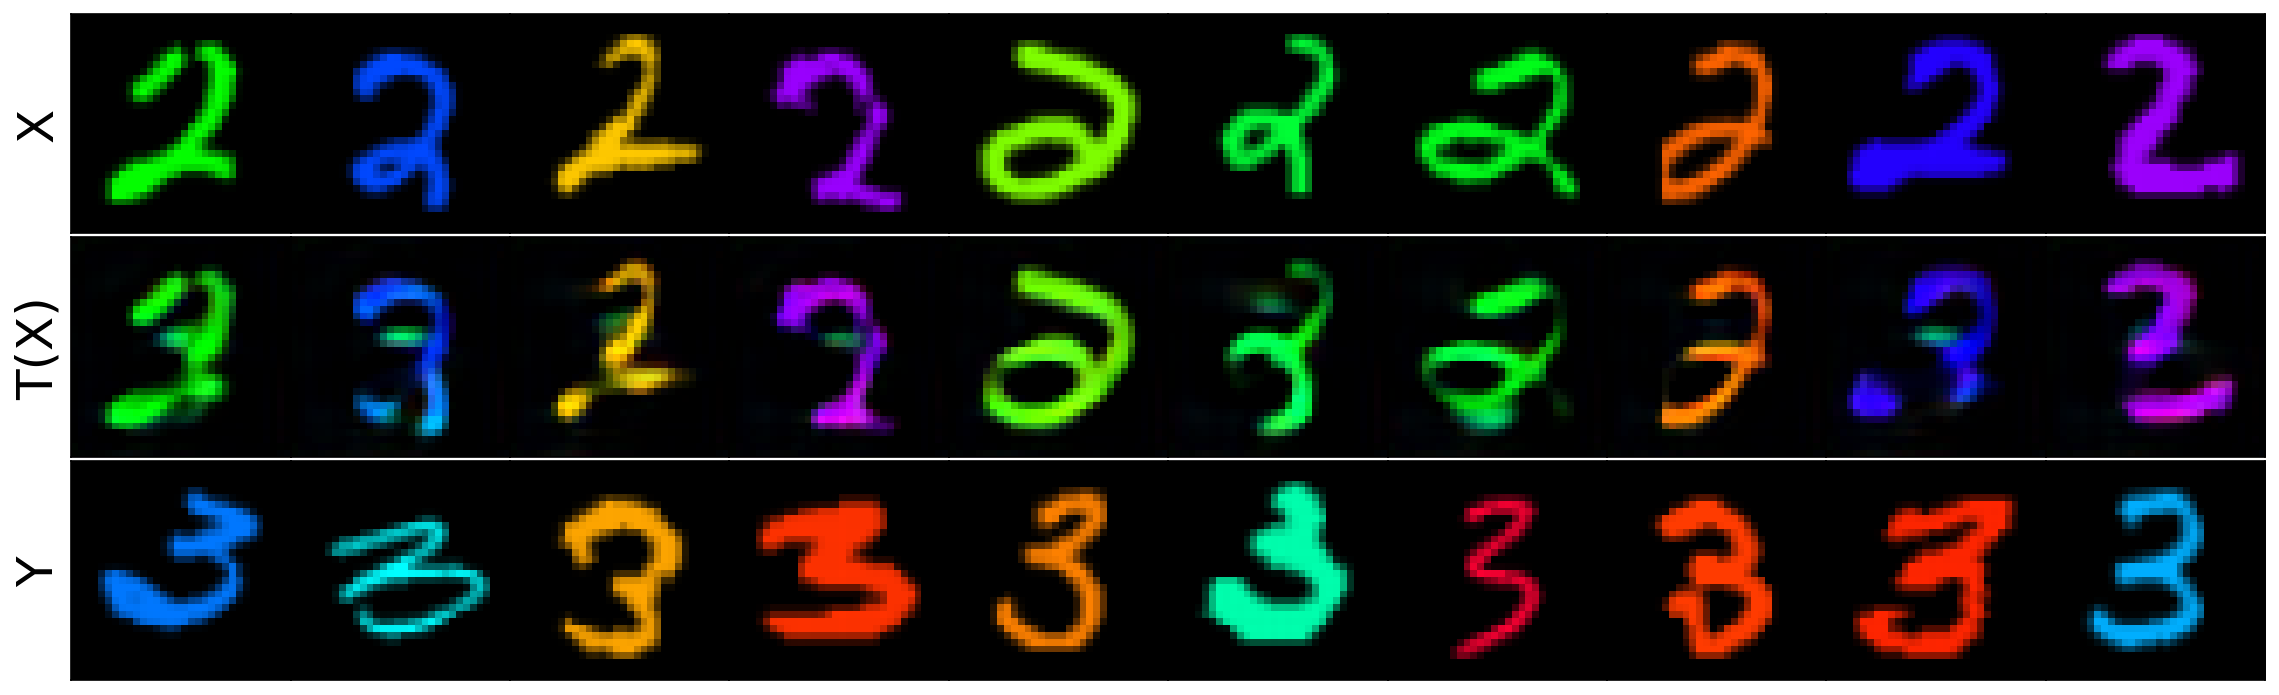

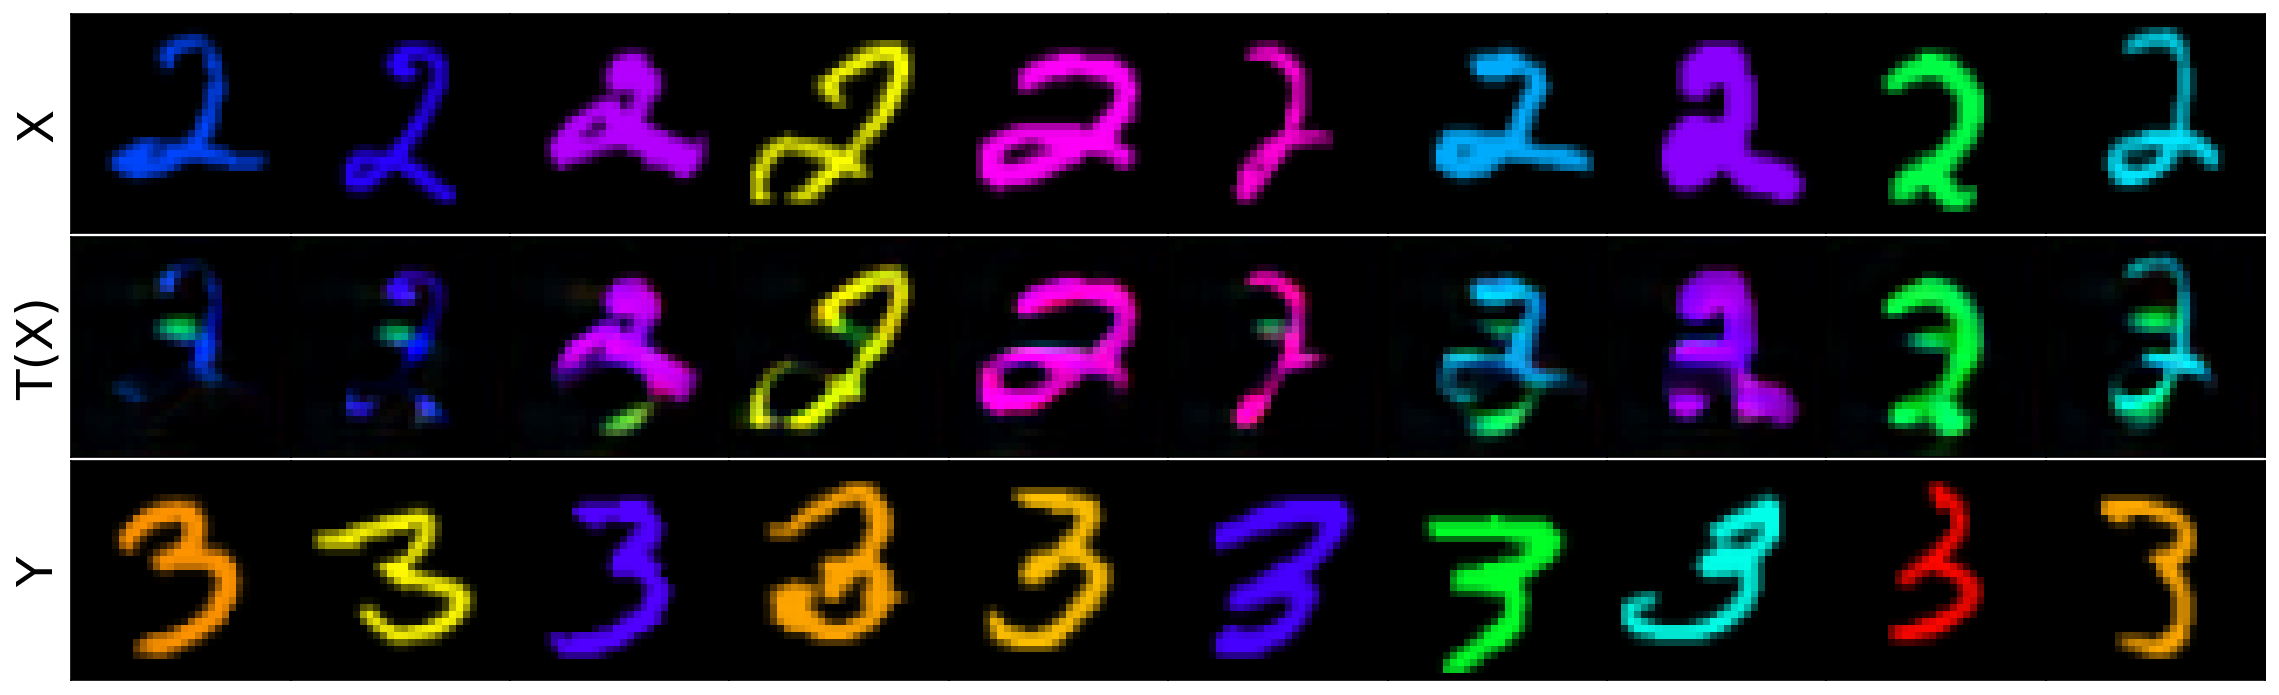

In [12]:
scaler = torch.GradScaler()

for step in tqdm(range(MAX_STEPS)):
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS):
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE)
        with torch.autocast(device_type='cuda', enabled=True):
            T_X = T(X)
            if COST == 'mse':
                T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean()
            else:
                raise Exception('Unknown COST')
            scaler.scale(T_loss).backward()
            scaler.step(T_opt)
            scaler.update()
    wandb.log({f'T_loss' : T_loss.item()}, step=step) 
    del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)
    X = X_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        T_X = T(X)
    Y = Y_sampler.sample(BATCH_SIZE)
    f_opt.zero_grad()
    with torch.autocast(device_type='cuda', enabled=True):
        f_loss = f(T_X).mean() - f(Y).mean()
        scaler.scale(f_loss).backward()
        scaler.step(f_opt)
        scaler.update()
    wandb.log({f'f_loss' : f_loss.item()}, step=step) 
    del f_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()
        
    if step % PLOT_INTERVAL == 0:
        clear_output(wait=True)
        print(f'step {step} of {MAX_STEPS}')
        print('Plotting')
        
        fig, axes = plot_images(X_fixed, Y_fixed, T)
        wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step)
        
        fig, axes = plot_random_images(X_sampler, Y_sampler, T)
        wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        
        mu, sigma, l2, lpips = get_pushed_loader_stats(T, X_test_sampler.loader)
        fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        wandb.log({f'FID' : fid}, step=step)
        wandb.log({f'L2' : l2}, step=step)
        wandb.log({f'LPIPS' : lpips}, step=step)
        del mu, sigma, fid, lpips

    if step % CPKT_INTERVAL == 0:
        
        torch.save(T.state_dict(), f'./checkpoints/T_{step}.pt')
        torch.save(f.state_dict(), f'./checkpoints/f_{step}.pt')
        torch.save(f_opt.state_dict(), f'./checkpoints/f_opt_{step}.pt')
        torch.save(T_opt.state_dict(), f'./checkpoints/T_opt_{step}.pt')
    
    gc.collect(); torch.cuda.empty_cache()